# Pallet and Ground Detection & Segmentation Dataset Creation

### Installs

In [ ]:
# Install necessary packages (only if they aren't installed already)
%pip install einops
%pip install torch torchvision torchaudio
%pip install opencv-python-headless
%pip install tqdm
%pip install supervision
%pip install albumentations
%pip install roboflow
%pip install inference
%pip install git+https://github.com/IDEA-Research/GroundingDINO.git
%pip install git+https://github.com/facebookresearch/segment-anything.git

# import locale
# locale.getpreferredencoding = lambda: 'UTF-8'

  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-939lzkih
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-939lzkih
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 856dde20aee659246248e20734ef9ba5214f5e44
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 21.6 MB/s eta 0:00:00
  Created wheel for groundingdino: filename=groundingdino-0.1.0-cp310-cp310-linux_x86_64.whl size=3045828 sha256=195c5d41fff15a1aee8ff6f5c2585f083ba4a514276a69319a58d910749ccc3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-o2exrwu8/wheels/6b/06/d7/b57f601a4df56af41d262a5b1b496359b13c323bf5ef0434b2
Successfully built groundingdino
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jcl2qv6z
  Running command git cl

### Imports

In [ ]:
import os
import shutil
import random
import cv2
import torch
import numpy as np
from tqdm import tqdm
import torchvision.ops as ops
import matplotlib.pyplot as plt
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
import supervision as sv
from typing import List
import logging
import albumentations as A
import xml.etree.ElementTree as ET
from inference import get_model


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Define Paths

In [ ]:
# Set up directories and paths for Colab environment
HOME = "/content/drive/MyDrive/Pallets_detection"  # Colab's working directory
PALLETS_DIR = os.path.join(HOME, "Pallets")
ANNOTATIONS_DIR = os.path.join(HOME, "Annotations")

# %cd {HOME}
# !git clone https://github.com/IDEA-Research/GroundingDINO.git
# !git clone https://github.com/NVIDIA-AI-IOT/torch2trt
# %cd {HOME}/GroundingDINO
# !git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
# !pip install -q -e .


### **Define Augmentation Pipeline**
Set up a series of image augmentations using `albumentations` library, including flips, rotations, brightness/contrast adjustments, and other distortions to increase dataset diversity.

In [ ]:
# Define the augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.7),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.3),
    A.RandomGamma(p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.GaussNoise(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2)
])



# def augment_and_save_images(original_dir, augmented_dir, num_augmentations=5):
#     """
#     Augment images and save them to the specified directory.

#     Parameters:
#     - original_dir: Directory containing original images.
#     - augmented_dir: Directory to save augmented images.
#     - num_augmentations: Number of augmented versions per image.
#     """
#     image_filenames = [
#         f for f in os.listdir(original_dir)
#         if f.lower().endswith(('.jpg', '.jpeg', '.png')) and "_aug" not in f.lower()
#     ]

#     for image_filename in tqdm(image_filenames, desc="Augmenting Images"):
#         image_path = os.path.join(original_dir, image_filename)
#         image = cv2.imread(image_path)

#         if image is None:
#             logger.warning(f"Failed to read image: {image_path}. Skipping.")
#             continue

#         # Augment and save multiple versions of each image
#         for aug_idx in range(1, num_augmentations + 1):
#             augmented = augmentation_pipeline(image=image)
#             augmented_image = augmented['image']

#             # Define unique filename for each augmented image
#             base_name, ext = os.path.splitext(image_filename)
#             augmented_image_filename = f"{base_name}_aug{aug_idx}{ext}"
#             augmented_image_path = os.path.join(augmented_dir, augmented_image_filename)

#             # Save the augmented image
#             cv2.imwrite(augmented_image_path, augmented_image)

#     logger.info(f"All augmented images saved in: {augmented_dir}")

# # Perform augmentation on all images in the PALLETS_DIR and save them in the same directory
# augment_and_save_images(PALLETS_DIR, PALLETS_DIR, num_augmentations=5)

## **Define Model Paths**
Specify file paths for the model configuration and checkpoint files. Ensure the necessary files are available in Colab.

In [ ]:
# Define model paths (Ensure these files are downloaded or uploaded in Colab)
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

# Create weights directory if it does not exist
if not os.path.exists(os.path.join(HOME, "weights")):
    os.makedirs(os.path.join(HOME, "weights"))

# Download model weights
if not os.path.exists(GROUNDING_DINO_CHECKPOINT_PATH):
    !wget -q -O {GROUNDING_DINO_CHECKPOINT_PATH} "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"

if not os.path.exists(SAM_CHECKPOINT_PATH):
    !wget -q -O {SAM_CHECKPOINT_PATH} "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

print("Model weights downloaded and set up.")

Model weights downloaded and set up.


### **Model Initialization**

In [ ]:
# Initialize models
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH
)
sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

print("Models initialized.")
print(f"Using device: {DEVICE}")


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Models initialized.
Using device: cuda


### **Class Definitions and Helper Functions**

Define detection classes and thresholds, followed by helper functions for preprocessing, segmentation, and applying Non-Maximum Suppression (NMS).

- **Classes and Thresholds**: Specify classes to detect (`floor`, `ground`, etc.) and set confidence thresholds.
- **Segmentation Function**: Uses `SamPredictor` to generate masks for specified bounding boxes.
- **Preprocessing**: Enhances image contrast using YUV color space and histogram equalization.
- **NMS**: Filters overlapping boxes based on confidence, keeping only the highest-scoring detections.


In [ ]:
# Define classes and thresholds
CLASSES = ['floor', 'ground', 'pavement', 'surface', 'carpet', 'tile']

BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.3

# Helper function for segmentation
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []

    # Ensure xyxy is a 2D array
    if xyxy.ndim == 1 and xyxy.size == 4:
        xyxy = xyxy.reshape(1, 4)
    elif xyxy.ndim == 1 and xyxy.size == 0:
        xyxy = np.empty((0, 4))
    elif xyxy.ndim == 2:
        pass  # Already in the correct shape
    else:
        raise ValueError(f"Unexpected shape for xyxy: {xyxy.shape}")

    for box in xyxy:
        try:
            masks, scores, _ = sam_predictor.predict(box=box, multimask_output=True)
            if masks.size == 0:
                continue  # Skip if no masks are returned
            result_masks.append(masks[np.argmax(scores)])
        except Exception as e:
            logger.error(f"Error processing box {box}: {e}")
            continue

    if result_masks:
        return np.array(result_masks)
    else:
        # Return an empty array with shape (0, H, W)
        height, width = image.shape[:2]
        return np.empty((0, height, width), dtype=np.uint8)

# Helper function to preprocess images
def preprocess_image(image):
    # Convert to YUV color space
    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    # Apply histogram equalization to the Y channel
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    # Convert back to BGR
    processed_image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
    return processed_image

# Function to apply NMS
def apply_nms(detections, iou_threshold=0.9):
    if len(detections.xyxy) == 0:
        # No detections to process
        return detections

    # Convert detections to tensors
    boxes = torch.tensor(detections.xyxy, dtype=torch.float32)
    scores = torch.tensor(detections.confidence, dtype=torch.float32)

    # Perform NMS
    keep_indices = ops.nms(boxes, scores, iou_threshold)

    if keep_indices.numel() == 0:
        # No boxes remain after NMS
        detections.xyxy = np.empty((0, 4))
        detections.confidence = np.array([])
        detections.class_id = np.array([])
        if hasattr(detections, 'mask') and detections.mask is not None:
            height, width = detections.mask.shape[1:3]
            detections.mask = np.empty((0, height, width), dtype=np.uint8)
        return detections

    # Filter detections
    keep_indices = keep_indices.cpu().numpy()
    detections.xyxy = detections.xyxy[keep_indices]
    detections.confidence = detections.confidence[keep_indices]
    detections.class_id = detections.class_id[keep_indices]
    if hasattr(detections, 'mask') and detections.mask is not None:
        detections.mask = detections.mask[keep_indices]

    return detections

logger.info("Helper functions defined.")




### **Image Processing, Detection, and Annotation**

1. **Process Images**: Load, preprocess, detect objects, and apply NMS to filter overlapping boxes.
2. **Top Detection Segmentation**: Segment top detections per image using `SamPredictor`.
3. **Annotate & Save**: Annotate images with bounding boxes and masks, then save to `ANNOTATED_IMAGES_DIR`.
4. **Visualize Samples**: Display a few annotated image samples.

**Output**: Annotated images stored and ready for review in `ANNOTATED_IMAGES_DIR`.


Processing images: 100%|██████████| 1574/1574 [1:02:25<00:00,  2.38s/it]


Processing complete for all images.


Annotating and Saving Images: 100%|██████████| 1574/1574 [00:15<00:00, 102.08it/s]


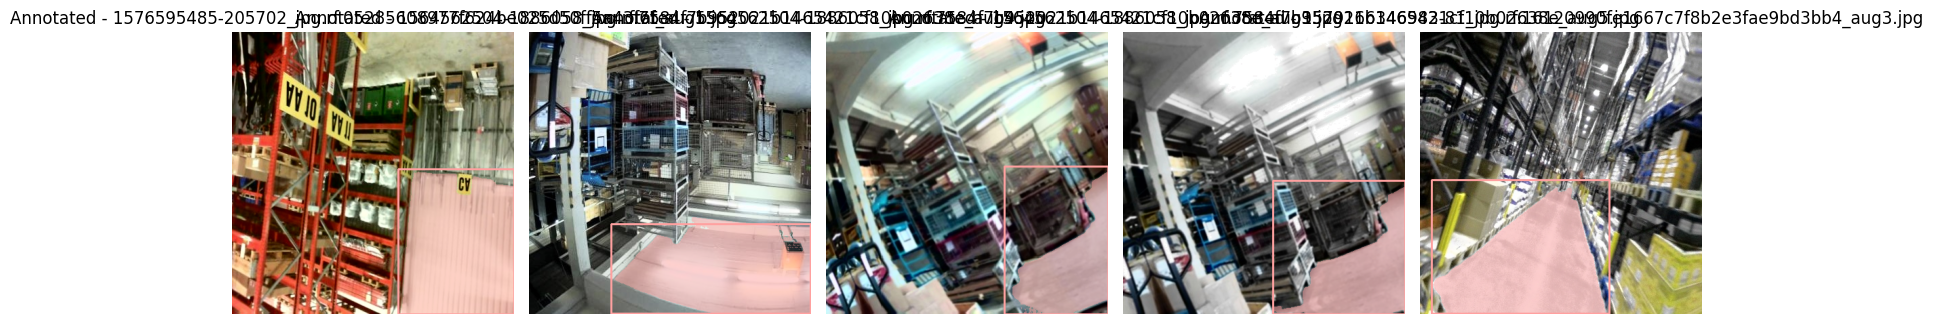

All images saved in: /content/drive/MyDrive/Pallets_detection/Annotations/Annotated_Images


In [ ]:
# Process all images in the Pallets directory
image_paths = [
    os.path.join(PALLETS_DIR, f)
    for f in os.listdir(PALLETS_DIR)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]
images, annotations = {}, {}

for image_path in tqdm(image_paths, desc="Processing images"):
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)

    if image is None:
        logger.warning(f"Failed to read image: {image_path}")
        continue

    # Preprocess the image
    image = preprocess_image(image)

    # Perform detection
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=CLASSES,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD
    )

    # Apply NMS to reduce overlapping boxes
    detections = apply_nms(detections, iou_threshold=0.9)  # Adjusted IoU threshold

    # Log detection details
    logger.info(f"Image: {image_name}, Detections after NMS: {len(detections.xyxy)}")

    # Check if there are any detections
    if len(detections.xyxy) > 0:
        # Select the detection with the highest confidence
        top_index = np.argmax(detections.confidence)
        top_box = detections.xyxy[top_index].reshape(1, 4)
        top_confidence = detections.confidence[top_index]
        top_class_id = detections.class_id[top_index]

        # Handle mask if it exists
        if hasattr(detections, 'mask') and detections.mask is not None and len(detections.mask) > top_index:
            top_mask = detections.mask[top_index].reshape(1, *detections.mask[top_index].shape)
        else:
            # Create a dummy mask with the required shape when a mask isn't available
            height, width = image.shape[:2]
            top_mask = np.empty((1, height, width), dtype=np.uint8)

        # Create a new detections object with only the top detection
        top_detections = sv.Detections(
            xyxy=top_box,
            confidence=np.array([top_confidence]),
            class_id=np.array([top_class_id]),
            mask=top_mask
        )

        # Perform segmentation on the top detection if needed
        top_detections.mask = segment(
            sam_predictor=sam_predictor,
            image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
            xyxy=top_detections.xyxy
        )

        logger.info(f"Top detection for {image_name}: Class ID {top_class_id}, Confidence {top_confidence}")

    else:
        # Handle case with no detections
        height, width = image.shape[:2]
        top_detections = sv.Detections(
            xyxy=np.empty((0, 4)),
            confidence=np.array([]),
            class_id=np.array([]),
            mask=np.empty((0, height, width), dtype=np.uint8)  # Correct empty shape for no detections
        )
        logger.info(f"No detections for {image_name}")

    # Save the top detections and image for annotation generation
    images[image_name] = image
    annotations[image_name] = top_detections

print("Processing complete for all images.")

# Define the output directory within Google Drive
ANNOTATED_IMAGES_DIR = "/content/drive/MyDrive/Pallets_detection/Annotations/Annotated_Images"

# Create the directory if it doesn't exist
os.makedirs(ANNOTATED_IMAGES_DIR, exist_ok=True)

# Initialize annotators with proper color format
color_palette = sv.ColorPalette.DEFAULT
box_annotator = sv.BoxAnnotator(color=color_palette)
mask_annotator = sv.MaskAnnotator(color=color_palette)

# Initialize a list to store a sample of images for visualization
sample_images = []
sample_titles = []

# Loop through each image and its top detection to annotate and save
for idx, (image_name, detections) in enumerate(tqdm(annotations.items(), desc="Annotating and Saving Images")):
    image = images[image_name].copy()

    if len(detections.xyxy) == 0:
        # No detections; save the original image
        annotated_image = image
    else:
        # Check if class_id and confidence are valid
        if detections.class_id is not None and detections.confidence is not None and len(detections.class_id) > 0 and len(detections.confidence) > 0:
            # Create label for the top detection
            label = f"{CLASSES[int(detections.class_id[0])]} {detections.confidence[0]:0.2f}"

            # Create filtered detections
            filtered_detections = sv.Detections(
                xyxy=detections.xyxy,
                confidence=detections.confidence,
                class_id=detections.class_id,
                mask=detections.mask if detections.mask is not None else None
            )
            filtered_detections.labels = [label]

            # Annotate the image
            annotated_image = image.copy()
            if hasattr(filtered_detections, 'mask') and filtered_detections.mask is not None and len(filtered_detections.mask) > 0:
                annotated_image = mask_annotator.annotate(scene=annotated_image, detections=filtered_detections)
            annotated_image = box_annotator.annotate(scene=annotated_image, detections=filtered_detections)
        else:
            # Handle missing class_id or confidence by skipping annotation
            logger.warning(f"Missing class_id or confidence for {image_name}. Saving the original image without annotation.")
            annotated_image = image

    # Save annotated (or original) image
    annotated_save_path = os.path.join(ANNOTATED_IMAGES_DIR, f"annotated_{image_name}")
    success = cv2.imwrite(annotated_save_path, annotated_image)
    if not success:
        logger.error(f"Failed to save image for {image_name}")

    # Store sample images
    if idx < 5:
        sample_images.append(annotated_image)
        sample_titles.append(f"Annotated - {image_name}")


# Visualize sample images
if sample_images:
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    axes = [axes] if len(sample_images) == 1 else axes

    for ax, img, title in zip(axes, sample_images, sample_titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No annotated images to display.")

print(f"All images saved in: {ANNOTATED_IMAGES_DIR}")


In [ ]:
XML_ANNOTATIONS_DIR = os.path.join(ANNOTATIONS_DIR, "XML_Annotations_ground")
os.makedirs(XML_ANNOTATIONS_DIR, exist_ok=True)

# Generate annotations in Pascal VOC format and save XML files
dataset = sv.DetectionDataset(classes=CLASSES, images=images, annotations=annotations)
dataset.as_pascal_voc(
    annotations_directory_path=XML_ANNOTATIONS_DIR,
    min_image_area_percentage=0.002,
    max_image_area_percentage=0.80,
    approximation_percentage=0.75
)

print(f"Annotations saved in: {XML_ANNOTATIONS_DIR}")

SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


Annotations saved in: /content/drive/MyDrive/Pallets_detection/Annotations/XML_Annotations_ground


# **Pallet Detection and Annotation**

1. **Setup**: Initialize logging, directories, Roboflow, and SAM models.
2. **Segmentation**: Define a helper to segment detected boxes with `SamPredictor`.
3. **Annotators**: Set up for bounding boxes, labels, and masks.
4. **Process Images**: Detect, segment, annotate, and save images in `ANNOTATED_PALLET_IMAGES_DIR`.
5. **Save Annotations**: Export annotations as Pascal VOC XML to `XML_PALLET_ANNOTATIONS_DIR`.

**Output**: Annotated images and XML annotations saved.


In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up directories
ANNOTATED_PALLET_IMAGES_DIR = os.path.join(HOME, "Annotations", "Annotated_Pallet_Images")
os.makedirs(ANNOTATED_PALLET_IMAGES_DIR, exist_ok=True)

# Initialize two Roboflow models
API_KEY = 'NLwEgls9UIv3Q9O2tRGi'
model_1 = get_model(model_id="stacked-pallet/2", api_key=API_KEY)  # First model
model_2 = get_model(model_id="mask_rcnn-73vt5/4", api_key=API_KEY)  # Second model

print("Both Roboflow models loaded for pallet detection.")

# Initialize SAM model
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
os.makedirs(os.path.dirname(SAM_CHECKPOINT_PATH), exist_ok=True)

if not os.path.exists(SAM_CHECKPOINT_PATH):
    !wget -q -O {SAM_CHECKPOINT_PATH} "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)
print("SAM model initialized.")

# Helper function for segmentation using SAM
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []

    if xyxy.ndim == 1 and xyxy.size == 4:
        xyxy = xyxy.reshape(1, 4)
    elif xyxy.ndim == 1 and xyxy.size == 0:
        xyxy = np.empty((0, 4))
    elif xyxy.ndim == 2:
        pass
    else:
        raise ValueError(f"Unexpected shape for xyxy: {xyxy.shape}")

    for box in xyxy:
        try:
            masks, scores, _ = sam_predictor.predict(box=box, multimask_output=True)
            if masks.size == 0:
                continue
            result_masks.append(masks[np.argmax(scores)])
        except Exception as e:
            print(f"Error processing box {box}: {e}")
            continue

    if result_masks:
        return np.array(result_masks)
    else:
        height, width = image.shape[:2]
        return np.empty((0, height, width), dtype=np.uint8)

# Define class name for annotation
CLASSES = ['pallet']

# Initialize annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
mask_annotator = sv.MaskAnnotator()

# Process images in the PALLETS_DIR
image_paths = [
    os.path.join(PALLETS_DIR, f)
    for f in os.listdir(PALLETS_DIR)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Initialize dictionaries to store images and annotations for consistency
images = {}
annotations = {}

for image_path in tqdm(image_paths, desc="Processing Pallet Images"):
    image_name = os.path.basename(image_path)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to load image: {image_name}")
        continue

    # Run inference with both models and combine the results
    results_1 = model_1.infer(image)[0]
    results_2 = model_2.infer(image)[0]
    detections_1 = sv.Detections.from_inference(results_1)
    detections_2 = sv.Detections.from_inference(results_2)

    # Combine bounding boxes, confidence scores, and class IDs
    combined_xyxy = np.concatenate([detections_1.xyxy, detections_2.xyxy], axis=0)
    combined_confidences = np.concatenate([detections_1.confidence, detections_2.confidence], axis=0)
    combined_class_ids = np.zeros_like(combined_confidences, dtype=int)  # Set all class IDs to 0 for 'pallet'

    # Perform segmentation on the combined detections
    masks = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=combined_xyxy
    )

    # Create a combined Detections object
    combined_detections = sv.Detections(
        xyxy=combined_xyxy,
        confidence=combined_confidences,
        class_id=combined_class_ids,
        mask=masks
    )

    # Store image and annotation data in dictionaries
    images[image_name] = image
    annotations[image_name] = combined_detections

    # Annotate the image
    annotated_image = image.copy()
    if combined_detections.mask is not None and len(combined_detections.mask) > 0:
        annotated_image = mask_annotator.annotate(scene=annotated_image, detections=combined_detections)
    annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=combined_detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=combined_detections)

    # Save the annotated image
    annotated_save_path = os.path.join(ANNOTATED_PALLET_IMAGES_DIR, f"annotated_{image_name}")
    success = cv2.imwrite(annotated_save_path, annotated_image)
    if success:
        print(f"Saved annotated image for {image_name}")
    else:
        print(f"Failed to save annotated image for {image_name}")

print("Processing of pallet images complete.")

# Save Pascal VOC format XML files
XML_PALLET_ANNOTATIONS_DIR = os.path.join(ANNOTATIONS_DIR, "XML_Annotations_pallets")
os.makedirs(XML_PALLET_ANNOTATIONS_DIR, exist_ok=True)

# Generate annotations in Pascal VOC format and save XML files
dataset = sv.DetectionDataset(classes=CLASSES, images=images, annotations=annotations)
dataset.as_pascal_voc(
    annotations_directory_path=XML_PALLET_ANNOTATIONS_DIR,
    min_image_area_percentage=0.002,
    max_image_area_percentage=0.80,
    approximation_percentage=0.75
)

print(f"Annotations saved in: {XML_PALLET_ANNOTATIONS_DIR}")


Both Roboflow models loaded for pallet detection.
SAM model initialized.


Processing Pallet Images:   0%|          | 1/1574 [00:02<1:03:14,  2.41s/it]

Saved annotated image for 1576595485-205702_jpg.rf.05285608977f624be025d50ff5a43f6f_aug5.jpg


Processing Pallet Images:   0%|          | 2/1574 [00:04<59:20,  2.26s/it]  

Saved annotated image for 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug4.jpg


Processing Pallet Images:   0%|          | 3/1574 [00:06<57:26,  2.19s/it]

Saved annotated image for 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug3.jpg


Processing Pallet Images:   0%|          | 4/1574 [00:08<56:34,  2.16s/it]

Saved annotated image for 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug5.jpg


Processing Pallet Images:   0%|          | 5/1574 [00:10<56:40,  2.17s/it]

Saved annotated image for 1579166346983-81_jpg.rf.16120990fe1667c7f8b2e3fae9bd3bb4_aug3.jpg


Processing Pallet Images:   0%|          | 6/1574 [00:13<57:35,  2.20s/it]

Saved annotated image for 1579165261-1098924_jpg.rf.76b6ff9d21147dc719172e22647b8fb6_aug2.jpg


Processing Pallet Images:   0%|          | 7/1574 [00:15<57:19,  2.20s/it]

Saved annotated image for 1576595710-5028307_jpg.rf.491a6ef00003e204b00f62ebd420b633_aug2.jpg


Processing Pallet Images:   1%|          | 8/1574 [00:17<57:23,  2.20s/it]

Saved annotated image for 1576595710-5028307_jpg.rf.491a6ef00003e204b00f62ebd420b633_aug5.jpg


Processing Pallet Images:   1%|          | 9/1574 [00:19<58:39,  2.25s/it]

Saved annotated image for 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8_aug1.jpg


Processing Pallet Images:   1%|          | 10/1574 [00:22<59:26,  2.28s/it]

Saved annotated image for 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8_aug2.jpg


Processing Pallet Images:   1%|          | 11/1574 [00:24<1:00:14,  2.31s/it]

Saved annotated image for 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8_aug4.jpg


Processing Pallet Images:   1%|          | 12/1574 [00:27<1:00:57,  2.34s/it]

Saved annotated image for 1574681742-2271585_jpg.rf.1bb7bd8dd359858648d9101fdda05570_aug2.jpg


Processing Pallet Images:   1%|          | 13/1574 [00:29<1:01:25,  2.36s/it]

Saved annotated image for 1574681742-2271585_jpg.rf.1bb7bd8dd359858648d9101fdda05570_aug1.jpg


Processing Pallet Images:   1%|          | 14/1574 [00:31<1:01:23,  2.36s/it]

Saved annotated image for 1574681742-2271585_jpg.rf.1bb7bd8dd359858648d9101fdda05570_aug5.jpg


Processing Pallet Images:   1%|          | 15/1574 [00:34<1:02:12,  2.39s/it]

Saved annotated image for 1574676213390-33_jpg.rf.4b49d5990fcf944682bf30f4c05452b8_aug2.jpg


Processing Pallet Images:   1%|          | 16/1574 [00:36<1:02:33,  2.41s/it]

Saved annotated image for 1574676213390-33_jpg.rf.4b49d5990fcf944682bf30f4c05452b8_aug3.jpg


Processing Pallet Images:   1%|          | 17/1574 [00:39<1:02:25,  2.41s/it]

Saved annotated image for 1574676213390-33_jpg.rf.4b49d5990fcf944682bf30f4c05452b8_aug4.jpg


Processing Pallet Images:   1%|          | 18/1574 [00:41<1:00:28,  2.33s/it]

Saved annotated image for 1574680939-0240667_jpg.rf.561d7fcd0928f324d4dbdc2f20d26ca7_aug1.jpg


Processing Pallet Images:   1%|          | 19/1574 [00:43<59:16,  2.29s/it]  

Saved annotated image for 1574680939-0240667_jpg.rf.561d7fcd0928f324d4dbdc2f20d26ca7_aug3.jpg


Processing Pallet Images:   1%|▏         | 20/1574 [00:45<59:02,  2.28s/it]

Saved annotated image for 1574680939-0240667_jpg.rf.561d7fcd0928f324d4dbdc2f20d26ca7_aug4.jpg


Processing Pallet Images:   1%|▏         | 21/1574 [00:47<58:11,  2.25s/it]

Saved annotated image for 1574680939-0240667_jpg.rf.561d7fcd0928f324d4dbdc2f20d26ca7_aug5.jpg


Processing Pallet Images:   1%|▏         | 22/1574 [00:50<57:54,  2.24s/it]

Saved annotated image for 1564563406-4411542_jpg.rf.0f631011721eeee47a730b04ff87a84b_aug3.jpg


Processing Pallet Images:   1%|▏         | 23/1574 [00:52<56:50,  2.20s/it]

Saved annotated image for 1583417329-3613424_jpg.rf.3bc2c1b3a6e9e7b971e37389506c91e5_aug3.jpg


Processing Pallet Images:   2%|▏         | 24/1574 [00:54<56:26,  2.19s/it]

Saved annotated image for 1583417329-3613424_jpg.rf.3bc2c1b3a6e9e7b971e37389506c91e5_aug4.jpg


Processing Pallet Images:   2%|▏         | 25/1574 [00:56<55:45,  2.16s/it]

Saved annotated image for 1583417329-3613424_jpg.rf.3bc2c1b3a6e9e7b971e37389506c91e5_aug5.jpg


Processing Pallet Images:   2%|▏         | 26/1574 [00:58<55:28,  2.15s/it]

Saved annotated image for 1574680561-9260354_jpg.rf.1feaa57c07920edca9f3d7b29a34e0fb_aug2.jpg


Processing Pallet Images:   2%|▏         | 27/1574 [01:00<55:54,  2.17s/it]

Saved annotated image for 1574680561-9260354_jpg.rf.1feaa57c07920edca9f3d7b29a34e0fb_aug3.jpg


Processing Pallet Images:   2%|▏         | 28/1574 [01:03<55:43,  2.16s/it]

Saved annotated image for 1366296-2234_jpg.rf.740577a518467a1a9bba1f689b88c99e_aug3.jpg


Processing Pallet Images:   2%|▏         | 29/1574 [01:05<55:37,  2.16s/it]

Saved annotated image for 1366296-2234_jpg.rf.740577a518467a1a9bba1f689b88c99e_aug4.jpg


Processing Pallet Images:   2%|▏         | 30/1574 [01:07<54:43,  2.13s/it]

Saved annotated image for 1576592934-1571093_jpg.rf.1a89c282758643faf04e830c8a57f3c7_aug1.jpg


Processing Pallet Images:   2%|▏         | 31/1574 [01:09<54:18,  2.11s/it]

Saved annotated image for 1576592934-1571093_jpg.rf.1a89c282758643faf04e830c8a57f3c7_aug3.jpg


Processing Pallet Images:   2%|▏         | 32/1574 [01:11<54:03,  2.10s/it]

Saved annotated image for 1576592934-1571093_jpg.rf.1a89c282758643faf04e830c8a57f3c7_aug2.jpg


Processing Pallet Images:   2%|▏         | 33/1574 [01:13<54:37,  2.13s/it]

Saved annotated image for 1576592934-1571093_jpg.rf.1a89c282758643faf04e830c8a57f3c7_aug5.jpg


Processing Pallet Images:   2%|▏         | 34/1574 [01:15<53:57,  2.10s/it]

Saved annotated image for 1579163354-132157_jpg.rf.289aeb0f60f9668c62574e9388a1d9f7_aug1.jpg


Processing Pallet Images:   2%|▏         | 35/1574 [01:17<53:50,  2.10s/it]

Saved annotated image for 1579163354-132157_jpg.rf.289aeb0f60f9668c62574e9388a1d9f7_aug2.jpg


Processing Pallet Images:   2%|▏         | 36/1574 [01:19<53:53,  2.10s/it]

Saved annotated image for 1579163354-132157_jpg.rf.289aeb0f60f9668c62574e9388a1d9f7_aug5.jpg


Processing Pallet Images:   2%|▏         | 37/1574 [01:22<54:13,  2.12s/it]

Saved annotated image for 1576592954057-88_jpg.rf.63c85055760fb921a8ef4df50733430c_aug1.jpg


Processing Pallet Images:   2%|▏         | 38/1574 [01:24<54:54,  2.14s/it]

Saved annotated image for 1579163354-132157_jpg.rf.289aeb0f60f9668c62574e9388a1d9f7_aug4.jpg


Processing Pallet Images:   2%|▏         | 39/1574 [01:26<54:12,  2.12s/it]

Saved annotated image for 1576592954057-88_jpg.rf.63c85055760fb921a8ef4df50733430c_aug5.jpg


Processing Pallet Images:   3%|▎         | 40/1574 [01:28<54:07,  2.12s/it]

Saved annotated image for 2491108-3865_jpg.rf.255ce2e0dc92b196929aebe8c1f6eacf_aug3.jpg


Processing Pallet Images:   3%|▎         | 41/1574 [01:30<53:44,  2.10s/it]

Saved annotated image for 1014902-4606_jpg.rf.6898a8c6018412c618f84392537fea7d_aug1.jpg


Processing Pallet Images:   3%|▎         | 42/1574 [01:32<53:37,  2.10s/it]

Saved annotated image for 1014902-4606_jpg.rf.6898a8c6018412c618f84392537fea7d_aug2.jpg


Processing Pallet Images:   3%|▎         | 43/1574 [01:34<53:40,  2.10s/it]

Saved annotated image for 2491108-3865_jpg.rf.255ce2e0dc92b196929aebe8c1f6eacf_aug5.jpg


Processing Pallet Images:   3%|▎         | 44/1574 [01:36<54:00,  2.12s/it]

Saved annotated image for 1014902-4606_jpg.rf.6898a8c6018412c618f84392537fea7d_aug3.jpg


Processing Pallet Images:   3%|▎         | 45/1574 [01:38<53:58,  2.12s/it]

Saved annotated image for 1576592000-1564353_jpg.rf.580892708b7e91122b31fea445d4ed44_aug2.jpg


Processing Pallet Images:   3%|▎         | 46/1574 [01:41<54:55,  2.16s/it]

Saved annotated image for 1574676035-976945_jpg.rf.1a32d52acf90003d721ae3668f98bd94_aug3.jpg


Processing Pallet Images:   3%|▎         | 47/1574 [01:43<55:36,  2.19s/it]

Saved annotated image for 515040422-5261_jpg.rf.1934272c7cb7042d4514fd6404b558fd_aug1.jpg


Processing Pallet Images:   3%|▎         | 48/1574 [01:45<56:02,  2.20s/it]

Saved annotated image for 515040422-5261_jpg.rf.1934272c7cb7042d4514fd6404b558fd_aug2.jpg


Processing Pallet Images:   3%|▎         | 49/1574 [01:47<56:27,  2.22s/it]

Saved annotated image for 2028862-5421_jpg.rf.4c3ebb7a7a9b315be7ea05257b4f281c_aug3.jpg


Processing Pallet Images:   3%|▎         | 50/1574 [01:50<56:39,  2.23s/it]

Saved annotated image for 515040422-5261_jpg.rf.1934272c7cb7042d4514fd6404b558fd_aug5.jpg


Processing Pallet Images:   3%|▎         | 51/1574 [01:52<55:56,  2.20s/it]

Saved annotated image for 2028862-5421_jpg.rf.4c3ebb7a7a9b315be7ea05257b4f281c_aug1.jpg


Processing Pallet Images:   3%|▎         | 52/1574 [01:54<56:06,  2.21s/it]

Saved annotated image for 2028862-5421_jpg.rf.4c3ebb7a7a9b315be7ea05257b4f281c_aug4.jpg


Processing Pallet Images:   3%|▎         | 53/1574 [01:56<56:31,  2.23s/it]

Saved annotated image for 2028862-5421_jpg.rf.4c3ebb7a7a9b315be7ea05257b4f281c_aug2.jpg


Processing Pallet Images:   3%|▎         | 54/1574 [01:59<56:50,  2.24s/it]

Saved annotated image for 2028862-5421_jpg.rf.4c3ebb7a7a9b315be7ea05257b4f281c_aug5.jpg


Processing Pallet Images:   3%|▎         | 55/1574 [02:01<57:07,  2.26s/it]

Saved annotated image for 1564562629-5272853_jpg.rf.09658164b37e6f28bb33a5999c4366b2_aug1.jpg


Processing Pallet Images:   4%|▎         | 56/1574 [02:03<57:06,  2.26s/it]

Saved annotated image for 1564562629-5272853_jpg.rf.09658164b37e6f28bb33a5999c4366b2_aug3.jpg


Processing Pallet Images:   4%|▎         | 57/1574 [02:05<56:59,  2.25s/it]

Saved annotated image for 1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug1.jpg


Processing Pallet Images:   4%|▎         | 58/1574 [02:08<56:47,  2.25s/it]

Saved annotated image for 1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug3.jpg


Processing Pallet Images:   4%|▎         | 59/1574 [02:10<56:38,  2.24s/it]

Saved annotated image for 2708886-7657_jpg.rf.0d625945835f8553c5bf733a4b3bf0ee_aug1.jpg


Processing Pallet Images:   4%|▍         | 60/1574 [02:12<56:37,  2.24s/it]

Saved annotated image for 1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c_aug5.jpg


Processing Pallet Images:   4%|▍         | 61/1574 [02:14<56:41,  2.25s/it]

Saved annotated image for 2708886-7657_jpg.rf.0d625945835f8553c5bf733a4b3bf0ee_aug4.jpg


Processing Pallet Images:   4%|▍         | 62/1574 [02:17<56:29,  2.24s/it]

Saved annotated image for 2708886-7657_jpg.rf.0d625945835f8553c5bf733a4b3bf0ee_aug3.jpg


Processing Pallet Images:   4%|▍         | 63/1574 [02:19<56:41,  2.25s/it]

Saved annotated image for 2708886-7657_jpg.rf.0d625945835f8553c5bf733a4b3bf0ee_aug5.jpg


Processing Pallet Images:   4%|▍         | 64/1574 [02:21<56:02,  2.23s/it]

Saved annotated image for 1579164192-1308327_jpg.rf.398807130a0d855e933415fb28e8febe_aug1.jpg


Processing Pallet Images:   4%|▍         | 65/1574 [02:23<56:12,  2.24s/it]

Saved annotated image for 1579164192-1308327_jpg.rf.398807130a0d855e933415fb28e8febe_aug3.jpg


Processing Pallet Images:   4%|▍         | 66/1574 [02:25<55:42,  2.22s/it]

Saved annotated image for 1579164192-1308327_jpg.rf.398807130a0d855e933415fb28e8febe_aug5.jpg


Processing Pallet Images:   4%|▍         | 67/1574 [02:28<55:06,  2.19s/it]

Saved annotated image for 1576593905-9443617_jpg.rf.5077929de4d90c3878603e39563a7ef2_aug2.jpg


Processing Pallet Images:   4%|▍         | 68/1574 [02:30<55:31,  2.21s/it]

Saved annotated image for 1576593905-9443617_jpg.rf.5077929de4d90c3878603e39563a7ef2_aug3.jpg


Processing Pallet Images:   4%|▍         | 69/1574 [02:32<54:39,  2.18s/it]

Saved annotated image for 1576593905-9443617_jpg.rf.5077929de4d90c3878603e39563a7ef2_aug5.jpg


Processing Pallet Images:   4%|▍         | 70/1574 [02:34<54:08,  2.16s/it]

Saved annotated image for 1576595718-2912374_jpg.rf.653ee2bd6ad1e22845b028312a7e6fb6_aug2.jpg


Processing Pallet Images:   5%|▍         | 71/1574 [02:36<53:37,  2.14s/it]

Saved annotated image for 1576595718-2912374_jpg.rf.653ee2bd6ad1e22845b028312a7e6fb6_aug5.jpg


Processing Pallet Images:   5%|▍         | 72/1574 [02:38<53:46,  2.15s/it]

Saved annotated image for 1576595718-2912374_jpg.rf.653ee2bd6ad1e22845b028312a7e6fb6_aug3.jpg


Processing Pallet Images:   5%|▍         | 73/1574 [02:40<53:23,  2.13s/it]

Saved annotated image for 1576595718-2912374_jpg.rf.653ee2bd6ad1e22845b028312a7e6fb6_aug4.jpg


Processing Pallet Images:   5%|▍         | 74/1574 [02:43<53:05,  2.12s/it]

Saved annotated image for 1564562913-2493865_jpg.rf.163a1ee0702c27f021280e80c87ef219_aug4.jpg


Processing Pallet Images:   5%|▍         | 75/1574 [02:45<52:54,  2.12s/it]

Saved annotated image for 1576593810-7481027_jpg.rf.0d6b7942be1a7777a1e0de635234ce45_aug1.jpg


Processing Pallet Images:   5%|▍         | 76/1574 [02:47<52:57,  2.12s/it]

Saved annotated image for 1576593810-7481027_jpg.rf.0d6b7942be1a7777a1e0de635234ce45_aug2.jpg


Processing Pallet Images:   5%|▍         | 77/1574 [02:49<53:06,  2.13s/it]

Saved annotated image for 1576593810-7481027_jpg.rf.0d6b7942be1a7777a1e0de635234ce45_aug5.jpg


Processing Pallet Images:   5%|▍         | 78/1574 [02:51<53:00,  2.13s/it]

Saved annotated image for 510646544-4627_jpg.rf.511284305ff2aeb2a970956533b0fdb2_aug2.jpg


Processing Pallet Images:   5%|▌         | 79/1574 [02:53<53:36,  2.15s/it]

Saved annotated image for 510646544-4627_jpg.rf.511284305ff2aeb2a970956533b0fdb2_aug5.jpg


Processing Pallet Images:   5%|▌         | 80/1574 [02:55<54:12,  2.18s/it]

Saved annotated image for 2500008-3284_jpg.rf.63a8ad39edb471d6159f98d6d31bc62d_aug2.jpg


Processing Pallet Images:   5%|▌         | 81/1574 [02:58<54:36,  2.19s/it]

Saved annotated image for 2500008-3284_jpg.rf.63a8ad39edb471d6159f98d6d31bc62d_aug5.jpg


Processing Pallet Images:   5%|▌         | 82/1574 [03:00<58:39,  2.36s/it]

Saved annotated image for 1579163715848-79_jpg.rf.01cce78460c67b680cfab8c4dd0f5498_aug1.jpg


Processing Pallet Images:   5%|▌         | 83/1574 [03:04<1:04:20,  2.59s/it]

Saved annotated image for 1579163715848-79_jpg.rf.01cce78460c67b680cfab8c4dd0f5498_aug3.jpg


Processing Pallet Images:   5%|▌         | 84/1574 [03:07<1:07:33,  2.72s/it]

Saved annotated image for 1579163715848-79_jpg.rf.01cce78460c67b680cfab8c4dd0f5498_aug4.jpg


Processing Pallet Images:   5%|▌         | 85/1574 [03:09<1:03:13,  2.55s/it]

Saved annotated image for 1574678432-8292773_jpg.rf.255fe6557d37a50d93fba45bfa05aff1_aug1.jpg


Processing Pallet Images:   5%|▌         | 86/1574 [03:11<59:56,  2.42s/it]  

Saved annotated image for 1574678432-8292773_jpg.rf.255fe6557d37a50d93fba45bfa05aff1_aug4.jpg


Processing Pallet Images:   6%|▌         | 87/1574 [03:13<57:31,  2.32s/it]

Saved annotated image for 1574678432-8292773_jpg.rf.255fe6557d37a50d93fba45bfa05aff1_aug3.jpg


Processing Pallet Images:   6%|▌         | 88/1574 [03:15<56:28,  2.28s/it]

Saved annotated image for 1574678432-8292773_jpg.rf.255fe6557d37a50d93fba45bfa05aff1_aug5.jpg


Processing Pallet Images:   6%|▌         | 89/1574 [03:17<55:29,  2.24s/it]

Saved annotated image for 1576596229358-07_jpg.rf.4edadb2deabd623fd63ff0a58e6f4aa2_aug2.jpg


Processing Pallet Images:   6%|▌         | 90/1574 [03:20<55:05,  2.23s/it]

Saved annotated image for 1576596229358-07_jpg.rf.4edadb2deabd623fd63ff0a58e6f4aa2_aug4.jpg


Processing Pallet Images:   6%|▌         | 91/1574 [03:22<54:57,  2.22s/it]

Saved annotated image for 1564563917-9067333_jpg.rf.0ba6d542596347fff84f4d70476313a6_aug4.jpg


Processing Pallet Images:   6%|▌         | 92/1574 [03:24<54:40,  2.21s/it]

Saved annotated image for 1564563917-9067333_jpg.rf.0ba6d542596347fff84f4d70476313a6_aug2.jpg


Processing Pallet Images:   6%|▌         | 93/1574 [03:26<54:05,  2.19s/it]

Saved annotated image for 1564563917-9067333_jpg.rf.0ba6d542596347fff84f4d70476313a6_aug1.jpg


Processing Pallet Images:   6%|▌         | 94/1574 [03:28<54:07,  2.19s/it]

Saved annotated image for 1564563917-9067333_jpg.rf.0ba6d542596347fff84f4d70476313a6_aug5.jpg


Processing Pallet Images:   6%|▌         | 95/1574 [03:30<54:18,  2.20s/it]

Saved annotated image for 1579165190-3987918_jpg.rf.749bd810b0f85771a182e5e989a7ecaa_aug2.jpg


Processing Pallet Images:   6%|▌         | 96/1574 [03:33<53:30,  2.17s/it]

Saved annotated image for 1579165190-3987918_jpg.rf.749bd810b0f85771a182e5e989a7ecaa_aug5.jpg


Processing Pallet Images:   6%|▌         | 97/1574 [03:35<53:50,  2.19s/it]

Saved annotated image for 3487299-7817_jpg.rf.2f1c30bf81181796f9657be3ffa8a233_aug1.jpg


Processing Pallet Images:   6%|▌         | 98/1574 [03:37<53:24,  2.17s/it]

Saved annotated image for 3487299-7817_jpg.rf.2f1c30bf81181796f9657be3ffa8a233_aug3.jpg


Processing Pallet Images:   6%|▋         | 99/1574 [03:39<53:04,  2.16s/it]

Saved annotated image for 1564562881-697836_jpg.rf.79ec22c041097a4022f1a07bac69c638_aug1.jpg


Processing Pallet Images:   6%|▋         | 100/1574 [03:41<53:01,  2.16s/it]

Saved annotated image for 1564562881-697836_jpg.rf.79ec22c041097a4022f1a07bac69c638_aug2.jpg


Processing Pallet Images:   6%|▋         | 101/1574 [03:43<52:35,  2.14s/it]

Saved annotated image for 1564562881-697836_jpg.rf.79ec22c041097a4022f1a07bac69c638_aug3.jpg


Processing Pallet Images:   6%|▋         | 102/1574 [03:45<52:24,  2.14s/it]

Saved annotated image for 1564562881-697836_jpg.rf.79ec22c041097a4022f1a07bac69c638_aug4.jpg


Processing Pallet Images:   7%|▋         | 103/1574 [03:48<53:02,  2.16s/it]

Saved annotated image for 1574675843344-91_jpg.rf.1cf349c1c3d1d870f38af2204341c703_aug4.jpg


Processing Pallet Images:   7%|▋         | 104/1574 [03:50<53:26,  2.18s/it]

Saved annotated image for 1574675843344-91_jpg.rf.1cf349c1c3d1d870f38af2204341c703_aug1.jpg


Processing Pallet Images:   7%|▋         | 105/1574 [03:52<54:32,  2.23s/it]

Saved annotated image for 1579163711-889331_jpg.rf.48801ef97ca3cf8b03948e68d7b35625_aug1.jpg


Processing Pallet Images:   7%|▋         | 106/1574 [03:55<54:53,  2.24s/it]

Saved annotated image for 1579163711-889331_jpg.rf.48801ef97ca3cf8b03948e68d7b35625_aug3.jpg


Processing Pallet Images:   7%|▋         | 107/1574 [03:57<55:14,  2.26s/it]

Saved annotated image for 1579163711-889331_jpg.rf.48801ef97ca3cf8b03948e68d7b35625_aug5.jpg


Processing Pallet Images:   7%|▋         | 108/1574 [03:59<55:36,  2.28s/it]

Saved annotated image for 1579163711-889331_jpg.rf.48801ef97ca3cf8b03948e68d7b35625_aug4.jpg


Processing Pallet Images:   7%|▋         | 109/1574 [04:01<55:15,  2.26s/it]

Saved annotated image for 3528232-376_jpg.rf.3d7df962c2ed2912da041654db42a119_aug3.jpg


Processing Pallet Images:   7%|▋         | 110/1574 [04:04<55:11,  2.26s/it]

Saved annotated image for 3528232-376_jpg.rf.3d7df962c2ed2912da041654db42a119_aug2.jpg


Processing Pallet Images:   7%|▋         | 111/1574 [04:06<54:44,  2.25s/it]

Saved annotated image for 3528232-376_jpg.rf.3d7df962c2ed2912da041654db42a119_aug4.jpg


Processing Pallet Images:   7%|▋         | 112/1574 [04:08<53:50,  2.21s/it]

Saved annotated image for 3528232-376_jpg.rf.3d7df962c2ed2912da041654db42a119_aug5.jpg


Processing Pallet Images:   7%|▋         | 113/1574 [04:10<53:49,  2.21s/it]

Saved annotated image for 1574675172-2514577_jpg.rf.728b789555ec5c383e4f4ad61ce10366_aug1.jpg


Processing Pallet Images:   7%|▋         | 114/1574 [04:12<53:56,  2.22s/it]

Saved annotated image for 1574675172-2514577_jpg.rf.728b789555ec5c383e4f4ad61ce10366_aug5.jpg


Processing Pallet Images:   7%|▋         | 115/1574 [04:15<54:04,  2.22s/it]

Saved annotated image for 1579164295-0813005_jpg.rf.43e807230ed2be55e9e297d04767f750_aug1.jpg


Processing Pallet Images:   7%|▋         | 116/1574 [04:17<54:05,  2.23s/it]

Saved annotated image for 1579164295-0813005_jpg.rf.43e807230ed2be55e9e297d04767f750_aug2.jpg


Processing Pallet Images:   7%|▋         | 117/1574 [04:19<54:13,  2.23s/it]

Saved annotated image for 1579164295-0813005_jpg.rf.43e807230ed2be55e9e297d04767f750_aug4.jpg


Processing Pallet Images:   7%|▋         | 118/1574 [04:21<54:06,  2.23s/it]

Saved annotated image for 1583417589-743646_jpg.rf.002075c407ab1546c7927b72ee8d488d_aug4.jpg


Processing Pallet Images:   8%|▊         | 119/1574 [04:24<53:53,  2.22s/it]

Saved annotated image for 1579164060-2072306_jpg.rf.5808f7d07ea3fc149931d46612d236f0_aug5.jpg


Processing Pallet Images:   8%|▊         | 120/1574 [04:26<54:06,  2.23s/it]

Saved annotated image for 1579164702-4788203_jpg.rf.2055326d4ae1445a53858a0b3e5d1966_aug1.jpg


Processing Pallet Images:   8%|▊         | 121/1574 [04:28<53:27,  2.21s/it]

Saved annotated image for 1583417331-5713766_jpg.rf.4357f866770953d0dbc219308b21863b_aug1.jpg


Processing Pallet Images:   8%|▊         | 122/1574 [04:30<53:20,  2.20s/it]

Saved annotated image for 1583417331-5713766_jpg.rf.4357f866770953d0dbc219308b21863b_aug2.jpg


Processing Pallet Images:   8%|▊         | 123/1574 [04:32<52:36,  2.18s/it]

Saved annotated image for 1583417331-5713766_jpg.rf.4357f866770953d0dbc219308b21863b_aug5.jpg


Processing Pallet Images:   8%|▊         | 124/1574 [04:34<52:50,  2.19s/it]

Saved annotated image for 1583417607-814251_jpg.rf.31cfb2b7fd8d273c84260a0e9a113a46_aug2.jpg


Processing Pallet Images:   8%|▊         | 125/1574 [04:37<53:23,  2.21s/it]

Saved annotated image for 1583417607-814251_jpg.rf.31cfb2b7fd8d273c84260a0e9a113a46_aug4.jpg


Processing Pallet Images:   8%|▊         | 126/1574 [04:39<53:37,  2.22s/it]

Saved annotated image for 1583417607-814251_jpg.rf.31cfb2b7fd8d273c84260a0e9a113a46_aug3.jpg


Processing Pallet Images:   8%|▊         | 127/1574 [04:41<53:36,  2.22s/it]

Saved annotated image for 1564562513447-27_jpg.rf.54e16bfd2d38bca79d0b811d328ea978_aug2.jpg


Processing Pallet Images:   8%|▊         | 128/1574 [04:43<53:39,  2.23s/it]

Saved annotated image for 1564562513447-27_jpg.rf.54e16bfd2d38bca79d0b811d328ea978_aug1.jpg


Processing Pallet Images:   8%|▊         | 129/1574 [04:46<53:36,  2.23s/it]

Saved annotated image for 1564562513447-27_jpg.rf.54e16bfd2d38bca79d0b811d328ea978_aug4.jpg


Processing Pallet Images:   8%|▊         | 130/1574 [04:48<53:23,  2.22s/it]

Saved annotated image for 1564562513447-27_jpg.rf.54e16bfd2d38bca79d0b811d328ea978_aug5.jpg


Processing Pallet Images:   8%|▊         | 131/1574 [04:50<53:19,  2.22s/it]

Saved annotated image for 1579164590-8476436_jpg.rf.183ac3daf355b4388f2109ac4407b1ed_aug1.jpg


Processing Pallet Images:   8%|▊         | 132/1574 [04:52<52:51,  2.20s/it]

Saved annotated image for 1579164590-8476436_jpg.rf.183ac3daf355b4388f2109ac4407b1ed_aug5.jpg


Processing Pallet Images:   8%|▊         | 133/1574 [04:54<52:16,  2.18s/it]

Saved annotated image for 1579164590-8476436_jpg.rf.183ac3daf355b4388f2109ac4407b1ed_aug4.jpg


Processing Pallet Images:   9%|▊         | 134/1574 [04:56<51:52,  2.16s/it]

Saved annotated image for 1576594357-3295338_jpg.rf.1912b9e7c00cd97e7f902573ea451295_aug3.jpg


Processing Pallet Images:   9%|▊         | 135/1574 [04:59<52:10,  2.18s/it]

Saved annotated image for 1576594357-3295338_jpg.rf.1912b9e7c00cd97e7f902573ea451295_aug5.jpg


Processing Pallet Images:   9%|▊         | 136/1574 [05:01<52:40,  2.20s/it]

Saved annotated image for 1576594357-3295338_jpg.rf.1912b9e7c00cd97e7f902573ea451295_aug4.jpg


Processing Pallet Images:   9%|▊         | 137/1574 [05:03<53:09,  2.22s/it]

Saved annotated image for 1579163284-124246_jpg.rf.03d0d7c46752ce85b59b7a045d82bea3_aug2.jpg


Processing Pallet Images:   9%|▉         | 138/1574 [05:05<53:28,  2.23s/it]

Saved annotated image for 1579163284-124246_jpg.rf.03d0d7c46752ce85b59b7a045d82bea3_aug5.jpg


Processing Pallet Images:   9%|▉         | 139/1574 [05:08<53:10,  2.22s/it]

Saved annotated image for 1579163284-124246_jpg.rf.03d0d7c46752ce85b59b7a045d82bea3_aug3.jpg


Processing Pallet Images:   9%|▉         | 140/1574 [05:10<52:39,  2.20s/it]

Saved annotated image for 1564562875-5935478_jpg.rf.0dc76b9987719a4b6e6fb457f1925ac8_aug4.jpg


Processing Pallet Images:   9%|▉         | 141/1574 [05:12<52:43,  2.21s/it]

Saved annotated image for 1564562875-5935478_jpg.rf.0dc76b9987719a4b6e6fb457f1925ac8_aug5.jpg


Processing Pallet Images:   9%|▉         | 142/1574 [05:14<52:19,  2.19s/it]

Saved annotated image for 1564562875-5935478_jpg.rf.0dc76b9987719a4b6e6fb457f1925ac8_aug2.jpg


Processing Pallet Images:   9%|▉         | 143/1574 [05:16<52:06,  2.18s/it]

Saved annotated image for 1576593141-0099733_jpg.rf.26abca1de91c137f53380ec346ca9c28_aug1.jpg


Processing Pallet Images:   9%|▉         | 144/1574 [05:19<52:20,  2.20s/it]

Saved annotated image for 1576596191-0563583_jpg.rf.0c0b5fe8f3047b3470b8c384772be791_aug3.jpg


Processing Pallet Images:   9%|▉         | 145/1574 [05:21<52:40,  2.21s/it]

Saved annotated image for 1576596191-0563583_jpg.rf.0c0b5fe8f3047b3470b8c384772be791_aug5.jpg


Processing Pallet Images:   9%|▉         | 146/1574 [05:23<52:56,  2.22s/it]

Saved annotated image for 509867843-9994_jpg.rf.2e81e3e5c9cc6d14fe9b5d8ee974b519_aug4.jpg


Processing Pallet Images:   9%|▉         | 147/1574 [05:25<52:04,  2.19s/it]

Saved annotated image for 1579166165-2025146_jpg.rf.811fc73ad3b112715d169deca9d5e054_aug3.jpg


Processing Pallet Images:   9%|▉         | 148/1574 [05:27<52:09,  2.19s/it]

Saved annotated image for 1579166165-2025146_jpg.rf.811fc73ad3b112715d169deca9d5e054_aug4.jpg


Processing Pallet Images:   9%|▉         | 149/1574 [05:30<51:43,  2.18s/it]

Saved annotated image for 1579166165-2025146_jpg.rf.811fc73ad3b112715d169deca9d5e054_aug5.jpg


Processing Pallet Images:  10%|▉         | 150/1574 [05:32<52:11,  2.20s/it]

Saved annotated image for 1564563110-5815756_jpg.rf.4e75449493dcdf262bdafec76d44173b_aug1.jpg


Processing Pallet Images:  10%|▉         | 151/1574 [05:34<52:33,  2.22s/it]

Saved annotated image for 1564563110-5815756_jpg.rf.4e75449493dcdf262bdafec76d44173b_aug3.jpg


Processing Pallet Images:  10%|▉         | 152/1574 [05:36<51:45,  2.18s/it]

Saved annotated image for 1564563110-5815756_jpg.rf.4e75449493dcdf262bdafec76d44173b_aug2.jpg


Processing Pallet Images:  10%|▉         | 153/1574 [05:38<52:01,  2.20s/it]

Saved annotated image for 1564563110-5815756_jpg.rf.4e75449493dcdf262bdafec76d44173b_aug4.jpg


Processing Pallet Images:  10%|▉         | 154/1574 [05:41<51:39,  2.18s/it]

Saved annotated image for 1564563110-5815756_jpg.rf.4e75449493dcdf262bdafec76d44173b_aug5.jpg


Processing Pallet Images:  10%|▉         | 155/1574 [05:43<52:00,  2.20s/it]

Saved annotated image for 1576593186534-3_jpg.rf.156fe41bb46b0ff9c92b622f7c40b7ee_aug1.jpg


Processing Pallet Images:  10%|▉         | 156/1574 [05:45<51:23,  2.17s/it]

Saved annotated image for 1576593186534-3_jpg.rf.156fe41bb46b0ff9c92b622f7c40b7ee_aug2.jpg


Processing Pallet Images:  10%|▉         | 157/1574 [05:47<51:33,  2.18s/it]

Saved annotated image for 1576593186534-3_jpg.rf.156fe41bb46b0ff9c92b622f7c40b7ee_aug4.jpg


Processing Pallet Images:  10%|█         | 158/1574 [05:49<51:03,  2.16s/it]

Saved annotated image for 1576593186534-3_jpg.rf.156fe41bb46b0ff9c92b622f7c40b7ee_aug5.jpg


Processing Pallet Images:  10%|█         | 159/1574 [05:51<51:40,  2.19s/it]

Saved annotated image for 1576593186534-3_jpg.rf.156fe41bb46b0ff9c92b622f7c40b7ee_aug3.jpg


Processing Pallet Images:  10%|█         | 160/1574 [05:54<56:09,  2.38s/it]

Saved annotated image for 1579163704-6508482_jpg.rf.71514332c237ab277736923b45c0cff9_aug1.jpg


Processing Pallet Images:  10%|█         | 161/1574 [05:57<57:37,  2.45s/it]

Saved annotated image for 1579163704-6508482_jpg.rf.71514332c237ab277736923b45c0cff9_aug4.jpg


Processing Pallet Images:  10%|█         | 162/1574 [05:59<56:01,  2.38s/it]

Saved annotated image for 1576595690559-83_jpg.rf.71b7545ee61e4d1b2c59b44c43a551e1_aug1.jpg


Processing Pallet Images:  10%|█         | 163/1574 [06:01<55:27,  2.36s/it]

Saved annotated image for 1576595690559-83_jpg.rf.71b7545ee61e4d1b2c59b44c43a551e1_aug3.jpg


Processing Pallet Images:  10%|█         | 164/1574 [06:04<53:52,  2.29s/it]

Saved annotated image for 1564563368-7700672_jpg.rf.24b45545dffd4c9a5acc08ef978a6cfd_aug3.jpg


Processing Pallet Images:  10%|█         | 165/1574 [06:06<52:40,  2.24s/it]

Saved annotated image for 1564563368-7700672_jpg.rf.24b45545dffd4c9a5acc08ef978a6cfd_aug5.jpg


Processing Pallet Images:  11%|█         | 166/1574 [06:08<52:25,  2.23s/it]

Saved annotated image for 1574679306-9302843_jpg.rf.254b83ec25cc21119a932fabd65c8ec1_aug5.jpg


Processing Pallet Images:  11%|█         | 167/1574 [06:10<52:15,  2.23s/it]

Saved annotated image for 1579165757351-14_jpg.rf.6702aae86cccd9bdcb6003d8b90e61a4_aug4.jpg


Processing Pallet Images:  11%|█         | 168/1574 [06:12<52:48,  2.25s/it]

Saved annotated image for 1579163692-3571644_jpg.rf.29196c230eb581b558f39a36bcbe442d_aug3.jpg


Processing Pallet Images:  11%|█         | 169/1574 [06:15<52:48,  2.25s/it]

Saved annotated image for 1579163692-3571644_jpg.rf.29196c230eb581b558f39a36bcbe442d_aug5.jpg


Processing Pallet Images:  11%|█         | 170/1574 [06:17<52:05,  2.23s/it]

Saved annotated image for 1583415880-0447588_jpg.rf.3165ebcd5f09b0840197eef798d21d30_aug4.jpg


Processing Pallet Images:  11%|█         | 171/1574 [06:19<51:25,  2.20s/it]

Saved annotated image for 1576592929056-4_jpg.rf.34fcb491165f542ffb6f822f0b25ad49_aug2.jpg


Processing Pallet Images:  11%|█         | 172/1574 [06:21<50:47,  2.17s/it]

Saved annotated image for 1576592929056-4_jpg.rf.34fcb491165f542ffb6f822f0b25ad49_aug1.jpg


Processing Pallet Images:  11%|█         | 173/1574 [06:23<51:15,  2.20s/it]

Saved annotated image for 1041302-2676_jpg.rf.0aa375829dd491de1e616625efcd3a13_aug1.jpg


Processing Pallet Images:  11%|█         | 174/1574 [06:26<51:24,  2.20s/it]

Saved annotated image for 1041302-2676_jpg.rf.0aa375829dd491de1e616625efcd3a13_aug3.jpg


Processing Pallet Images:  11%|█         | 175/1574 [06:28<51:30,  2.21s/it]

Saved annotated image for 1564563112-631914_jpg.rf.64fcfaf72c719265713e51f1ecc0d82f_aug1.jpg


Processing Pallet Images:  11%|█         | 176/1574 [06:30<52:00,  2.23s/it]

Saved annotated image for 1564563112-631914_jpg.rf.64fcfaf72c719265713e51f1ecc0d82f_aug4.jpg


Processing Pallet Images:  11%|█         | 177/1574 [06:32<52:00,  2.23s/it]

Saved annotated image for 1564563112-631914_jpg.rf.64fcfaf72c719265713e51f1ecc0d82f_aug5.jpg


Processing Pallet Images:  11%|█▏        | 178/1574 [06:35<54:22,  2.34s/it]

Saved annotated image for 1579163458204-93_jpg.rf.3787e86213a7ef1f0ecd7e38b99d9092_aug3.jpg


Processing Pallet Images:  11%|█▏        | 179/1574 [06:37<53:34,  2.30s/it]

Saved annotated image for 1583416603-0623858_jpg.rf.5c24abace482eca5d216f67a65b34d77_aug1.jpg


Processing Pallet Images:  11%|█▏        | 180/1574 [06:39<53:31,  2.30s/it]

Saved annotated image for 1583416603-0623858_jpg.rf.5c24abace482eca5d216f67a65b34d77_aug3.jpg


Processing Pallet Images:  11%|█▏        | 181/1574 [06:42<53:29,  2.30s/it]

Saved annotated image for 1583416603-0623858_jpg.rf.5c24abace482eca5d216f67a65b34d77_aug5.jpg


Processing Pallet Images:  12%|█▏        | 182/1574 [06:44<53:00,  2.28s/it]

Saved annotated image for 543202-7201_jpg.rf.06dd4762d69c0fdf739b25d3d551a04a_aug1.jpg


Processing Pallet Images:  12%|█▏        | 183/1574 [06:46<52:25,  2.26s/it]

Saved annotated image for 543202-7201_jpg.rf.06dd4762d69c0fdf739b25d3d551a04a_aug3.jpg


Processing Pallet Images:  12%|█▏        | 184/1574 [06:48<52:11,  2.25s/it]

Saved annotated image for 543202-7201_jpg.rf.06dd4762d69c0fdf739b25d3d551a04a_aug5.jpg


Processing Pallet Images:  12%|█▏        | 185/1574 [06:51<51:05,  2.21s/it]

Saved annotated image for 1583417310-6180003_jpg.rf.0312d83ff2d14038e225db5204ba168e_aug1.jpg


Processing Pallet Images:  12%|█▏        | 186/1574 [06:53<50:34,  2.19s/it]

Saved annotated image for 1583417310-6180003_jpg.rf.0312d83ff2d14038e225db5204ba168e_aug3.jpg


Processing Pallet Images:  12%|█▏        | 187/1574 [06:55<51:06,  2.21s/it]

Saved annotated image for 1579163690-184766_jpg.rf.3bbfacad705eed10049d8ab9f0925168_aug2.jpg


Processing Pallet Images:  12%|█▏        | 188/1574 [06:57<50:31,  2.19s/it]

Saved annotated image for 1574675071-6811864_jpg.rf.295eec14352ae6098b3a7119afa78fc6_aug1.jpg


Processing Pallet Images:  12%|█▏        | 189/1574 [06:59<50:18,  2.18s/it]

Saved annotated image for 1574675071-6811864_jpg.rf.295eec14352ae6098b3a7119afa78fc6_aug2.jpg


Processing Pallet Images:  12%|█▏        | 190/1574 [07:01<50:02,  2.17s/it]

Saved annotated image for 1574675071-6811864_jpg.rf.295eec14352ae6098b3a7119afa78fc6_aug4.jpg


Processing Pallet Images:  12%|█▏        | 191/1574 [07:03<49:38,  2.15s/it]

Saved annotated image for 1574675071-6811864_jpg.rf.295eec14352ae6098b3a7119afa78fc6_aug5.jpg


Processing Pallet Images:  12%|█▏        | 192/1574 [07:06<50:16,  2.18s/it]

Saved annotated image for 1574681826-8747158_jpg.rf.67989c006b75ea8d52573c5a4d2c3dad_aug3.jpg


Processing Pallet Images:  12%|█▏        | 193/1574 [07:08<49:40,  2.16s/it]

Saved annotated image for 1574681826-8747158_jpg.rf.67989c006b75ea8d52573c5a4d2c3dad_aug4.jpg


Processing Pallet Images:  12%|█▏        | 194/1574 [07:10<49:28,  2.15s/it]

Saved annotated image for 1579163489-4986608_jpg.rf.41d1bfd9c5159d557095e8dab7c82fa2_aug1.jpg


Processing Pallet Images:  12%|█▏        | 195/1574 [07:12<49:49,  2.17s/it]

Saved annotated image for 1574675803439-09_jpg.rf.79b567413d12eeccdd08aa9a2faef4d4_aug1.jpg


Processing Pallet Images:  12%|█▏        | 196/1574 [07:14<50:05,  2.18s/it]

Saved annotated image for 1574675803439-09_jpg.rf.79b567413d12eeccdd08aa9a2faef4d4_aug4.jpg


Processing Pallet Images:  13%|█▎        | 197/1574 [07:17<50:12,  2.19s/it]

Saved annotated image for 1574675803439-09_jpg.rf.79b567413d12eeccdd08aa9a2faef4d4_aug2.jpg


Processing Pallet Images:  13%|█▎        | 198/1574 [07:19<49:51,  2.17s/it]

Saved annotated image for 1583416555-6207283_jpg.rf.5d9e749ac7969475552b20ac5dab0dbe_aug2.jpg


Processing Pallet Images:  13%|█▎        | 199/1574 [07:21<49:30,  2.16s/it]

Saved annotated image for 1583416555-6207283_jpg.rf.5d9e749ac7969475552b20ac5dab0dbe_aug5.jpg


Processing Pallet Images:  13%|█▎        | 200/1574 [07:23<49:25,  2.16s/it]

Saved annotated image for 1574675040-7550929_jpg.rf.50c67e19881f8fbdf1d47f8fd17ad71b_aug1.jpg


Processing Pallet Images:  13%|█▎        | 201/1574 [07:25<49:17,  2.15s/it]

Saved annotated image for 1574675040-7550929_jpg.rf.50c67e19881f8fbdf1d47f8fd17ad71b_aug2.jpg


Processing Pallet Images:  13%|█▎        | 202/1574 [07:27<49:04,  2.15s/it]

Saved annotated image for 1574675040-7550929_jpg.rf.50c67e19881f8fbdf1d47f8fd17ad71b_aug3.jpg


Processing Pallet Images:  13%|█▎        | 203/1574 [07:29<49:02,  2.15s/it]

Saved annotated image for 1583416405-22268_jpg.rf.7aeaf544e5e4d93116dcb1dd0b15717c_aug4.jpg


Processing Pallet Images:  13%|█▎        | 204/1574 [07:32<49:02,  2.15s/it]

Saved annotated image for 1579163403-3200178_jpg.rf.6ed70bc71eb7735320d15be26fc3631f_aug2.jpg


Processing Pallet Images:  13%|█▎        | 205/1574 [07:34<48:46,  2.14s/it]

Saved annotated image for 1576593453-0518517_jpg.rf.74f09c14a96d2a086c703fdc331e6410_aug2.jpg


Processing Pallet Images:  13%|█▎        | 206/1574 [07:36<48:30,  2.13s/it]

Saved annotated image for 1576593453-0518517_jpg.rf.74f09c14a96d2a086c703fdc331e6410_aug1.jpg


Processing Pallet Images:  13%|█▎        | 207/1574 [07:38<48:25,  2.13s/it]

Saved annotated image for 1576593453-0518517_jpg.rf.74f09c14a96d2a086c703fdc331e6410_aug4.jpg


Processing Pallet Images:  13%|█▎        | 208/1574 [07:40<48:28,  2.13s/it]

Saved annotated image for 1576593453-0518517_jpg.rf.74f09c14a96d2a086c703fdc331e6410_aug5.jpg


Processing Pallet Images:  13%|█▎        | 209/1574 [07:42<48:42,  2.14s/it]

Saved annotated image for 513225219-8518_jpg.rf.078757301386ce942d94889a452e5cd5_aug4.jpg


Processing Pallet Images:  13%|█▎        | 210/1574 [07:44<48:29,  2.13s/it]

Saved annotated image for 513225219-8518_jpg.rf.078757301386ce942d94889a452e5cd5_aug2.jpg


Processing Pallet Images:  13%|█▎        | 211/1574 [07:46<48:21,  2.13s/it]

Saved annotated image for 1579165482-5021696_jpg.rf.2b5a7f142908dd46bc46691c74e1878c_aug2.jpg


Processing Pallet Images:  13%|█▎        | 212/1574 [07:49<48:16,  2.13s/it]

Saved annotated image for 1579165482-5021696_jpg.rf.2b5a7f142908dd46bc46691c74e1878c_aug3.jpg


Processing Pallet Images:  14%|█▎        | 213/1574 [07:51<49:01,  2.16s/it]

Saved annotated image for 1579164393-297723_jpg.rf.555ca894a5dd1c71e4758a3afaee0d3e_aug1.jpg


Processing Pallet Images:  14%|█▎        | 214/1574 [07:53<48:41,  2.15s/it]

Saved annotated image for 1579164393-297723_jpg.rf.555ca894a5dd1c71e4758a3afaee0d3e_aug4.jpg


Processing Pallet Images:  14%|█▎        | 215/1574 [07:55<49:16,  2.18s/it]

Saved annotated image for 1579164393-297723_jpg.rf.555ca894a5dd1c71e4758a3afaee0d3e_aug5.jpg


Processing Pallet Images:  14%|█▎        | 216/1574 [07:57<48:47,  2.16s/it]

Saved annotated image for 514294926-1294_jpg.rf.2f9a687bd7bc1299faa50e9cc898f824_aug2.jpg


Processing Pallet Images:  14%|█▍        | 217/1574 [07:59<49:02,  2.17s/it]

Saved annotated image for 1583417596-0228927_jpg.rf.7a0a3d2aed29520e32efa7c271ff7677_aug5.jpg


Processing Pallet Images:  14%|█▍        | 218/1574 [08:02<48:36,  2.15s/it]

Saved annotated image for 514294926-1294_jpg.rf.2f9a687bd7bc1299faa50e9cc898f824_aug4.jpg


Processing Pallet Images:  14%|█▍        | 219/1574 [08:04<48:16,  2.14s/it]

Saved annotated image for 1576593160-2298274_jpg.rf.0b4dd3744c9592b0016cace1cb7af5ec_aug1.jpg


Processing Pallet Images:  14%|█▍        | 220/1574 [08:06<48:39,  2.16s/it]

Saved annotated image for 1564564504-2637837_jpg.rf.3a52b37b1326ad0fa28a123b5d688161_aug3.jpg


Processing Pallet Images:  14%|█▍        | 221/1574 [08:08<49:13,  2.18s/it]

Saved annotated image for 1564564504-2637837_jpg.rf.3a52b37b1326ad0fa28a123b5d688161_aug5.jpg


Processing Pallet Images:  14%|█▍        | 222/1574 [08:10<49:35,  2.20s/it]

Saved annotated image for 1564564504-2637837_jpg.rf.3a52b37b1326ad0fa28a123b5d688161_aug4.jpg


Processing Pallet Images:  14%|█▍        | 223/1574 [08:13<48:57,  2.17s/it]

Saved annotated image for 1579164868-8326545_jpg.rf.056f790a0d9591f410a44948c6b8c68e_aug2.jpg


Processing Pallet Images:  14%|█▍        | 224/1574 [08:15<49:20,  2.19s/it]

Saved annotated image for 1579164868-8326545_jpg.rf.056f790a0d9591f410a44948c6b8c68e_aug3.jpg


Processing Pallet Images:  14%|█▍        | 225/1574 [08:17<49:29,  2.20s/it]

Saved annotated image for 1579164868-8326545_jpg.rf.056f790a0d9591f410a44948c6b8c68e_aug4.jpg


Processing Pallet Images:  14%|█▍        | 226/1574 [08:19<49:53,  2.22s/it]

Saved annotated image for 1579164868-8326545_jpg.rf.056f790a0d9591f410a44948c6b8c68e_aug5.jpg


Processing Pallet Images:  14%|█▍        | 227/1574 [08:21<49:03,  2.19s/it]

Saved annotated image for 1583416479-4456072_jpg.rf.01f6228d0b6348deb8fc7c284e6f54ca_aug2.jpg


Processing Pallet Images:  14%|█▍        | 228/1574 [08:23<48:29,  2.16s/it]

Saved annotated image for 1583416479-4456072_jpg.rf.01f6228d0b6348deb8fc7c284e6f54ca_aug4.jpg


Processing Pallet Images:  15%|█▍        | 229/1574 [08:26<48:01,  2.14s/it]

Saved annotated image for 1583416479-4456072_jpg.rf.01f6228d0b6348deb8fc7c284e6f54ca_aug5.jpg


Processing Pallet Images:  15%|█▍        | 230/1574 [08:28<48:28,  2.16s/it]

Saved annotated image for 1574680583-9238887_jpg.rf.3fee53a0a2fcd136244bd1b0603990c8_aug1.jpg


Processing Pallet Images:  15%|█▍        | 231/1574 [08:30<48:46,  2.18s/it]

Saved annotated image for 1574680583-9238887_jpg.rf.3fee53a0a2fcd136244bd1b0603990c8_aug3.jpg


Processing Pallet Images:  15%|█▍        | 232/1574 [08:32<49:16,  2.20s/it]

Saved annotated image for 1574680583-9238887_jpg.rf.3fee53a0a2fcd136244bd1b0603990c8_aug4.jpg


Processing Pallet Images:  15%|█▍        | 233/1574 [08:34<48:45,  2.18s/it]

Saved annotated image for 1579164731023-54_jpg.rf.1a50a7799f74519ecce76404a30838e1_aug2.jpg


Processing Pallet Images:  15%|█▍        | 234/1574 [08:36<48:16,  2.16s/it]

Saved annotated image for 1583416922-1057835_jpg.rf.7430359200838e7f225c09ecfa95e6b1_aug1.jpg


Processing Pallet Images:  15%|█▍        | 235/1574 [08:39<48:05,  2.15s/it]

Saved annotated image for 1583416922-1057835_jpg.rf.7430359200838e7f225c09ecfa95e6b1_aug4.jpg


Processing Pallet Images:  15%|█▍        | 236/1574 [08:41<48:38,  2.18s/it]

Saved annotated image for 1564565194-002684_jpg.rf.4613f5c7fd5374b2b2a2e9fec38aef01_aug2.jpg


Processing Pallet Images:  15%|█▌        | 237/1574 [08:43<49:17,  2.21s/it]

Saved annotated image for 1564565194-002684_jpg.rf.4613f5c7fd5374b2b2a2e9fec38aef01_aug5.jpg


Processing Pallet Images:  15%|█▌        | 238/1574 [08:45<49:47,  2.24s/it]

Saved annotated image for 1579163768337-28_jpg.rf.1054c5e267b597bfe12135e0354da1b0_aug1.jpg


Processing Pallet Images:  15%|█▌        | 239/1574 [08:48<49:42,  2.23s/it]

Saved annotated image for 1579163768337-28_jpg.rf.1054c5e267b597bfe12135e0354da1b0_aug3.jpg


Processing Pallet Images:  15%|█▌        | 240/1574 [08:50<49:27,  2.22s/it]

Saved annotated image for 1574678622-6623657_jpg.rf.6bcabfc3f6b3292a967cc2bd22e7b16a_aug2.jpg


Processing Pallet Images:  15%|█▌        | 241/1574 [08:52<49:26,  2.23s/it]

Saved annotated image for 1574678622-6623657_jpg.rf.6bcabfc3f6b3292a967cc2bd22e7b16a_aug1.jpg


Processing Pallet Images:  15%|█▌        | 242/1574 [08:54<48:43,  2.19s/it]

Saved annotated image for 1574678622-6623657_jpg.rf.6bcabfc3f6b3292a967cc2bd22e7b16a_aug4.jpg


Processing Pallet Images:  15%|█▌        | 243/1574 [08:56<48:26,  2.18s/it]

Saved annotated image for 2006495-764_jpg.rf.168e65a12de154ab6d52cc2c9dab9066_aug2.jpg


Processing Pallet Images:  16%|█▌        | 244/1574 [08:59<48:04,  2.17s/it]

Saved annotated image for 2006495-764_jpg.rf.168e65a12de154ab6d52cc2c9dab9066_aug1.jpg


Processing Pallet Images:  16%|█▌        | 245/1574 [09:01<47:43,  2.15s/it]

Saved annotated image for 2006495-764_jpg.rf.168e65a12de154ab6d52cc2c9dab9066_aug5.jpg


Processing Pallet Images:  16%|█▌        | 246/1574 [09:03<47:27,  2.14s/it]

Saved annotated image for 2006495-764_jpg.rf.168e65a12de154ab6d52cc2c9dab9066_aug4.jpg


Processing Pallet Images:  16%|█▌        | 247/1574 [09:05<47:10,  2.13s/it]

Saved annotated image for 2006495-764_jpg.rf.168e65a12de154ab6d52cc2c9dab9066_aug3.jpg


Processing Pallet Images:  16%|█▌        | 248/1574 [09:07<47:32,  2.15s/it]

Saved annotated image for 1583416163-822562_jpg.rf.79b5d9995549fd11cc24a76bc0f2aebb_aug2.jpg


Processing Pallet Images:  16%|█▌        | 249/1574 [09:09<47:23,  2.15s/it]

Saved annotated image for 1583416163-822562_jpg.rf.79b5d9995549fd11cc24a76bc0f2aebb_aug1.jpg


Processing Pallet Images:  16%|█▌        | 250/1574 [09:11<47:42,  2.16s/it]

Saved annotated image for 1583416163-822562_jpg.rf.79b5d9995549fd11cc24a76bc0f2aebb_aug5.jpg


Processing Pallet Images:  16%|█▌        | 251/1574 [09:14<47:42,  2.16s/it]

Saved annotated image for 1966062-9711_jpg.rf.5b164cb758dafd7b8a14ba7b578439b9_aug1.jpg


Processing Pallet Images:  16%|█▌        | 252/1574 [09:16<47:30,  2.16s/it]

Saved annotated image for 1966062-9711_jpg.rf.5b164cb758dafd7b8a14ba7b578439b9_aug2.jpg


Processing Pallet Images:  16%|█▌        | 253/1574 [09:18<47:52,  2.17s/it]

Saved annotated image for 1966062-9711_jpg.rf.5b164cb758dafd7b8a14ba7b578439b9_aug4.jpg


Processing Pallet Images:  16%|█▌        | 254/1574 [09:20<48:22,  2.20s/it]

Saved annotated image for 1966062-9711_jpg.rf.5b164cb758dafd7b8a14ba7b578439b9_aug3.jpg


Processing Pallet Images:  16%|█▌        | 255/1574 [09:22<48:27,  2.20s/it]

Saved annotated image for 1966062-9711_jpg.rf.5b164cb758dafd7b8a14ba7b578439b9_aug5.jpg


Processing Pallet Images:  16%|█▋        | 256/1574 [09:25<48:26,  2.21s/it]

Saved annotated image for 1583416256-583535_jpg.rf.54be30cd423c93015053bd6bf2add329_aug2.jpg


Processing Pallet Images:  16%|█▋        | 257/1574 [09:27<48:31,  2.21s/it]

Saved annotated image for 1159601-461_jpg.rf.342d4b4851283dddfde219515f9861d0_aug1.jpg


Processing Pallet Images:  16%|█▋        | 258/1574 [09:29<48:41,  2.22s/it]

Saved annotated image for 1159601-461_jpg.rf.342d4b4851283dddfde219515f9861d0_aug3.jpg


Processing Pallet Images:  16%|█▋        | 259/1574 [09:31<47:59,  2.19s/it]

Saved annotated image for 1159601-461_jpg.rf.342d4b4851283dddfde219515f9861d0_aug4.jpg


Processing Pallet Images:  17%|█▋        | 260/1574 [09:33<47:45,  2.18s/it]

Saved annotated image for 1159601-461_jpg.rf.342d4b4851283dddfde219515f9861d0_aug5.jpg


Processing Pallet Images:  17%|█▋        | 261/1574 [09:35<47:18,  2.16s/it]

Saved annotated image for 1576595638567-68_jpg.rf.77264fd69e8302b1cc7b968de5681239_aug2.jpg


Processing Pallet Images:  17%|█▋        | 262/1574 [09:38<47:43,  2.18s/it]

Saved annotated image for 1576595638567-68_jpg.rf.77264fd69e8302b1cc7b968de5681239_aug3.jpg


Processing Pallet Images:  17%|█▋        | 263/1574 [09:40<47:46,  2.19s/it]

Saved annotated image for 1576595638567-68_jpg.rf.77264fd69e8302b1cc7b968de5681239_aug5.jpg


Processing Pallet Images:  17%|█▋        | 264/1574 [09:42<48:10,  2.21s/it]

Saved annotated image for 1576595846-3087447_jpg.rf.0c847b44967b97023d7a36be5e8f7541_aug2.jpg


Processing Pallet Images:  17%|█▋        | 265/1574 [09:44<47:54,  2.20s/it]

Saved annotated image for 1576595846-3087447_jpg.rf.0c847b44967b97023d7a36be5e8f7541_aug3.jpg


Processing Pallet Images:  17%|█▋        | 266/1574 [09:46<47:19,  2.17s/it]

Saved annotated image for 1576595846-3087447_jpg.rf.0c847b44967b97023d7a36be5e8f7541_aug4.jpg


Processing Pallet Images:  17%|█▋        | 267/1574 [09:49<47:09,  2.17s/it]

Saved annotated image for 1576595846-3087447_jpg.rf.0c847b44967b97023d7a36be5e8f7541_aug5.jpg


Processing Pallet Images:  17%|█▋        | 268/1574 [09:51<47:34,  2.19s/it]

Saved annotated image for 1576593760-8596108_jpg.rf.32c442e244146f32099c10c0666623b1_aug2.jpg


Processing Pallet Images:  17%|█▋        | 269/1574 [09:53<47:51,  2.20s/it]

Saved annotated image for 3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug1.jpg


Processing Pallet Images:  17%|█▋        | 270/1574 [09:55<47:48,  2.20s/it]

Saved annotated image for 3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug3.jpg


Processing Pallet Images:  17%|█▋        | 271/1574 [09:57<48:09,  2.22s/it]

Saved annotated image for 3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b_aug4.jpg


Processing Pallet Images:  17%|█▋        | 272/1574 [10:00<48:00,  2.21s/it]

Saved annotated image for 1564562558-053682_jpg.rf.529dc31e216c29ff83fcc09999507b54_aug1.jpg


Processing Pallet Images:  17%|█▋        | 273/1574 [10:02<47:20,  2.18s/it]

Saved annotated image for 1564562558-053682_jpg.rf.529dc31e216c29ff83fcc09999507b54_aug2.jpg


Processing Pallet Images:  17%|█▋        | 274/1574 [10:04<47:36,  2.20s/it]

Saved annotated image for 1564562558-053682_jpg.rf.529dc31e216c29ff83fcc09999507b54_aug4.jpg


Processing Pallet Images:  17%|█▋        | 275/1574 [10:06<47:35,  2.20s/it]

Saved annotated image for 1579164918-8791964_jpg.rf.178f313218b2e2367fe6dd4c55ee2964_aug3.jpg


Processing Pallet Images:  18%|█▊        | 276/1574 [10:09<48:02,  2.22s/it]

Saved annotated image for 1579164918-8791964_jpg.rf.178f313218b2e2367fe6dd4c55ee2964_aug2.jpg


Processing Pallet Images:  18%|█▊        | 277/1574 [10:11<48:01,  2.22s/it]

Saved annotated image for 1579164918-8791964_jpg.rf.178f313218b2e2367fe6dd4c55ee2964_aug4.jpg


Processing Pallet Images:  18%|█▊        | 278/1574 [10:13<48:09,  2.23s/it]

Saved annotated image for 1579165650-8778071_jpg.rf.5a8a08c5b46796789db8152ae41bc0fe_aug1.jpg


Processing Pallet Images:  18%|█▊        | 279/1574 [10:15<48:20,  2.24s/it]

Saved annotated image for 1579165650-8778071_jpg.rf.5a8a08c5b46796789db8152ae41bc0fe_aug2.jpg


Processing Pallet Images:  18%|█▊        | 280/1574 [10:17<47:24,  2.20s/it]

Saved annotated image for 1576591740-1848662_jpg.rf.499c8eae6d0743a2c38bdb95f7c2b99b_aug3.jpg


Processing Pallet Images:  18%|█▊        | 281/1574 [10:20<47:08,  2.19s/it]

Saved annotated image for 1576591740-1848662_jpg.rf.499c8eae6d0743a2c38bdb95f7c2b99b_aug4.jpg


Processing Pallet Images:  18%|█▊        | 282/1574 [10:22<47:23,  2.20s/it]

Saved annotated image for 1576591740-1848662_jpg.rf.499c8eae6d0743a2c38bdb95f7c2b99b_aug2.jpg


Processing Pallet Images:  18%|█▊        | 283/1574 [10:24<46:47,  2.17s/it]

Saved annotated image for 1564563152-2264738_jpg.rf.253ccc2dd1edd814f489752cf46dee05_aug2.jpg


Processing Pallet Images:  18%|█▊        | 284/1574 [10:26<46:54,  2.18s/it]

Saved annotated image for 1564563152-2264738_jpg.rf.253ccc2dd1edd814f489752cf46dee05_aug1.jpg


Processing Pallet Images:  18%|█▊        | 285/1574 [10:28<46:24,  2.16s/it]

Saved annotated image for 1564563152-2264738_jpg.rf.253ccc2dd1edd814f489752cf46dee05_aug3.jpg


Processing Pallet Images:  18%|█▊        | 286/1574 [10:30<46:01,  2.14s/it]

Saved annotated image for 1564563152-2264738_jpg.rf.253ccc2dd1edd814f489752cf46dee05_aug4.jpg


Processing Pallet Images:  18%|█▊        | 287/1574 [10:32<46:31,  2.17s/it]

Saved annotated image for 1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383_aug1.jpg


Processing Pallet Images:  18%|█▊        | 288/1574 [10:35<46:29,  2.17s/it]

Saved annotated image for 1564563152-2264738_jpg.rf.253ccc2dd1edd814f489752cf46dee05_aug5.jpg


Processing Pallet Images:  18%|█▊        | 289/1574 [10:37<47:02,  2.20s/it]

Saved annotated image for 1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383_aug4.jpg


Processing Pallet Images:  18%|█▊        | 290/1574 [10:39<47:11,  2.21s/it]

Saved annotated image for 1576595995-011055_jpg.rf.20ccacf076c639637c49c05c8c3ea089_aug3.jpg


Processing Pallet Images:  18%|█▊        | 291/1574 [10:41<46:34,  2.18s/it]

Saved annotated image for 1576595995-011055_jpg.rf.20ccacf076c639637c49c05c8c3ea089_aug2.jpg


Processing Pallet Images:  19%|█▊        | 292/1574 [10:43<46:06,  2.16s/it]

Saved annotated image for 1576595995-011055_jpg.rf.20ccacf076c639637c49c05c8c3ea089_aug4.jpg


Processing Pallet Images:  19%|█▊        | 293/1574 [10:46<46:36,  2.18s/it]

Saved annotated image for 1576595995-011055_jpg.rf.20ccacf076c639637c49c05c8c3ea089_aug5.jpg


Processing Pallet Images:  19%|█▊        | 294/1574 [10:48<46:47,  2.19s/it]

Saved annotated image for 2375456-4422_jpg.rf.59ecf9eb88581176b106baa0018867b8_aug2.jpg


Processing Pallet Images:  19%|█▊        | 295/1574 [10:50<46:52,  2.20s/it]

Saved annotated image for 2375456-4422_jpg.rf.59ecf9eb88581176b106baa0018867b8_aug4.jpg


Processing Pallet Images:  19%|█▉        | 296/1574 [10:52<46:57,  2.20s/it]

Saved annotated image for 2375456-4422_jpg.rf.59ecf9eb88581176b106baa0018867b8_aug5.jpg


Processing Pallet Images:  19%|█▉        | 297/1574 [10:54<46:21,  2.18s/it]

Saved annotated image for 1579165953-0547156_jpg.rf.09d44da1c72e644c9188968a2a679476_aug3.jpg


Processing Pallet Images:  19%|█▉        | 298/1574 [10:57<46:12,  2.17s/it]

Saved annotated image for 1579165723-96164_jpg.rf.45da5de8f1fa6ede6d651bdd8f534c0d_aug3.jpg


Processing Pallet Images:  19%|█▉        | 299/1574 [10:59<45:54,  2.16s/it]

Saved annotated image for 1579163823972-83_jpg.rf.41ce62ba7806b1d28be34a209aa2659b_aug1.jpg


Processing Pallet Images:  19%|█▉        | 300/1574 [11:01<46:16,  2.18s/it]

Saved annotated image for 1564565233-6147554_jpg.rf.51a5efd7571d8c790c658fdc81481a14_aug3.jpg


Processing Pallet Images:  19%|█▉        | 301/1574 [11:03<46:29,  2.19s/it]

Saved annotated image for 1576593377202-6_jpg.rf.493b9f33160aa6c7a1ce7ffc56e5bcba_aug1.jpg


Processing Pallet Images:  19%|█▉        | 302/1574 [11:05<46:01,  2.17s/it]

Saved annotated image for 1564565233-6147554_jpg.rf.51a5efd7571d8c790c658fdc81481a14_aug5.jpg


Processing Pallet Images:  19%|█▉        | 303/1574 [11:07<46:13,  2.18s/it]

Saved annotated image for 1576593377202-6_jpg.rf.493b9f33160aa6c7a1ce7ffc56e5bcba_aug3.jpg


Processing Pallet Images:  19%|█▉        | 304/1574 [11:10<46:35,  2.20s/it]

Saved annotated image for 1576593377202-6_jpg.rf.493b9f33160aa6c7a1ce7ffc56e5bcba_aug4.jpg


Processing Pallet Images:  19%|█▉        | 305/1574 [11:12<49:27,  2.34s/it]

Saved annotated image for 1574676161-0939708_jpg.rf.1448428c7a479e8d503b6251cd5f6df4_aug2.jpg


Processing Pallet Images:  19%|█▉        | 306/1574 [11:15<48:46,  2.31s/it]

Saved annotated image for 1574676161-0939708_jpg.rf.1448428c7a479e8d503b6251cd5f6df4_aug1.jpg


Processing Pallet Images:  20%|█▉        | 307/1574 [11:17<51:06,  2.42s/it]

Saved annotated image for 1574676161-0939708_jpg.rf.1448428c7a479e8d503b6251cd5f6df4_aug3.jpg


Processing Pallet Images:  20%|█▉        | 308/1574 [11:19<49:15,  2.33s/it]

Saved annotated image for 1574676161-0939708_jpg.rf.1448428c7a479e8d503b6251cd5f6df4_aug4.jpg


Processing Pallet Images:  20%|█▉        | 309/1574 [11:22<51:57,  2.46s/it]

Saved annotated image for 1574676161-0939708_jpg.rf.1448428c7a479e8d503b6251cd5f6df4_aug5.jpg


Processing Pallet Images:  20%|█▉        | 310/1574 [11:24<50:17,  2.39s/it]

Saved annotated image for 1579164273359-34_jpg.rf.182903f1afd5ea37337946f247787c6e_aug1.jpg


Processing Pallet Images:  20%|█▉        | 311/1574 [11:27<49:22,  2.35s/it]

Saved annotated image for 1579164273359-34_jpg.rf.182903f1afd5ea37337946f247787c6e_aug5.jpg


Processing Pallet Images:  20%|█▉        | 312/1574 [11:29<48:41,  2.31s/it]

Saved annotated image for 1564564269-5367193_jpg.rf.6a0b5f3538fe2746ecc575918a77dc23_aug2.jpg


Processing Pallet Images:  20%|█▉        | 313/1574 [11:31<48:05,  2.29s/it]

Saved annotated image for 1579164273359-34_jpg.rf.182903f1afd5ea37337946f247787c6e_aug4.jpg


Processing Pallet Images:  20%|█▉        | 314/1574 [11:33<47:43,  2.27s/it]

Saved annotated image for 1564564269-5367193_jpg.rf.6a0b5f3538fe2746ecc575918a77dc23_aug1.jpg


Processing Pallet Images:  20%|██        | 315/1574 [11:36<47:33,  2.27s/it]

Saved annotated image for 1564564269-5367193_jpg.rf.6a0b5f3538fe2746ecc575918a77dc23_aug4.jpg


Processing Pallet Images:  20%|██        | 316/1574 [11:38<46:33,  2.22s/it]

Saved annotated image for 1564564269-5367193_jpg.rf.6a0b5f3538fe2746ecc575918a77dc23_aug5.jpg


Processing Pallet Images:  20%|██        | 317/1574 [11:40<45:50,  2.19s/it]

Saved annotated image for 1579165804-2784626_jpg.rf.4044efd768a0d30e483938742830c3ec_aug1.jpg


Processing Pallet Images:  20%|██        | 318/1574 [11:42<45:18,  2.16s/it]

Saved annotated image for 1579165804-2784626_jpg.rf.4044efd768a0d30e483938742830c3ec_aug4.jpg


Processing Pallet Images:  20%|██        | 319/1574 [11:44<45:28,  2.17s/it]

Saved annotated image for 1579165804-2784626_jpg.rf.4044efd768a0d30e483938742830c3ec_aug5.jpg


Processing Pallet Images:  20%|██        | 320/1574 [11:46<45:53,  2.20s/it]

Saved annotated image for 1583415893363-01_jpg.rf.81ffcc0dfb9a58e906f665ae7e8475a3_aug4.jpg


Processing Pallet Images:  20%|██        | 321/1574 [11:49<46:14,  2.21s/it]

Saved annotated image for 1564564645-3099372_jpg.rf.78169f72fd2602e66a0041ed396d020d_aug2.jpg


Processing Pallet Images:  20%|██        | 322/1574 [11:51<45:31,  2.18s/it]

Saved annotated image for 1564564645-3099372_jpg.rf.78169f72fd2602e66a0041ed396d020d_aug5.jpg


Processing Pallet Images:  21%|██        | 323/1574 [11:53<45:18,  2.17s/it]

Saved annotated image for 2242076-1528_jpg.rf.60c3739ca19fbe36fcb40c555b256e5c_aug2.jpg


Processing Pallet Images:  21%|██        | 324/1574 [11:55<44:51,  2.15s/it]

Saved annotated image for 2242076-1528_jpg.rf.60c3739ca19fbe36fcb40c555b256e5c_aug5.jpg


Processing Pallet Images:  21%|██        | 325/1574 [11:57<44:29,  2.14s/it]

Saved annotated image for 2242076-1528_jpg.rf.60c3739ca19fbe36fcb40c555b256e5c_aug4.jpg


Processing Pallet Images:  21%|██        | 326/1574 [11:59<45:09,  2.17s/it]

Saved annotated image for 1579166367-1308901_jpg.rf.585a2cb98008bd3a9f13229aa3bfe962_aug2.jpg


Processing Pallet Images:  21%|██        | 327/1574 [12:02<45:29,  2.19s/it]

Saved annotated image for 1579166367-1308901_jpg.rf.585a2cb98008bd3a9f13229aa3bfe962_aug4.jpg


Processing Pallet Images:  21%|██        | 328/1574 [12:04<44:53,  2.16s/it]

Saved annotated image for 1576592269797-55_jpg.rf.2e17e4862e098523305ce423412b6530_aug1.jpg


Processing Pallet Images:  21%|██        | 329/1574 [12:06<45:09,  2.18s/it]

Saved annotated image for 1576592269797-55_jpg.rf.2e17e4862e098523305ce423412b6530_aug4.jpg


Processing Pallet Images:  21%|██        | 330/1574 [12:08<45:22,  2.19s/it]

Saved annotated image for 1576592269797-55_jpg.rf.2e17e4862e098523305ce423412b6530_aug5.jpg


Processing Pallet Images:  21%|██        | 331/1574 [12:10<45:30,  2.20s/it]

Saved annotated image for 1564564965-5584183_jpg.rf.2dc8d05e035446483257bfc58d1f80a1_aug4.jpg


Processing Pallet Images:  21%|██        | 332/1574 [12:13<45:57,  2.22s/it]

Saved annotated image for 512139289-8439_jpg.rf.3968332c33f175b1703ddaf84521e093_aug1.jpg


Processing Pallet Images:  21%|██        | 333/1574 [12:15<45:32,  2.20s/it]

Saved annotated image for 512139289-8439_jpg.rf.3968332c33f175b1703ddaf84521e093_aug3.jpg


Processing Pallet Images:  21%|██        | 334/1574 [12:17<44:49,  2.17s/it]

Saved annotated image for 512139289-8439_jpg.rf.3968332c33f175b1703ddaf84521e093_aug5.jpg


Processing Pallet Images:  21%|██▏       | 335/1574 [12:19<44:21,  2.15s/it]

Saved annotated image for 1490599-2012_jpg.rf.0448c1701caeb6e9291d8116ab87b4b0_aug2.jpg


Processing Pallet Images:  21%|██▏       | 336/1574 [12:21<44:01,  2.13s/it]

Saved annotated image for 1490599-2012_jpg.rf.0448c1701caeb6e9291d8116ab87b4b0_aug5.jpg


Processing Pallet Images:  21%|██▏       | 337/1574 [12:23<44:46,  2.17s/it]

Saved annotated image for 3438700-1608_jpg.rf.5d7019ed73d19878006be00e25aeb8c7_aug1.jpg


Processing Pallet Images:  21%|██▏       | 338/1574 [12:25<44:57,  2.18s/it]

Saved annotated image for 3438700-1608_jpg.rf.5d7019ed73d19878006be00e25aeb8c7_aug4.jpg


Processing Pallet Images:  22%|██▏       | 339/1574 [12:28<44:59,  2.19s/it]

Saved annotated image for 3438700-1608_jpg.rf.5d7019ed73d19878006be00e25aeb8c7_aug3.jpg


Processing Pallet Images:  22%|██▏       | 340/1574 [12:30<45:14,  2.20s/it]

Saved annotated image for 3438700-1608_jpg.rf.5d7019ed73d19878006be00e25aeb8c7_aug5.jpg


Processing Pallet Images:  22%|██▏       | 341/1574 [12:32<44:45,  2.18s/it]

Saved annotated image for 1564563279-4213042_jpg.rf.1bc800024c0ddd6f2ebcb330931ad81b_aug3.jpg


Processing Pallet Images:  22%|██▏       | 342/1574 [12:34<44:53,  2.19s/it]

Saved annotated image for 1564563279-4213042_jpg.rf.1bc800024c0ddd6f2ebcb330931ad81b_aug4.jpg


Processing Pallet Images:  22%|██▏       | 343/1574 [12:37<45:30,  2.22s/it]

Saved annotated image for 1579163389986-09_jpg.rf.457dd366759a656ab2f4190cfd091769_aug1.jpg


Processing Pallet Images:  22%|██▏       | 344/1574 [12:39<45:43,  2.23s/it]

Saved annotated image for 1579163389986-09_jpg.rf.457dd366759a656ab2f4190cfd091769_aug2.jpg


Processing Pallet Images:  22%|██▏       | 345/1574 [12:41<44:56,  2.19s/it]

Saved annotated image for 1579163389986-09_jpg.rf.457dd366759a656ab2f4190cfd091769_aug5.jpg


Processing Pallet Images:  22%|██▏       | 346/1574 [12:43<45:15,  2.21s/it]

Saved annotated image for 1579164284-5658035_jpg.rf.6113daab1e9269396e5ce1901dd14caa_aug2.jpg


Processing Pallet Images:  22%|██▏       | 347/1574 [12:45<45:10,  2.21s/it]

Saved annotated image for 1579164284-5658035_jpg.rf.6113daab1e9269396e5ce1901dd14caa_aug4.jpg


Processing Pallet Images:  22%|██▏       | 348/1574 [12:48<44:42,  2.19s/it]

Saved annotated image for 1574674950859-98_jpg.rf.0702fa9da1a47751831fa6e0704454e8_aug4.jpg


Processing Pallet Images:  22%|██▏       | 349/1574 [12:50<45:04,  2.21s/it]

Saved annotated image for 1574674950859-98_jpg.rf.0702fa9da1a47751831fa6e0704454e8_aug5.jpg


Processing Pallet Images:  22%|██▏       | 350/1574 [12:52<44:59,  2.21s/it]

Saved annotated image for 1564565028979-98_jpg.rf.3636fa0f6cdc5b7776f957d3a8d00db9_aug3.jpg


Processing Pallet Images:  22%|██▏       | 351/1574 [12:54<44:24,  2.18s/it]

Saved annotated image for 1583417542-6061158_jpg.rf.43cc81ffd1f8ce01dddf546cca784275_aug4.jpg


Processing Pallet Images:  22%|██▏       | 352/1574 [12:56<44:01,  2.16s/it]

Saved annotated image for 1583417542-6061158_jpg.rf.43cc81ffd1f8ce01dddf546cca784275_aug3.jpg


Processing Pallet Images:  22%|██▏       | 353/1574 [12:58<43:38,  2.14s/it]

Saved annotated image for 1583417542-6061158_jpg.rf.43cc81ffd1f8ce01dddf546cca784275_aug5.jpg


Processing Pallet Images:  22%|██▏       | 354/1574 [13:00<43:41,  2.15s/it]

Saved annotated image for 1564564633139-25_jpg.rf.441864a73c1a4e35319559cf99bda1e0_aug1.jpg


Processing Pallet Images:  23%|██▎       | 355/1574 [13:03<43:24,  2.14s/it]

Saved annotated image for 1564564633139-25_jpg.rf.441864a73c1a4e35319559cf99bda1e0_aug3.jpg


Processing Pallet Images:  23%|██▎       | 356/1574 [13:05<43:28,  2.14s/it]

Saved annotated image for 1564564633139-25_jpg.rf.441864a73c1a4e35319559cf99bda1e0_aug2.jpg


Processing Pallet Images:  23%|██▎       | 357/1574 [13:07<43:18,  2.14s/it]

Saved annotated image for 1564564633139-25_jpg.rf.441864a73c1a4e35319559cf99bda1e0_aug5.jpg


Processing Pallet Images:  23%|██▎       | 358/1574 [13:09<43:44,  2.16s/it]

Saved annotated image for 1564564037-9521294_jpg.rf.59cf3ab7f482e51d0363a6e0befbdc56_aug2.jpg


Processing Pallet Images:  23%|██▎       | 359/1574 [13:11<44:00,  2.17s/it]

Saved annotated image for 1574679094-6900434_jpg.rf.59d933dd2f41683141f76fd16acfe028_aug2.jpg


Processing Pallet Images:  23%|██▎       | 360/1574 [13:14<44:35,  2.20s/it]

Saved annotated image for 1564564037-9521294_jpg.rf.59cf3ab7f482e51d0363a6e0befbdc56_aug4.jpg


Processing Pallet Images:  23%|██▎       | 361/1574 [13:16<44:38,  2.21s/it]

Saved annotated image for 1574679094-6900434_jpg.rf.59d933dd2f41683141f76fd16acfe028_aug3.jpg


Processing Pallet Images:  23%|██▎       | 362/1574 [13:18<44:36,  2.21s/it]

Saved annotated image for 1574679094-6900434_jpg.rf.59d933dd2f41683141f76fd16acfe028_aug5.jpg


Processing Pallet Images:  23%|██▎       | 363/1574 [13:20<43:55,  2.18s/it]

Saved annotated image for 1579165585-2862303_jpg.rf.20ba361c17b3fd8b4af8fcc7b8f2ae3b_aug3.jpg


Processing Pallet Images:  23%|██▎       | 364/1574 [13:22<44:07,  2.19s/it]

Saved annotated image for 1579165585-2862303_jpg.rf.20ba361c17b3fd8b4af8fcc7b8f2ae3b_aug5.jpg


Processing Pallet Images:  23%|██▎       | 365/1574 [13:25<44:26,  2.21s/it]

Saved annotated image for 1579165585-2862303_jpg.rf.20ba361c17b3fd8b4af8fcc7b8f2ae3b_aug4.jpg


Processing Pallet Images:  23%|██▎       | 366/1574 [13:27<44:07,  2.19s/it]

Saved annotated image for 1579165269493-95_jpg.rf.3c06268ace4fcd51358632aa383e2fe2_aug1.jpg


Processing Pallet Images:  23%|██▎       | 367/1574 [13:29<43:54,  2.18s/it]

Saved annotated image for 1579165269493-95_jpg.rf.3c06268ace4fcd51358632aa383e2fe2_aug2.jpg


Processing Pallet Images:  23%|██▎       | 368/1574 [13:31<43:41,  2.17s/it]

Saved annotated image for 1576593017-7446518_jpg.rf.504d7b56c9b6902c0f118cfe4470e61d_aug1.jpg


Processing Pallet Images:  23%|██▎       | 369/1574 [13:33<43:58,  2.19s/it]

Saved annotated image for 1576593017-7446518_jpg.rf.504d7b56c9b6902c0f118cfe4470e61d_aug2.jpg


Processing Pallet Images:  24%|██▎       | 370/1574 [13:35<43:29,  2.17s/it]

Saved annotated image for 1579165269493-95_jpg.rf.3c06268ace4fcd51358632aa383e2fe2_aug4.jpg


Processing Pallet Images:  24%|██▎       | 371/1574 [13:38<44:03,  2.20s/it]

Saved annotated image for 1576593017-7446518_jpg.rf.504d7b56c9b6902c0f118cfe4470e61d_aug3.jpg


Processing Pallet Images:  24%|██▎       | 372/1574 [13:40<43:26,  2.17s/it]

Saved annotated image for 1576593017-7446518_jpg.rf.504d7b56c9b6902c0f118cfe4470e61d_aug4.jpg


Processing Pallet Images:  24%|██▎       | 373/1574 [13:42<44:01,  2.20s/it]

Saved annotated image for 1576593017-7446518_jpg.rf.504d7b56c9b6902c0f118cfe4470e61d_aug5.jpg


Processing Pallet Images:  24%|██▍       | 374/1574 [13:44<43:57,  2.20s/it]

Saved annotated image for 1583416565-552056_jpg.rf.42ba3f84fcc7e62bd6324aa6ced2b082_aug2.jpg


Processing Pallet Images:  24%|██▍       | 375/1574 [13:46<43:31,  2.18s/it]

Saved annotated image for 1583416565-552056_jpg.rf.42ba3f84fcc7e62bd6324aa6ced2b082_aug1.jpg


Processing Pallet Images:  24%|██▍       | 376/1574 [13:49<43:48,  2.19s/it]

Saved annotated image for 1583416565-552056_jpg.rf.42ba3f84fcc7e62bd6324aa6ced2b082_aug4.jpg


Processing Pallet Images:  24%|██▍       | 377/1574 [13:51<44:06,  2.21s/it]

Saved annotated image for 1583416210283-68_jpg.rf.064b4929199e6b6bc8d91c6a91dbfb48_aug1.jpg


Processing Pallet Images:  24%|██▍       | 378/1574 [13:53<43:38,  2.19s/it]

Saved annotated image for 1583416565-552056_jpg.rf.42ba3f84fcc7e62bd6324aa6ced2b082_aug5.jpg


Processing Pallet Images:  24%|██▍       | 379/1574 [13:56<46:22,  2.33s/it]

Saved annotated image for 1583416210283-68_jpg.rf.064b4929199e6b6bc8d91c6a91dbfb48_aug2.jpg


Processing Pallet Images:  24%|██▍       | 380/1574 [13:58<45:34,  2.29s/it]

Saved annotated image for 1583416210283-68_jpg.rf.064b4929199e6b6bc8d91c6a91dbfb48_aug3.jpg


Processing Pallet Images:  24%|██▍       | 381/1574 [14:00<45:45,  2.30s/it]

Saved annotated image for 1583416210283-68_jpg.rf.064b4929199e6b6bc8d91c6a91dbfb48_aug4.jpg


Processing Pallet Images:  24%|██▍       | 382/1574 [14:03<47:39,  2.40s/it]

Saved annotated image for 1583416210283-68_jpg.rf.064b4929199e6b6bc8d91c6a91dbfb48_aug5.jpg


Processing Pallet Images:  24%|██▍       | 383/1574 [14:05<47:15,  2.38s/it]

Saved annotated image for 1579163460-1564646_jpg.rf.324e7d2e6c13c226df15bc5b7b4d4a25_aug2.jpg


Processing Pallet Images:  24%|██▍       | 384/1574 [14:08<47:42,  2.41s/it]

Saved annotated image for 1579163460-1564646_jpg.rf.324e7d2e6c13c226df15bc5b7b4d4a25_aug3.jpg


Processing Pallet Images:  24%|██▍       | 385/1574 [14:10<45:51,  2.31s/it]

Saved annotated image for 1583416177-073148_jpg.rf.1bd5d2a7194531a1f2399fb0a2dcf69b_aug1.jpg


Processing Pallet Images:  25%|██▍       | 386/1574 [14:12<45:08,  2.28s/it]

Saved annotated image for 1583416177-073148_jpg.rf.1bd5d2a7194531a1f2399fb0a2dcf69b_aug3.jpg


Processing Pallet Images:  25%|██▍       | 387/1574 [14:14<44:19,  2.24s/it]

Saved annotated image for 1583416177-073148_jpg.rf.1bd5d2a7194531a1f2399fb0a2dcf69b_aug5.jpg


Processing Pallet Images:  25%|██▍       | 388/1574 [14:16<44:01,  2.23s/it]

Saved annotated image for 1574675071237-71_jpg.rf.02cddde61975070a8af393670bb68d4b_aug2.jpg


Processing Pallet Images:  25%|██▍       | 389/1574 [14:18<43:59,  2.23s/it]

Saved annotated image for 1574675071237-71_jpg.rf.02cddde61975070a8af393670bb68d4b_aug3.jpg


Processing Pallet Images:  25%|██▍       | 390/1574 [14:21<43:47,  2.22s/it]

Saved annotated image for 1574675071237-71_jpg.rf.02cddde61975070a8af393670bb68d4b_aug4.jpg


Processing Pallet Images:  25%|██▍       | 391/1574 [14:23<43:58,  2.23s/it]

Saved annotated image for 1564565062-004501_jpg.rf.552a1d59a1984f5b02a1a2494f6ec7b6_aug1.jpg


Processing Pallet Images:  25%|██▍       | 392/1574 [14:25<44:10,  2.24s/it]

Saved annotated image for 1564565062-004501_jpg.rf.552a1d59a1984f5b02a1a2494f6ec7b6_aug3.jpg


Processing Pallet Images:  25%|██▍       | 393/1574 [14:27<43:17,  2.20s/it]

Saved annotated image for 1564565062-004501_jpg.rf.552a1d59a1984f5b02a1a2494f6ec7b6_aug4.jpg


Processing Pallet Images:  25%|██▌       | 394/1574 [14:30<43:40,  2.22s/it]

Saved annotated image for 1564565062-004501_jpg.rf.552a1d59a1984f5b02a1a2494f6ec7b6_aug5.jpg


Processing Pallet Images:  25%|██▌       | 395/1574 [14:32<43:34,  2.22s/it]

Saved annotated image for 1574675495954-66_jpg.rf.332fc59d2845e7fcbbf6c56c36705967_aug1.jpg


Processing Pallet Images:  25%|██▌       | 396/1574 [14:34<43:10,  2.20s/it]

Saved annotated image for 1574675495954-66_jpg.rf.332fc59d2845e7fcbbf6c56c36705967_aug4.jpg


Processing Pallet Images:  25%|██▌       | 397/1574 [14:36<42:48,  2.18s/it]

Saved annotated image for 1574675495954-66_jpg.rf.332fc59d2845e7fcbbf6c56c36705967_aug5.jpg


Processing Pallet Images:  25%|██▌       | 398/1574 [14:38<43:09,  2.20s/it]

Saved annotated image for 1583417648-7524588_jpg.rf.7a5f08bb6e5e3c74e4a39596cab41231_aug1.jpg


Processing Pallet Images:  25%|██▌       | 399/1574 [14:41<43:22,  2.21s/it]

Saved annotated image for 1583417648-7524588_jpg.rf.7a5f08bb6e5e3c74e4a39596cab41231_aug5.jpg


Processing Pallet Images:  25%|██▌       | 400/1574 [14:43<43:44,  2.24s/it]

Saved annotated image for 1576593804-0853293_jpg.rf.6ecb6ed138a1bea931fc55ef6a874bfb_aug2.jpg


Processing Pallet Images:  25%|██▌       | 401/1574 [14:45<43:15,  2.21s/it]

Saved annotated image for 1576593804-0853293_jpg.rf.6ecb6ed138a1bea931fc55ef6a874bfb_aug5.jpg


Processing Pallet Images:  26%|██▌       | 402/1574 [14:47<43:17,  2.22s/it]

Saved annotated image for 1564562911-2067769_jpg.rf.57f1f926fe2da498e34ecca592e8f938_aug2.jpg


Processing Pallet Images:  26%|██▌       | 403/1574 [14:49<43:24,  2.22s/it]

Saved annotated image for 1564562911-2067769_jpg.rf.57f1f926fe2da498e34ecca592e8f938_aug3.jpg


Processing Pallet Images:  26%|██▌       | 404/1574 [14:52<43:24,  2.23s/it]

Saved annotated image for 1564562911-2067769_jpg.rf.57f1f926fe2da498e34ecca592e8f938_aug4.jpg


Processing Pallet Images:  26%|██▌       | 405/1574 [14:54<43:11,  2.22s/it]

Saved annotated image for 1564564238-002053_jpg.rf.38520dc1500faf9d2e5372529d44fd38_aug2.jpg


Processing Pallet Images:  26%|██▌       | 406/1574 [14:56<42:29,  2.18s/it]

Saved annotated image for 1574674847-3979993_jpg.rf.5372b8e536bf76f7d6dfd78e63c2ed3f_aug2.jpg


Processing Pallet Images:  26%|██▌       | 407/1574 [14:58<42:10,  2.17s/it]

Saved annotated image for 1574674847-3979993_jpg.rf.5372b8e536bf76f7d6dfd78e63c2ed3f_aug3.jpg


Processing Pallet Images:  26%|██▌       | 408/1574 [15:00<41:53,  2.16s/it]

Saved annotated image for 1574674847-3979993_jpg.rf.5372b8e536bf76f7d6dfd78e63c2ed3f_aug4.jpg


Processing Pallet Images:  26%|██▌       | 409/1574 [15:02<42:22,  2.18s/it]

Saved annotated image for 1574674847-3979993_jpg.rf.5372b8e536bf76f7d6dfd78e63c2ed3f_aug5.jpg


Processing Pallet Images:  26%|██▌       | 410/1574 [15:05<42:42,  2.20s/it]

Saved annotated image for 1574680847-212635_jpg.rf.44672b23c02dd976c879b87b5622fb88_aug1.jpg


Processing Pallet Images:  26%|██▌       | 411/1574 [15:07<42:07,  2.17s/it]

Saved annotated image for 1574680847-212635_jpg.rf.44672b23c02dd976c879b87b5622fb88_aug2.jpg


Processing Pallet Images:  26%|██▌       | 412/1574 [15:09<42:20,  2.19s/it]

Saved annotated image for 1574680847-212635_jpg.rf.44672b23c02dd976c879b87b5622fb88_aug3.jpg


Processing Pallet Images:  26%|██▌       | 413/1574 [15:11<41:51,  2.16s/it]

Saved annotated image for 1583416990-1649833_jpg.rf.6176327cec542f3241be3c437fd98a1a_aug3.jpg


Processing Pallet Images:  26%|██▋       | 414/1574 [15:13<41:30,  2.15s/it]

Saved annotated image for 1583416990-1649833_jpg.rf.6176327cec542f3241be3c437fd98a1a_aug4.jpg


Processing Pallet Images:  26%|██▋       | 415/1574 [15:15<41:27,  2.15s/it]

Saved annotated image for 1576593206734-66_jpg.rf.2f1a88173fc0365001d2c68ebadaf4b1_aug1.jpg


Processing Pallet Images:  26%|██▋       | 416/1574 [15:18<41:15,  2.14s/it]

Saved annotated image for 1576593206734-66_jpg.rf.2f1a88173fc0365001d2c68ebadaf4b1_aug4.jpg


Processing Pallet Images:  26%|██▋       | 417/1574 [15:20<41:07,  2.13s/it]

Saved annotated image for 1576593206734-66_jpg.rf.2f1a88173fc0365001d2c68ebadaf4b1_aug5.jpg


Processing Pallet Images:  27%|██▋       | 418/1574 [15:22<41:00,  2.13s/it]

Saved annotated image for 513896916-6794_jpg.rf.665bccd48cd38ba2adcfff2e6e6995d3_aug3.jpg


Processing Pallet Images:  27%|██▋       | 419/1574 [15:24<40:57,  2.13s/it]

Saved annotated image for 1574681866-4870656_jpg.rf.1ebbbdce743b06f823aca13733f2d39e_aug1.jpg


Processing Pallet Images:  27%|██▋       | 420/1574 [15:26<41:08,  2.14s/it]

Saved annotated image for 1574681866-4870656_jpg.rf.1ebbbdce743b06f823aca13733f2d39e_aug2.jpg


Processing Pallet Images:  27%|██▋       | 421/1574 [15:28<41:26,  2.16s/it]

Saved annotated image for 1574681866-4870656_jpg.rf.1ebbbdce743b06f823aca13733f2d39e_aug5.jpg


Processing Pallet Images:  27%|██▋       | 422/1574 [15:31<42:12,  2.20s/it]

Saved annotated image for 1564564906843-11_jpg.rf.58bab3fa6e6ca98f3886d258cd169403_aug2.jpg


Processing Pallet Images:  27%|██▋       | 423/1574 [15:33<43:01,  2.24s/it]

Saved annotated image for 1564564906843-11_jpg.rf.58bab3fa6e6ca98f3886d258cd169403_aug5.jpg


Processing Pallet Images:  27%|██▋       | 424/1574 [15:35<42:12,  2.20s/it]

Saved annotated image for 1574679106-8385172_jpg.rf.6482a51d45b4dc0eec715bb9d6929e28_aug1.jpg


Processing Pallet Images:  27%|██▋       | 425/1574 [15:37<42:17,  2.21s/it]

Saved annotated image for 1574679106-8385172_jpg.rf.6482a51d45b4dc0eec715bb9d6929e28_aug2.jpg


Processing Pallet Images:  27%|██▋       | 426/1574 [15:39<42:35,  2.23s/it]

Saved annotated image for 1583417711-6513793_jpg.rf.1a28e9a6057af8b4ef86c6bc1713a04d_aug5.jpg


Processing Pallet Images:  27%|██▋       | 427/1574 [15:42<41:59,  2.20s/it]

Saved annotated image for 1576591750-4998326_jpg.rf.14ee88cde7db28956856047ce936cf9a_aug1.jpg


Processing Pallet Images:  27%|██▋       | 428/1574 [15:44<42:07,  2.21s/it]

Saved annotated image for 1574675747-1029804_jpg.rf.3a870903d122b2f4b277383d8a91a0cb_aug2.jpg


Processing Pallet Images:  27%|██▋       | 429/1574 [15:46<42:08,  2.21s/it]

Saved annotated image for 1574675747-1029804_jpg.rf.3a870903d122b2f4b277383d8a91a0cb_aug5.jpg


Processing Pallet Images:  27%|██▋       | 430/1574 [15:48<41:46,  2.19s/it]

Saved annotated image for 1574681827-965445_jpg.rf.6f7675c8c02e8dcf072b400490aad139_aug2.jpg


Processing Pallet Images:  27%|██▋       | 431/1574 [15:50<41:26,  2.18s/it]

Saved annotated image for 1583417030-647893_jpg.rf.0d977454baf3c13b6b0cd045e7b4661a_aug4.jpg


Processing Pallet Images:  27%|██▋       | 432/1574 [15:53<41:53,  2.20s/it]

Saved annotated image for 837093-6721_jpg.rf.4a017ab42e52423ce3838c67911b3397_aug2.jpg


Processing Pallet Images:  28%|██▊       | 433/1574 [15:55<41:24,  2.18s/it]

Saved annotated image for 837093-6721_jpg.rf.4a017ab42e52423ce3838c67911b3397_aug5.jpg


Processing Pallet Images:  28%|██▊       | 434/1574 [15:57<41:32,  2.19s/it]

Saved annotated image for 837093-6721_jpg.rf.4a017ab42e52423ce3838c67911b3397_aug4.jpg


Processing Pallet Images:  28%|██▊       | 435/1574 [15:59<41:36,  2.19s/it]

Saved annotated image for 1564564253-26676_jpg.rf.e59eaa83c9169d6af0acbc1ad2a3863b_aug1.jpg


Processing Pallet Images:  28%|██▊       | 436/1574 [16:01<41:12,  2.17s/it]

Saved annotated image for 1564564253-26676_jpg.rf.e59eaa83c9169d6af0acbc1ad2a3863b_aug2.jpg


Processing Pallet Images:  28%|██▊       | 437/1574 [16:03<41:06,  2.17s/it]

Saved annotated image for 1564564253-26676_jpg.rf.e59eaa83c9169d6af0acbc1ad2a3863b_aug5.jpg


Processing Pallet Images:  28%|██▊       | 438/1574 [16:06<40:43,  2.15s/it]

Saved annotated image for 1576595777-6807187_jpg.rf.833974acfba6cae2c44018c72237c08d_aug2.jpg


Processing Pallet Images:  28%|██▊       | 439/1574 [16:08<40:33,  2.14s/it]

Saved annotated image for 1576595777-6807187_jpg.rf.833974acfba6cae2c44018c72237c08d_aug1.jpg


Processing Pallet Images:  28%|██▊       | 440/1574 [16:10<40:53,  2.16s/it]

Saved annotated image for 1576595777-6807187_jpg.rf.833974acfba6cae2c44018c72237c08d_aug3.jpg


Processing Pallet Images:  28%|██▊       | 441/1574 [16:12<41:27,  2.20s/it]

Saved annotated image for 1576595777-6807187_jpg.rf.833974acfba6cae2c44018c72237c08d_aug5.jpg


Processing Pallet Images:  28%|██▊       | 442/1574 [16:14<41:34,  2.20s/it]

Saved annotated image for 1576595777-6807187_jpg.rf.833974acfba6cae2c44018c72237c08d_aug4.jpg


Processing Pallet Images:  28%|██▊       | 443/1574 [16:17<41:45,  2.22s/it]

Saved annotated image for 1564564989736-64_jpg.rf.9c48a976aa5f3b70380b3036eeb9e356_aug2.jpg


Processing Pallet Images:  28%|██▊       | 444/1574 [16:19<41:43,  2.22s/it]

Saved annotated image for 1574676112-1432595_jpg.rf.b316677f69afbbdb225ed1d599e04df9_aug2.jpg


Processing Pallet Images:  28%|██▊       | 445/1574 [16:21<41:08,  2.19s/it]

Saved annotated image for 1574676112-1432595_jpg.rf.b316677f69afbbdb225ed1d599e04df9_aug5.jpg


Processing Pallet Images:  28%|██▊       | 446/1574 [16:23<41:23,  2.20s/it]

Saved annotated image for 1574676112-1432595_jpg.rf.b316677f69afbbdb225ed1d599e04df9_aug4.jpg


Processing Pallet Images:  28%|██▊       | 447/1574 [16:25<41:03,  2.19s/it]

Saved annotated image for 1564562642-7408607_jpg.rf.9e998a7c85057a2b6ca6246f713ed4ec_aug3.jpg


Processing Pallet Images:  28%|██▊       | 448/1574 [16:28<41:25,  2.21s/it]

Saved annotated image for 1564562642-7408607_jpg.rf.9e998a7c85057a2b6ca6246f713ed4ec_aug4.jpg


Processing Pallet Images:  29%|██▊       | 449/1574 [16:30<41:37,  2.22s/it]

Saved annotated image for 1564562642-7408607_jpg.rf.9e998a7c85057a2b6ca6246f713ed4ec_aug2.jpg


Processing Pallet Images:  29%|██▊       | 450/1574 [16:32<41:32,  2.22s/it]

Saved annotated image for 1576593178-6697376_jpg.rf.915e0ba892dc43c33596e2fb81347f77_aug2.jpg


Processing Pallet Images:  29%|██▊       | 451/1574 [16:34<41:23,  2.21s/it]

Saved annotated image for 1583417679-6219325_jpg.rf.c01b49e8f740b058638373edeb1868eb_aug3.jpg


Processing Pallet Images:  29%|██▊       | 452/1574 [16:36<41:24,  2.21s/it]

Saved annotated image for 1574675984-0526953_jpg.rf.7fcf1278c0d26cf310e6e021c2bdbf36_aug2.jpg


Processing Pallet Images:  29%|██▉       | 453/1574 [16:39<41:18,  2.21s/it]

Saved annotated image for 1574675984-0526953_jpg.rf.7fcf1278c0d26cf310e6e021c2bdbf36_aug4.jpg


Processing Pallet Images:  29%|██▉       | 454/1574 [16:41<41:38,  2.23s/it]

Saved annotated image for 1574675984-0526953_jpg.rf.7fcf1278c0d26cf310e6e021c2bdbf36_aug5.jpg


Processing Pallet Images:  29%|██▉       | 455/1574 [16:43<41:29,  2.22s/it]

Saved annotated image for 1564564976325-2_jpg.rf.90f45bc63f29b425f67ebc1e6ebbf780_aug1.jpg


Processing Pallet Images:  29%|██▉       | 456/1574 [16:45<41:41,  2.24s/it]

Saved annotated image for 1564564976325-2_jpg.rf.90f45bc63f29b425f67ebc1e6ebbf780_aug2.jpg


Processing Pallet Images:  29%|██▉       | 457/1574 [16:48<41:30,  2.23s/it]

Saved annotated image for 1564564976325-2_jpg.rf.90f45bc63f29b425f67ebc1e6ebbf780_aug3.jpg


Processing Pallet Images:  29%|██▉       | 458/1574 [16:50<41:30,  2.23s/it]

Saved annotated image for 1579165348-414935_jpg.rf.ba1d95502a72acb8f9cdb72e2fd36bb1_aug2.jpg


Processing Pallet Images:  29%|██▉       | 459/1574 [16:52<41:39,  2.24s/it]

Saved annotated image for 1579165348-414935_jpg.rf.ba1d95502a72acb8f9cdb72e2fd36bb1_aug3.jpg


Processing Pallet Images:  29%|██▉       | 460/1574 [16:54<40:53,  2.20s/it]

Saved annotated image for 1579165348-414935_jpg.rf.ba1d95502a72acb8f9cdb72e2fd36bb1_aug5.jpg


Processing Pallet Images:  29%|██▉       | 461/1574 [16:57<41:13,  2.22s/it]

Saved annotated image for 1564564983-9659345_jpg.rf.ce3164b47442867088f493aff34e4d1c_aug1.jpg


Processing Pallet Images:  29%|██▉       | 462/1574 [16:59<41:12,  2.22s/it]

Saved annotated image for 1564564983-9659345_jpg.rf.ce3164b47442867088f493aff34e4d1c_aug3.jpg


Processing Pallet Images:  29%|██▉       | 463/1574 [17:01<41:00,  2.21s/it]

Saved annotated image for 1564564983-9659345_jpg.rf.ce3164b47442867088f493aff34e4d1c_aug5.jpg


Processing Pallet Images:  29%|██▉       | 464/1574 [17:03<41:16,  2.23s/it]

Saved annotated image for 1574675847484-42_jpg.rf.bd390e5831259d3cb792f3890a9c5385_aug2.jpg


Processing Pallet Images:  30%|██▉       | 465/1574 [17:05<41:25,  2.24s/it]

Saved annotated image for 1564562837-9688423_jpg.rf.e6248c1863f6d5c8e2978ca8490cf98d_aug1.jpg


Processing Pallet Images:  30%|██▉       | 466/1574 [17:08<41:28,  2.25s/it]

Saved annotated image for 1564562837-9688423_jpg.rf.e6248c1863f6d5c8e2978ca8490cf98d_aug4.jpg


Processing Pallet Images:  30%|██▉       | 467/1574 [17:10<40:35,  2.20s/it]

Saved annotated image for 1576592040-4282_jpg.rf.a7144d42f9f5a8f36ee268dbc33b174c_aug2.jpg


Processing Pallet Images:  30%|██▉       | 468/1574 [17:12<40:35,  2.20s/it]

Saved annotated image for 1576592040-4282_jpg.rf.a7144d42f9f5a8f36ee268dbc33b174c_aug3.jpg


Processing Pallet Images:  30%|██▉       | 469/1574 [17:14<40:16,  2.19s/it]

Saved annotated image for 1576592040-4282_jpg.rf.a7144d42f9f5a8f36ee268dbc33b174c_aug4.jpg


Processing Pallet Images:  30%|██▉       | 470/1574 [17:16<39:56,  2.17s/it]

Saved annotated image for 1576592040-4282_jpg.rf.a7144d42f9f5a8f36ee268dbc33b174c_aug5.jpg


Processing Pallet Images:  30%|██▉       | 471/1574 [17:18<39:35,  2.15s/it]

Saved annotated image for 1574679097-9963725_jpg.rf.97838782033143dd274c1819db8a0a5f_aug1.jpg


Processing Pallet Images:  30%|██▉       | 472/1574 [17:21<39:50,  2.17s/it]

Saved annotated image for 1574679097-9963725_jpg.rf.97838782033143dd274c1819db8a0a5f_aug5.jpg


Processing Pallet Images:  30%|███       | 473/1574 [17:23<40:03,  2.18s/it]

Saved annotated image for 1574680599-31248_jpg.rf.e2d8748d515b0b21fda1f838be0da76a_aug1.jpg


Processing Pallet Images:  30%|███       | 474/1574 [17:25<40:21,  2.20s/it]

Saved annotated image for 1574680599-31248_jpg.rf.e2d8748d515b0b21fda1f838be0da76a_aug4.jpg


Processing Pallet Images:  30%|███       | 475/1574 [17:27<40:23,  2.21s/it]

Saved annotated image for 1564564580749-95_jpg.rf.c9566aab2003b987b9e233453622112a_aug4.jpg


Processing Pallet Images:  30%|███       | 476/1574 [17:29<40:02,  2.19s/it]

Saved annotated image for 515215955-4142_jpg.rf.c5236e5db29ae54f626af1521a65a6d3_aug3.jpg


Processing Pallet Images:  30%|███       | 477/1574 [17:32<39:38,  2.17s/it]

Saved annotated image for 515215955-4142_jpg.rf.c5236e5db29ae54f626af1521a65a6d3_aug5.jpg


Processing Pallet Images:  30%|███       | 478/1574 [17:34<40:08,  2.20s/it]

Saved annotated image for 509957043-9868_jpg.rf.9f831041b6bf7d218c51b43514daf344_aug3.jpg


Processing Pallet Images:  30%|███       | 479/1574 [17:36<39:36,  2.17s/it]

Saved annotated image for 509957043-9868_jpg.rf.9f831041b6bf7d218c51b43514daf344_aug4.jpg


Processing Pallet Images:  30%|███       | 480/1574 [17:38<39:23,  2.16s/it]

Saved annotated image for 1574674929169-07_jpg.rf.f06320118aa6ee5cde323be89d40b7c2_aug1.jpg


Processing Pallet Images:  31%|███       | 481/1574 [17:40<39:03,  2.14s/it]

Saved annotated image for 1574674929169-07_jpg.rf.f06320118aa6ee5cde323be89d40b7c2_aug2.jpg


Processing Pallet Images:  31%|███       | 482/1574 [17:42<39:00,  2.14s/it]

Saved annotated image for 1574674929169-07_jpg.rf.f06320118aa6ee5cde323be89d40b7c2_aug5.jpg


Processing Pallet Images:  31%|███       | 483/1574 [17:44<38:52,  2.14s/it]

Saved annotated image for 1579164375-8988903_jpg.rf.e40e491a489430e4cc7197eea92df3c9_aug2.jpg


Processing Pallet Images:  31%|███       | 484/1574 [17:47<39:16,  2.16s/it]

Saved annotated image for 1579164375-8988903_jpg.rf.e40e491a489430e4cc7197eea92df3c9_aug5.jpg


Processing Pallet Images:  31%|███       | 485/1574 [17:49<39:42,  2.19s/it]

Saved annotated image for 1579164375-8988903_jpg.rf.e40e491a489430e4cc7197eea92df3c9_aug4.jpg


Processing Pallet Images:  31%|███       | 486/1574 [17:51<39:14,  2.16s/it]

Saved annotated image for 1579163398-6177025_jpg.rf.fb4a3d58f2eca328077e32ac5faaa47f_aug1.jpg


Processing Pallet Images:  31%|███       | 487/1574 [17:53<39:12,  2.16s/it]

Saved annotated image for 1579163398-6177025_jpg.rf.fb4a3d58f2eca328077e32ac5faaa47f_aug2.jpg


Processing Pallet Images:  31%|███       | 488/1574 [17:55<39:32,  2.19s/it]

Saved annotated image for 1579163398-6177025_jpg.rf.fb4a3d58f2eca328077e32ac5faaa47f_aug5.jpg


Processing Pallet Images:  31%|███       | 489/1574 [17:58<39:18,  2.17s/it]

Saved annotated image for 1579166093-1988482_jpg.rf.e8812a6e3b4c9ce440b55a204688425d_aug2.jpg


Processing Pallet Images:  31%|███       | 490/1574 [18:00<39:29,  2.19s/it]

Saved annotated image for 1579166093-1988482_jpg.rf.e8812a6e3b4c9ce440b55a204688425d_aug3.jpg


Processing Pallet Images:  31%|███       | 491/1574 [18:02<39:36,  2.19s/it]

Saved annotated image for 1576595862-5301063_jpg.rf.dc9d436a349797612ed3746ea9e66aa1_aug2.jpg


Processing Pallet Images:  31%|███▏      | 492/1574 [18:04<39:39,  2.20s/it]

Saved annotated image for 1576595862-5301063_jpg.rf.dc9d436a349797612ed3746ea9e66aa1_aug1.jpg


Processing Pallet Images:  31%|███▏      | 493/1574 [18:06<39:27,  2.19s/it]

Saved annotated image for 1576595862-5301063_jpg.rf.dc9d436a349797612ed3746ea9e66aa1_aug3.jpg


Processing Pallet Images:  31%|███▏      | 494/1574 [18:09<39:45,  2.21s/it]

Saved annotated image for 1576595920881-67_jpg.rf.e4eba31d6a5d79e22b9129217de0697a_aug1.jpg


Processing Pallet Images:  31%|███▏      | 495/1574 [18:11<39:50,  2.22s/it]

Saved annotated image for 1576595920881-67_jpg.rf.e4eba31d6a5d79e22b9129217de0697a_aug2.jpg


Processing Pallet Images:  32%|███▏      | 496/1574 [18:13<39:48,  2.22s/it]

Saved annotated image for 1576595920881-67_jpg.rf.e4eba31d6a5d79e22b9129217de0697a_aug3.jpg


Processing Pallet Images:  32%|███▏      | 497/1574 [18:15<39:12,  2.18s/it]

Saved annotated image for 1576594811-8003807_jpg.rf.9c0b856843ca6f71298812362b319525_aug1.jpg


Processing Pallet Images:  32%|███▏      | 498/1574 [18:17<39:33,  2.21s/it]

Saved annotated image for 1576594811-8003807_jpg.rf.9c0b856843ca6f71298812362b319525_aug2.jpg


Processing Pallet Images:  32%|███▏      | 499/1574 [18:20<39:00,  2.18s/it]

Saved annotated image for 1576594811-8003807_jpg.rf.9c0b856843ca6f71298812362b319525_aug4.jpg


Processing Pallet Images:  32%|███▏      | 500/1574 [18:22<38:35,  2.16s/it]

Saved annotated image for 1576594811-8003807_jpg.rf.9c0b856843ca6f71298812362b319525_aug5.jpg


Processing Pallet Images:  32%|███▏      | 501/1574 [18:24<38:22,  2.15s/it]

Saved annotated image for 2659987-1363_jpg.rf.afc7f2c051ca1c8cdeca529130a8726c_aug1.jpg


Processing Pallet Images:  32%|███▏      | 502/1574 [18:26<38:12,  2.14s/it]

Saved annotated image for 2659987-1363_jpg.rf.afc7f2c051ca1c8cdeca529130a8726c_aug2.jpg


Processing Pallet Images:  32%|███▏      | 503/1574 [18:28<38:06,  2.13s/it]

Saved annotated image for 2659987-1363_jpg.rf.afc7f2c051ca1c8cdeca529130a8726c_aug5.jpg


Processing Pallet Images:  32%|███▏      | 504/1574 [18:30<38:43,  2.17s/it]

Saved annotated image for 1576593314-8535428_jpg.rf.b7d8b9d471dc52fdf472993e6839a634_aug5.jpg


Processing Pallet Images:  32%|███▏      | 505/1574 [18:33<39:02,  2.19s/it]

Saved annotated image for 509612776-976_jpg.rf.a42d102a039ba4bfb495b310d27bb235_aug4.jpg


Processing Pallet Images:  32%|███▏      | 506/1574 [18:35<38:38,  2.17s/it]

Saved annotated image for 1583417200-191599_jpg.rf.89a231eadea2e209ef3dc929cbaf92fe_aug1.jpg


Processing Pallet Images:  32%|███▏      | 507/1574 [18:37<38:33,  2.17s/it]

Saved annotated image for 1583417200-191599_jpg.rf.89a231eadea2e209ef3dc929cbaf92fe_aug3.jpg


Processing Pallet Images:  32%|███▏      | 508/1574 [18:39<38:10,  2.15s/it]

Saved annotated image for 1583417200-191599_jpg.rf.89a231eadea2e209ef3dc929cbaf92fe_aug2.jpg


Processing Pallet Images:  32%|███▏      | 509/1574 [18:41<37:59,  2.14s/it]

Saved annotated image for 1583417200-191599_jpg.rf.89a231eadea2e209ef3dc929cbaf92fe_aug5.jpg


Processing Pallet Images:  32%|███▏      | 510/1574 [18:43<38:33,  2.17s/it]

Saved annotated image for 1576595531-7959466_jpg.rf.dd241903e9ab40d9a7888f395a75a384_aug1.jpg


Processing Pallet Images:  32%|███▏      | 511/1574 [18:46<38:49,  2.19s/it]

Saved annotated image for 1576595531-7959466_jpg.rf.dd241903e9ab40d9a7888f395a75a384_aug3.jpg


Processing Pallet Images:  33%|███▎      | 512/1574 [18:48<38:58,  2.20s/it]

Saved annotated image for 1576595531-7959466_jpg.rf.dd241903e9ab40d9a7888f395a75a384_aug5.jpg


Processing Pallet Images:  33%|███▎      | 513/1574 [18:50<38:27,  2.17s/it]

Saved annotated image for 513232419-8454_jpg.rf.d80af8a8a3133996220cd61280cbb7f1_aug1.jpg


Processing Pallet Images:  33%|███▎      | 514/1574 [18:52<38:42,  2.19s/it]

Saved annotated image for 513232419-8454_jpg.rf.d80af8a8a3133996220cd61280cbb7f1_aug2.jpg


Processing Pallet Images:  33%|███▎      | 515/1574 [18:54<38:56,  2.21s/it]

Saved annotated image for 513232419-8454_jpg.rf.d80af8a8a3133996220cd61280cbb7f1_aug5.jpg


Processing Pallet Images:  33%|███▎      | 516/1574 [18:57<39:09,  2.22s/it]

Saved annotated image for 1579165976-9568176_jpg.rf.ecc16ce71616a57519505c97d2ef72fd_aug2.jpg


Processing Pallet Images:  33%|███▎      | 517/1574 [18:59<38:29,  2.19s/it]

Saved annotated image for 1579165976-9568176_jpg.rf.ecc16ce71616a57519505c97d2ef72fd_aug3.jpg


Processing Pallet Images:  33%|███▎      | 518/1574 [19:01<38:34,  2.19s/it]

Saved annotated image for 1564565120669-22_jpg.rf.c5240a30d5fd97793a0abb13931f829b_aug2.jpg


Processing Pallet Images:  33%|███▎      | 519/1574 [19:03<38:44,  2.20s/it]

Saved annotated image for 1564565120669-22_jpg.rf.c5240a30d5fd97793a0abb13931f829b_aug3.jpg


Processing Pallet Images:  33%|███▎      | 520/1574 [19:05<39:00,  2.22s/it]

Saved annotated image for 1564565120669-22_jpg.rf.c5240a30d5fd97793a0abb13931f829b_aug5.jpg


Processing Pallet Images:  33%|███▎      | 521/1574 [19:08<39:14,  2.24s/it]

Saved annotated image for 1579164866-6537786_jpg.rf.8351b8cc061a595b1ce64dccf20503c4_aug3.jpg


Processing Pallet Images:  33%|███▎      | 522/1574 [19:10<39:05,  2.23s/it]

Saved annotated image for 1579164866-6537786_jpg.rf.8351b8cc061a595b1ce64dccf20503c4_aug4.jpg


Processing Pallet Images:  33%|███▎      | 523/1574 [19:12<39:14,  2.24s/it]

Saved annotated image for 1579164866-6537786_jpg.rf.8351b8cc061a595b1ce64dccf20503c4_aug5.jpg


Processing Pallet Images:  33%|███▎      | 524/1574 [19:14<39:05,  2.23s/it]

Saved annotated image for 1111168-8003_jpg.rf.e38bdf04187a2016cc2300e03eeec91c_aug2.jpg


Processing Pallet Images:  33%|███▎      | 525/1574 [19:17<38:52,  2.22s/it]

Saved annotated image for 1111168-8003_jpg.rf.e38bdf04187a2016cc2300e03eeec91c_aug1.jpg


Processing Pallet Images:  33%|███▎      | 526/1574 [19:19<38:59,  2.23s/it]

Saved annotated image for 1111168-8003_jpg.rf.e38bdf04187a2016cc2300e03eeec91c_aug3.jpg


Processing Pallet Images:  33%|███▎      | 527/1574 [19:21<38:59,  2.23s/it]

Saved annotated image for 1111168-8003_jpg.rf.e38bdf04187a2016cc2300e03eeec91c_aug5.jpg


Processing Pallet Images:  34%|███▎      | 528/1574 [19:23<39:25,  2.26s/it]

Saved annotated image for 640401-9657_jpg.rf.e368f35da8da3392bf49a4b89173662d_aug3.jpg


Processing Pallet Images:  34%|███▎      | 529/1574 [19:26<39:10,  2.25s/it]

Saved annotated image for 640401-9657_jpg.rf.e368f35da8da3392bf49a4b89173662d_aug4.jpg


Processing Pallet Images:  34%|███▎      | 530/1574 [19:28<38:42,  2.22s/it]

Saved annotated image for 1579164563456-04_jpg.rf.fc51f5d0415f44baae22a580a9248498_aug1.jpg


Processing Pallet Images:  34%|███▎      | 531/1574 [19:30<38:02,  2.19s/it]

Saved annotated image for 1579164563456-04_jpg.rf.fc51f5d0415f44baae22a580a9248498_aug3.jpg


Processing Pallet Images:  34%|███▍      | 532/1574 [19:32<37:50,  2.18s/it]

Saved annotated image for 1579164563456-04_jpg.rf.fc51f5d0415f44baae22a580a9248498_aug4.jpg


Processing Pallet Images:  34%|███▍      | 533/1574 [19:34<38:14,  2.20s/it]

Saved annotated image for 2299757-0311_jpg.rf.b9ce8f5570abb470d82e010b64d1b752_aug1.jpg


Processing Pallet Images:  34%|███▍      | 534/1574 [19:37<38:14,  2.21s/it]

Saved annotated image for 2299757-0311_jpg.rf.b9ce8f5570abb470d82e010b64d1b752_aug3.jpg


Processing Pallet Images:  34%|███▍      | 535/1574 [19:39<38:16,  2.21s/it]

Saved annotated image for 2299757-0311_jpg.rf.b9ce8f5570abb470d82e010b64d1b752_aug4.jpg


Processing Pallet Images:  34%|███▍      | 536/1574 [19:41<38:22,  2.22s/it]

Saved annotated image for 1564563253-995207_jpg.rf.a627aed8c5abd2857478e587ac497ef7_aug1.jpg


Processing Pallet Images:  34%|███▍      | 537/1574 [19:43<38:24,  2.22s/it]

Saved annotated image for 3619498-7484_jpg.rf.bc56cbf6aa5d32c7b6880419e2222946_aug5.jpg


Processing Pallet Images:  34%|███▍      | 538/1574 [19:45<37:47,  2.19s/it]

Saved annotated image for 1564563253-995207_jpg.rf.a627aed8c5abd2857478e587ac497ef7_aug4.jpg


Processing Pallet Images:  34%|███▍      | 539/1574 [19:47<37:37,  2.18s/it]

Saved annotated image for 1564563253-995207_jpg.rf.a627aed8c5abd2857478e587ac497ef7_aug5.jpg


Processing Pallet Images:  34%|███▍      | 540/1574 [19:50<37:43,  2.19s/it]

Saved annotated image for 1564564567-09893_jpg.rf.de5008e05ddbd23cf1ad5faceb651fc3_aug2.jpg


Processing Pallet Images:  34%|███▍      | 541/1574 [19:52<37:42,  2.19s/it]

Saved annotated image for 1564564567-09893_jpg.rf.de5008e05ddbd23cf1ad5faceb651fc3_aug1.jpg


Processing Pallet Images:  34%|███▍      | 542/1574 [19:54<37:16,  2.17s/it]

Saved annotated image for 1564564567-09893_jpg.rf.de5008e05ddbd23cf1ad5faceb651fc3_aug5.jpg


Processing Pallet Images:  34%|███▍      | 543/1574 [19:56<37:48,  2.20s/it]

Saved annotated image for 1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa_aug1.jpg


Processing Pallet Images:  35%|███▍      | 544/1574 [19:59<38:18,  2.23s/it]

Saved annotated image for 1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa_aug3.jpg


Processing Pallet Images:  35%|███▍      | 545/1574 [20:01<39:15,  2.29s/it]

Saved annotated image for 1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa_aug5.jpg


Processing Pallet Images:  35%|███▍      | 546/1574 [20:03<38:53,  2.27s/it]

Saved annotated image for 1564565076-154249_jpg.rf.8eec3a4a7af0fbb3f4f8291172dbd078_aug1.jpg


Processing Pallet Images:  35%|███▍      | 547/1574 [20:05<38:46,  2.27s/it]

Saved annotated image for 1564565076-154249_jpg.rf.8eec3a4a7af0fbb3f4f8291172dbd078_aug4.jpg


Processing Pallet Images:  35%|███▍      | 548/1574 [20:08<38:40,  2.26s/it]

Saved annotated image for 1564565076-154249_jpg.rf.8eec3a4a7af0fbb3f4f8291172dbd078_aug5.jpg


Processing Pallet Images:  35%|███▍      | 549/1574 [20:10<38:36,  2.26s/it]

Saved annotated image for 1574674899-9846036_jpg.rf.aac47cf415727439f0794f6ac2f0d031_aug1.jpg


Processing Pallet Images:  35%|███▍      | 550/1574 [20:12<37:58,  2.23s/it]

Saved annotated image for 1564565076-154249_jpg.rf.8eec3a4a7af0fbb3f4f8291172dbd078_aug3.jpg


Processing Pallet Images:  35%|███▌      | 551/1574 [20:14<37:49,  2.22s/it]

Saved annotated image for 1574674899-9846036_jpg.rf.aac47cf415727439f0794f6ac2f0d031_aug2.jpg


Processing Pallet Images:  35%|███▌      | 552/1574 [20:17<37:48,  2.22s/it]

Saved annotated image for 1574674899-9846036_jpg.rf.aac47cf415727439f0794f6ac2f0d031_aug5.jpg


Processing Pallet Images:  35%|███▌      | 553/1574 [20:19<37:42,  2.22s/it]

Saved annotated image for 2250576-1034_jpg.rf.b7a12d3a464cdc26885b77bb96b6f8d2_aug2.jpg


Processing Pallet Images:  35%|███▌      | 554/1574 [20:21<37:47,  2.22s/it]

Saved annotated image for 2250576-1034_jpg.rf.b7a12d3a464cdc26885b77bb96b6f8d2_aug1.jpg


Processing Pallet Images:  35%|███▌      | 555/1574 [20:23<37:45,  2.22s/it]

Saved annotated image for 2250576-1034_jpg.rf.b7a12d3a464cdc26885b77bb96b6f8d2_aug3.jpg


Processing Pallet Images:  35%|███▌      | 556/1574 [20:25<37:49,  2.23s/it]

Saved annotated image for 2250576-1034_jpg.rf.b7a12d3a464cdc26885b77bb96b6f8d2_aug4.jpg


Processing Pallet Images:  35%|███▌      | 557/1574 [20:28<37:08,  2.19s/it]

Saved annotated image for 1579166083-423345_jpg.rf.d848b7b3e13a13ca9039819e48ef5ec6_aug1.jpg


Processing Pallet Images:  35%|███▌      | 558/1574 [20:30<37:11,  2.20s/it]

Saved annotated image for 2250576-1034_jpg.rf.b7a12d3a464cdc26885b77bb96b6f8d2_aug5.jpg


Processing Pallet Images:  36%|███▌      | 559/1574 [20:32<37:19,  2.21s/it]

Saved annotated image for 1579166083-423345_jpg.rf.d848b7b3e13a13ca9039819e48ef5ec6_aug2.jpg


Processing Pallet Images:  36%|███▌      | 560/1574 [20:34<36:46,  2.18s/it]

Saved annotated image for 509496543-927_jpg.rf.93fd17cc0ee797c7ce0b808ecebd4536_aug2.jpg


Processing Pallet Images:  36%|███▌      | 561/1574 [20:36<36:59,  2.19s/it]

Saved annotated image for 509496543-927_jpg.rf.93fd17cc0ee797c7ce0b808ecebd4536_aug3.jpg


Processing Pallet Images:  36%|███▌      | 562/1574 [20:39<37:07,  2.20s/it]

Saved annotated image for 509496543-927_jpg.rf.93fd17cc0ee797c7ce0b808ecebd4536_aug5.jpg


Processing Pallet Images:  36%|███▌      | 563/1574 [20:41<37:32,  2.23s/it]

Saved annotated image for 1579163962-361971_jpg.rf.917d4d2429adbeef243923dd40a51c23_aug1.jpg


Processing Pallet Images:  36%|███▌      | 564/1574 [20:43<37:32,  2.23s/it]

Saved annotated image for 1579163962-361971_jpg.rf.917d4d2429adbeef243923dd40a51c23_aug2.jpg


Processing Pallet Images:  36%|███▌      | 565/1574 [20:45<37:45,  2.25s/it]

Saved annotated image for 1579163962-361971_jpg.rf.917d4d2429adbeef243923dd40a51c23_aug3.jpg


Processing Pallet Images:  36%|███▌      | 566/1574 [20:48<37:54,  2.26s/it]

Saved annotated image for 1579163962-361971_jpg.rf.917d4d2429adbeef243923dd40a51c23_aug5.jpg


Processing Pallet Images:  36%|███▌      | 567/1574 [20:50<37:33,  2.24s/it]

Saved annotated image for 2372489-3856_jpg.rf.d004db002117fd37ddf3f1f1de71a1a6_aug1.jpg


Processing Pallet Images:  36%|███▌      | 568/1574 [20:52<37:30,  2.24s/it]

Saved annotated image for 2372489-3856_jpg.rf.d004db002117fd37ddf3f1f1de71a1a6_aug2.jpg


Processing Pallet Images:  36%|███▌      | 569/1574 [20:54<37:26,  2.24s/it]

Saved annotated image for 2372489-3856_jpg.rf.d004db002117fd37ddf3f1f1de71a1a6_aug3.jpg


Processing Pallet Images:  36%|███▌      | 570/1574 [20:57<37:29,  2.24s/it]

Saved annotated image for 2372489-3856_jpg.rf.d004db002117fd37ddf3f1f1de71a1a6_aug5.jpg


Processing Pallet Images:  36%|███▋      | 571/1574 [20:59<37:18,  2.23s/it]

Saved annotated image for 1579165766292-15_jpg.rf.cc2f99be7f3addd60854131363732810_aug3.jpg


Processing Pallet Images:  36%|███▋      | 572/1574 [21:01<37:29,  2.24s/it]

Saved annotated image for 1583416178-541664_jpg.rf.c553be5aa5b94921303bd2358c2f3ebd_aug1.jpg


Processing Pallet Images:  36%|███▋      | 573/1574 [21:03<37:55,  2.27s/it]

Saved annotated image for 1583416178-541664_jpg.rf.c553be5aa5b94921303bd2358c2f3ebd_aug2.jpg


Processing Pallet Images:  36%|███▋      | 574/1574 [21:06<38:08,  2.29s/it]

Saved annotated image for 1583416178-541664_jpg.rf.c553be5aa5b94921303bd2358c2f3ebd_aug4.jpg


Processing Pallet Images:  37%|███▋      | 575/1574 [21:08<38:25,  2.31s/it]

Saved annotated image for 1583416178-541664_jpg.rf.c553be5aa5b94921303bd2358c2f3ebd_aug5.jpg


Processing Pallet Images:  37%|███▋      | 576/1574 [21:10<38:00,  2.28s/it]

Saved annotated image for 1564565105313-43_jpg.rf.9b3f373d179a734515cea11e10fac13e_aug1.jpg


Processing Pallet Images:  37%|███▋      | 577/1574 [21:12<37:03,  2.23s/it]

Saved annotated image for 1564565105313-43_jpg.rf.9b3f373d179a734515cea11e10fac13e_aug5.jpg


Processing Pallet Images:  37%|███▋      | 578/1574 [21:15<36:52,  2.22s/it]

Saved annotated image for 1579165916-0687387_jpg.rf.85767ac999fb0b6a94b3e8777d888fb9_aug3.jpg


Processing Pallet Images:  37%|███▋      | 579/1574 [21:17<36:41,  2.21s/it]

Saved annotated image for 1579165916-0687387_jpg.rf.85767ac999fb0b6a94b3e8777d888fb9_aug4.jpg


Processing Pallet Images:  37%|███▋      | 580/1574 [21:19<36:42,  2.22s/it]

Saved annotated image for 1579165916-0687387_jpg.rf.85767ac999fb0b6a94b3e8777d888fb9_aug5.jpg


Processing Pallet Images:  37%|███▋      | 581/1574 [21:21<36:43,  2.22s/it]

Saved annotated image for 1576593160-9663491_jpg.rf.f065368119397d69a735db10ff29c5b1_aug3.jpg


Processing Pallet Images:  37%|███▋      | 582/1574 [21:23<36:40,  2.22s/it]

Saved annotated image for 3247501-6411_jpg.rf.f7a39ed78c2742355d4fcf8ccd429b8d_aug2.jpg


Processing Pallet Images:  37%|███▋      | 583/1574 [21:26<36:09,  2.19s/it]

Saved annotated image for 1576593263031-21_jpg.rf.c78f55b2bc400d12aa39c7fc79d0a7e8_aug1.jpg


Processing Pallet Images:  37%|███▋      | 584/1574 [21:28<35:52,  2.17s/it]

Saved annotated image for 1576593263031-21_jpg.rf.c78f55b2bc400d12aa39c7fc79d0a7e8_aug2.jpg


Processing Pallet Images:  37%|███▋      | 585/1574 [21:30<36:00,  2.18s/it]

Saved annotated image for 1576593263031-21_jpg.rf.c78f55b2bc400d12aa39c7fc79d0a7e8_aug3.jpg


Processing Pallet Images:  37%|███▋      | 586/1574 [21:32<35:34,  2.16s/it]

Saved annotated image for 1576593263031-21_jpg.rf.c78f55b2bc400d12aa39c7fc79d0a7e8_aug5.jpg


Processing Pallet Images:  37%|███▋      | 587/1574 [21:34<35:57,  2.19s/it]

Saved annotated image for 1574681735-6291656_jpg.rf.b7b53a686c040accf9a3a6d12fe6282d_aug3.jpg


Processing Pallet Images:  37%|███▋      | 588/1574 [21:36<35:53,  2.18s/it]

Saved annotated image for 1574681735-6291656_jpg.rf.b7b53a686c040accf9a3a6d12fe6282d_aug4.jpg


Processing Pallet Images:  37%|███▋      | 589/1574 [21:39<35:41,  2.17s/it]

Saved annotated image for 1574678623-3967745_jpg.rf.dcc5e67f52bc286392d16d92251fa9d0_aug2.jpg


Processing Pallet Images:  37%|███▋      | 590/1574 [21:41<35:57,  2.19s/it]

Saved annotated image for 1574678623-3967745_jpg.rf.dcc5e67f52bc286392d16d92251fa9d0_aug3.jpg


Processing Pallet Images:  38%|███▊      | 591/1574 [21:43<35:28,  2.16s/it]

Saved annotated image for 1579165088180-98_jpg.rf.8e3f0cbecc4091ff63372f1c93735365_aug1.jpg


Processing Pallet Images:  38%|███▊      | 592/1574 [21:45<35:23,  2.16s/it]

Saved annotated image for 1579165088180-98_jpg.rf.8e3f0cbecc4091ff63372f1c93735365_aug4.jpg


Processing Pallet Images:  38%|███▊      | 593/1574 [21:47<35:38,  2.18s/it]

Saved annotated image for 1579164232790-89_jpg.rf.e4232bcba123385d265389607bfb8e39_aug1.jpg


Processing Pallet Images:  38%|███▊      | 594/1574 [21:49<35:17,  2.16s/it]

Saved annotated image for 1579164232790-89_jpg.rf.e4232bcba123385d265389607bfb8e39_aug3.jpg


Processing Pallet Images:  38%|███▊      | 595/1574 [21:52<34:59,  2.14s/it]

Saved annotated image for 1579164232790-89_jpg.rf.e4232bcba123385d265389607bfb8e39_aug2.jpg


Processing Pallet Images:  38%|███▊      | 596/1574 [21:54<34:50,  2.14s/it]

Saved annotated image for 1579164232790-89_jpg.rf.e4232bcba123385d265389607bfb8e39_aug4.jpg


Processing Pallet Images:  38%|███▊      | 597/1574 [21:56<34:43,  2.13s/it]

Saved annotated image for 1579164232790-89_jpg.rf.e4232bcba123385d265389607bfb8e39_aug5.jpg


Processing Pallet Images:  38%|███▊      | 598/1574 [21:58<34:49,  2.14s/it]

Saved annotated image for 1576593727600-21_jpg.rf.d2299b7887b307786973a130c8ed367e_aug2.jpg


Processing Pallet Images:  38%|███▊      | 599/1574 [22:00<35:12,  2.17s/it]

Saved annotated image for 1574675877455-2_jpg.rf.b02c541f1a49beab91f73cb5eaf05ad9_aug3.jpg


Processing Pallet Images:  38%|███▊      | 600/1574 [22:02<35:25,  2.18s/it]

Saved annotated image for 1574675877455-2_jpg.rf.b02c541f1a49beab91f73cb5eaf05ad9_aug2.jpg


Processing Pallet Images:  38%|███▊      | 601/1574 [22:04<34:59,  2.16s/it]

Saved annotated image for 1574675877455-2_jpg.rf.b02c541f1a49beab91f73cb5eaf05ad9_aug5.jpg


Processing Pallet Images:  38%|███▊      | 602/1574 [22:07<34:46,  2.15s/it]

Saved annotated image for 516138600-9432_jpg.rf.88e6a77e593db0116558237c48faf67f_aug3.jpg


Processing Pallet Images:  38%|███▊      | 603/1574 [22:09<35:10,  2.17s/it]

Saved annotated image for 516138600-9432_jpg.rf.88e6a77e593db0116558237c48faf67f_aug2.jpg


Processing Pallet Images:  38%|███▊      | 604/1574 [22:11<34:56,  2.16s/it]

Saved annotated image for 516138600-9432_jpg.rf.88e6a77e593db0116558237c48faf67f_aug4.jpg


Processing Pallet Images:  38%|███▊      | 605/1574 [22:13<35:08,  2.18s/it]

Saved annotated image for 1579165146-19246_jpg.rf.e1ed4b6a6608ad5585290b254a35e83c_aug3.jpg


Processing Pallet Images:  39%|███▊      | 606/1574 [22:15<34:47,  2.16s/it]

Saved annotated image for 1576596019-3746989_jpg.rf.e70c94de969ef6296a259646eb918313_aug1.jpg


Processing Pallet Images:  39%|███▊      | 607/1574 [22:18<35:13,  2.19s/it]

Saved annotated image for 1579165146-19246_jpg.rf.e1ed4b6a6608ad5585290b254a35e83c_aug4.jpg


Processing Pallet Images:  39%|███▊      | 608/1574 [22:20<35:19,  2.19s/it]

Saved annotated image for 1576596019-3746989_jpg.rf.e70c94de969ef6296a259646eb918313_aug4.jpg


Processing Pallet Images:  39%|███▊      | 609/1574 [22:22<34:57,  2.17s/it]

Saved annotated image for 1576596019-3746989_jpg.rf.e70c94de969ef6296a259646eb918313_aug3.jpg


Processing Pallet Images:  39%|███▉      | 610/1574 [22:24<35:03,  2.18s/it]

Saved annotated image for 1576596019-3746989_jpg.rf.e70c94de969ef6296a259646eb918313_aug5.jpg


Processing Pallet Images:  39%|███▉      | 611/1574 [22:26<34:44,  2.16s/it]

Saved annotated image for 1574675805-0053208_jpg.rf.95b08613bc8e0a53b2f06c61ec7773fe_aug2.jpg


Processing Pallet Images:  39%|███▉      | 612/1574 [22:28<34:52,  2.18s/it]

Saved annotated image for 1574675805-0053208_jpg.rf.95b08613bc8e0a53b2f06c61ec7773fe_aug1.jpg


Processing Pallet Images:  39%|███▉      | 613/1574 [22:31<34:35,  2.16s/it]

Saved annotated image for 1574675805-0053208_jpg.rf.95b08613bc8e0a53b2f06c61ec7773fe_aug3.jpg


Processing Pallet Images:  39%|███▉      | 614/1574 [22:33<34:58,  2.19s/it]

Saved annotated image for 1574675805-0053208_jpg.rf.95b08613bc8e0a53b2f06c61ec7773fe_aug5.jpg


Processing Pallet Images:  39%|███▉      | 615/1574 [22:35<34:48,  2.18s/it]

Saved annotated image for 1574678722-9504724_jpg.rf.b55ba95f8271949ed115beca25128e46_aug3.jpg


Processing Pallet Images:  39%|███▉      | 616/1574 [22:37<34:34,  2.17s/it]

Saved annotated image for 1574678722-9504724_jpg.rf.b55ba95f8271949ed115beca25128e46_aug5.jpg


Processing Pallet Images:  39%|███▉      | 617/1574 [22:39<34:43,  2.18s/it]

Saved annotated image for 1574675345-6434352_jpg.rf.cc5db5971127a3b00e3fd8bd0c916fdc_aug4.jpg


Processing Pallet Images:  39%|███▉      | 618/1574 [22:42<34:54,  2.19s/it]

Saved annotated image for 1574675345-6434352_jpg.rf.cc5db5971127a3b00e3fd8bd0c916fdc_aug5.jpg


Processing Pallet Images:  39%|███▉      | 619/1574 [22:44<35:13,  2.21s/it]

Saved annotated image for 1564563923-9839232_jpg.rf.aabb565716c4fc09799efb702837f259_aug1.jpg


Processing Pallet Images:  39%|███▉      | 620/1574 [22:46<35:21,  2.22s/it]

Saved annotated image for 1564563923-9839232_jpg.rf.aabb565716c4fc09799efb702837f259_aug2.jpg


Processing Pallet Images:  39%|███▉      | 621/1574 [22:48<35:14,  2.22s/it]

Saved annotated image for 1564563923-9839232_jpg.rf.aabb565716c4fc09799efb702837f259_aug3.jpg


Processing Pallet Images:  40%|███▉      | 622/1574 [22:50<34:40,  2.19s/it]

Saved annotated image for 1564563923-9839232_jpg.rf.aabb565716c4fc09799efb702837f259_aug5.jpg


Processing Pallet Images:  40%|███▉      | 623/1574 [22:53<34:45,  2.19s/it]

Saved annotated image for 1564564020-6487424_jpg.rf.7bbc3f5b834f8d65dd030ac66902b3d7_aug1.jpg


Processing Pallet Images:  40%|███▉      | 624/1574 [22:55<34:47,  2.20s/it]

Saved annotated image for 1564564020-6487424_jpg.rf.7bbc3f5b834f8d65dd030ac66902b3d7_aug2.jpg


Processing Pallet Images:  40%|███▉      | 625/1574 [22:57<34:53,  2.21s/it]

Saved annotated image for 1564564020-6487424_jpg.rf.7bbc3f5b834f8d65dd030ac66902b3d7_aug4.jpg


Processing Pallet Images:  40%|███▉      | 626/1574 [22:59<35:03,  2.22s/it]

Saved annotated image for 1564564020-6487424_jpg.rf.7bbc3f5b834f8d65dd030ac66902b3d7_aug5.jpg


Processing Pallet Images:  40%|███▉      | 627/1574 [23:01<34:42,  2.20s/it]

Saved annotated image for 1564563473-4306836_jpg.rf.d23394c1c9c28bf15825a4c02d025e74_aug1.jpg


Processing Pallet Images:  40%|███▉      | 628/1574 [23:04<34:20,  2.18s/it]

Saved annotated image for 1564563473-4306836_jpg.rf.d23394c1c9c28bf15825a4c02d025e74_aug5.jpg


Processing Pallet Images:  40%|███▉      | 629/1574 [23:06<34:09,  2.17s/it]

Saved annotated image for 1564563473-4306836_jpg.rf.d23394c1c9c28bf15825a4c02d025e74_aug4.jpg


Processing Pallet Images:  40%|████      | 630/1574 [23:08<33:47,  2.15s/it]

Saved annotated image for 3268801-4828_jpg.rf.8138931a27b56fa1446dd5fad6f05a11_aug1.jpg


Processing Pallet Images:  40%|████      | 631/1574 [23:10<34:03,  2.17s/it]

Saved annotated image for 3268801-4828_jpg.rf.8138931a27b56fa1446dd5fad6f05a11_aug3.jpg


Processing Pallet Images:  40%|████      | 632/1574 [23:13<36:29,  2.32s/it]

Saved annotated image for 1579163627-0891926_jpg.rf.a72663220a11816a5bd97f1574431e83_aug1.jpg


Processing Pallet Images:  40%|████      | 633/1574 [23:15<37:57,  2.42s/it]

Saved annotated image for 1579163627-0891926_jpg.rf.a72663220a11816a5bd97f1574431e83_aug2.jpg


Processing Pallet Images:  40%|████      | 634/1574 [23:18<39:02,  2.49s/it]

Saved annotated image for 1579163627-0891926_jpg.rf.a72663220a11816a5bd97f1574431e83_aug4.jpg


Processing Pallet Images:  40%|████      | 635/1574 [23:20<37:47,  2.41s/it]

Saved annotated image for 1576593915-2000391_jpg.rf.fa3b28920100bcd9486672ba7974bedd_aug1.jpg


Processing Pallet Images:  40%|████      | 636/1574 [23:22<36:52,  2.36s/it]

Saved annotated image for 1576593915-2000391_jpg.rf.fa3b28920100bcd9486672ba7974bedd_aug2.jpg


Processing Pallet Images:  40%|████      | 637/1574 [23:25<36:20,  2.33s/it]

Saved annotated image for 1564564880-1781397_jpg.rf.bbdbd0e5f35fbf518cec395d081e42c5_aug1.jpg


Processing Pallet Images:  41%|████      | 638/1574 [23:27<35:17,  2.26s/it]

Saved annotated image for 1564564880-1781397_jpg.rf.bbdbd0e5f35fbf518cec395d081e42c5_aug3.jpg


Processing Pallet Images:  41%|████      | 639/1574 [23:29<34:57,  2.24s/it]

Saved annotated image for 513570230-1615_jpg.rf.836ea295f08337337045dfab67c52c98_aug1.jpg


Processing Pallet Images:  41%|████      | 640/1574 [23:31<35:07,  2.26s/it]

Saved annotated image for 513570230-1615_jpg.rf.836ea295f08337337045dfab67c52c98_aug3.jpg


Processing Pallet Images:  41%|████      | 641/1574 [23:34<34:58,  2.25s/it]

Saved annotated image for 513570230-1615_jpg.rf.836ea295f08337337045dfab67c52c98_aug2.jpg


Processing Pallet Images:  41%|████      | 642/1574 [23:36<35:04,  2.26s/it]

Saved annotated image for 1583417618-4772136_jpg.rf.836022c1cfd99af1684569bc00011745_aug3.jpg


Processing Pallet Images:  41%|████      | 643/1574 [23:38<34:47,  2.24s/it]

Saved annotated image for 1583417618-4772136_jpg.rf.836022c1cfd99af1684569bc00011745_aug4.jpg


Processing Pallet Images:  41%|████      | 644/1574 [23:40<34:37,  2.23s/it]

Saved annotated image for 1576592712-8648534_jpg.rf.b1a8d8945e12c18a530b4f68dd0ff5fb_aug1.jpg


Processing Pallet Images:  41%|████      | 645/1574 [23:42<34:00,  2.20s/it]

Saved annotated image for 1576592712-8648534_jpg.rf.b1a8d8945e12c18a530b4f68dd0ff5fb_aug4.jpg


Processing Pallet Images:  41%|████      | 646/1574 [23:44<33:43,  2.18s/it]

Saved annotated image for 1574675568-4770262_jpg.rf.ad8fb73faf2c8765d5ca6e6e8c49f311_aug2.jpg


Processing Pallet Images:  41%|████      | 647/1574 [23:47<33:20,  2.16s/it]

Saved annotated image for 1574675568-4770262_jpg.rf.ad8fb73faf2c8765d5ca6e6e8c49f311_aug1.jpg


Processing Pallet Images:  41%|████      | 648/1574 [23:49<33:45,  2.19s/it]

Saved annotated image for 1574675568-4770262_jpg.rf.ad8fb73faf2c8765d5ca6e6e8c49f311_aug3.jpg


Processing Pallet Images:  41%|████      | 649/1574 [23:51<33:25,  2.17s/it]

Saved annotated image for 1574675568-4770262_jpg.rf.ad8fb73faf2c8765d5ca6e6e8c49f311_aug4.jpg


Processing Pallet Images:  41%|████▏     | 650/1574 [23:53<33:06,  2.15s/it]

Saved annotated image for 1651932-1961_jpg.rf.f5d23e888625d4dc48e955992c4e5ce1_aug3.jpg


Processing Pallet Images:  41%|████▏     | 651/1574 [23:55<33:19,  2.17s/it]

Saved annotated image for 1576592006-4469478_jpg.rf.cbc6c7ff2c92f23261a7dc27ad31d681_aug2.jpg


Processing Pallet Images:  41%|████▏     | 652/1574 [23:57<33:13,  2.16s/it]

Saved annotated image for 1576592006-4469478_jpg.rf.cbc6c7ff2c92f23261a7dc27ad31d681_aug3.jpg


Processing Pallet Images:  41%|████▏     | 653/1574 [24:00<33:43,  2.20s/it]

Saved annotated image for 1576592006-4469478_jpg.rf.cbc6c7ff2c92f23261a7dc27ad31d681_aug5.jpg


Processing Pallet Images:  42%|████▏     | 654/1574 [24:02<33:17,  2.17s/it]

Saved annotated image for 1564565222-4003818_jpg.rf.8cbdd5925039673632128d76f72bbc3d_aug4.jpg


Processing Pallet Images:  42%|████▏     | 655/1574 [24:04<33:28,  2.19s/it]

Saved annotated image for 1579164888-0507016_jpg.rf.da71c190b66f9646233c7a9347dad6ba_aug2.jpg


Processing Pallet Images:  42%|████▏     | 656/1574 [24:06<33:38,  2.20s/it]

Saved annotated image for 1579164888-0507016_jpg.rf.da71c190b66f9646233c7a9347dad6ba_aug4.jpg


Processing Pallet Images:  42%|████▏     | 657/1574 [24:08<33:40,  2.20s/it]

Saved annotated image for 1579164888-0507016_jpg.rf.da71c190b66f9646233c7a9347dad6ba_aug5.jpg


Processing Pallet Images:  42%|████▏     | 658/1574 [24:11<33:41,  2.21s/it]

Saved annotated image for 1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f_aug4.jpg


Processing Pallet Images:  42%|████▏     | 659/1574 [24:13<33:26,  2.19s/it]

Saved annotated image for 3415608-0988_jpg.rf.d22480bea84633ba94ea7201725452c8_aug3.jpg


Processing Pallet Images:  42%|████▏     | 660/1574 [24:15<33:02,  2.17s/it]

Saved annotated image for 3415608-0988_jpg.rf.d22480bea84633ba94ea7201725452c8_aug5.jpg


Processing Pallet Images:  42%|████▏     | 661/1574 [24:17<33:12,  2.18s/it]

Saved annotated image for 1893530-5428_jpg.rf.e7c6bf3ab3ab19e9835d26976d2e2049_aug1.jpg


Processing Pallet Images:  42%|████▏     | 662/1574 [24:19<33:22,  2.20s/it]

Saved annotated image for 1893530-5428_jpg.rf.e7c6bf3ab3ab19e9835d26976d2e2049_aug3.jpg


Processing Pallet Images:  42%|████▏     | 663/1574 [24:22<33:22,  2.20s/it]

Saved annotated image for 1583417571-3344219_jpg.rf.d1b06b0fed327cf4337705219d7d373c_aug2.jpg


Processing Pallet Images:  42%|████▏     | 664/1574 [24:24<33:44,  2.22s/it]

Saved annotated image for 1583417571-3344219_jpg.rf.d1b06b0fed327cf4337705219d7d373c_aug3.jpg


Processing Pallet Images:  42%|████▏     | 665/1574 [24:26<33:54,  2.24s/it]

Saved annotated image for 1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug3.jpg


Processing Pallet Images:  42%|████▏     | 666/1574 [24:28<33:44,  2.23s/it]

Saved annotated image for 1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815_aug5.jpg


Processing Pallet Images:  42%|████▏     | 667/1574 [24:30<33:09,  2.19s/it]

Saved annotated image for 1583415922-0078974_jpg.rf.d62d95701205aab1f1aaf337360c6ef2_aug1.jpg


Processing Pallet Images:  42%|████▏     | 668/1574 [24:33<32:47,  2.17s/it]

Saved annotated image for 1583415922-0078974_jpg.rf.d62d95701205aab1f1aaf337360c6ef2_aug3.jpg


Processing Pallet Images:  43%|████▎     | 669/1574 [24:35<32:57,  2.18s/it]

Saved annotated image for 1583415922-0078974_jpg.rf.d62d95701205aab1f1aaf337360c6ef2_aug4.jpg


Processing Pallet Images:  43%|████▎     | 670/1574 [24:37<33:14,  2.21s/it]

Saved annotated image for 1583415922-0078974_jpg.rf.d62d95701205aab1f1aaf337360c6ef2_aug2.jpg


Processing Pallet Images:  43%|████▎     | 671/1574 [24:39<32:54,  2.19s/it]

Saved annotated image for 1579165008536-55_jpg.rf.c3e51eddd7ed29f70f9b6ca75ad285be_aug3.jpg


Processing Pallet Images:  43%|████▎     | 672/1574 [24:41<32:38,  2.17s/it]

Saved annotated image for 1564564293-8917787_jpg.rf.b4792613019e673c81afaea6b4eeb509_aug3.jpg


Processing Pallet Images:  43%|████▎     | 673/1574 [24:44<32:34,  2.17s/it]

Saved annotated image for 1574675544635-36_jpg.rf.f9d3d506fc7428e0c01c42840b37c00a_aug1.jpg


Processing Pallet Images:  43%|████▎     | 674/1574 [24:46<32:41,  2.18s/it]

Saved annotated image for 1574675544635-36_jpg.rf.f9d3d506fc7428e0c01c42840b37c00a_aug3.jpg


Processing Pallet Images:  43%|████▎     | 675/1574 [24:48<32:20,  2.16s/it]

Saved annotated image for 682534-5486_jpg.rf.b6d19e6d4c3509619f8f6daaa16cb6cb_aug1.jpg


Processing Pallet Images:  43%|████▎     | 676/1574 [24:50<32:45,  2.19s/it]

Saved annotated image for 682534-5486_jpg.rf.b6d19e6d4c3509619f8f6daaa16cb6cb_aug2.jpg


Processing Pallet Images:  43%|████▎     | 677/1574 [24:52<32:22,  2.17s/it]

Saved annotated image for 682534-5486_jpg.rf.b6d19e6d4c3509619f8f6daaa16cb6cb_aug3.jpg


Processing Pallet Images:  43%|████▎     | 678/1574 [24:54<32:07,  2.15s/it]

Saved annotated image for 682534-5486_jpg.rf.b6d19e6d4c3509619f8f6daaa16cb6cb_aug5.jpg


Processing Pallet Images:  43%|████▎     | 679/1574 [24:56<31:57,  2.14s/it]

Saved annotated image for 1579164546401-1_jpg.rf.f5d40f4596f421d53eb49be125eb9f77_aug1.jpg


Processing Pallet Images:  43%|████▎     | 680/1574 [24:59<31:55,  2.14s/it]

Saved annotated image for 1579164546401-1_jpg.rf.f5d40f4596f421d53eb49be125eb9f77_aug5.jpg


Processing Pallet Images:  43%|████▎     | 681/1574 [25:01<31:58,  2.15s/it]

Saved annotated image for 1579164546401-1_jpg.rf.f5d40f4596f421d53eb49be125eb9f77_aug3.jpg


Processing Pallet Images:  43%|████▎     | 682/1574 [25:03<32:16,  2.17s/it]

Saved annotated image for 2793789-3996_jpg.rf.e669369a2851e19851e101bd558a47ac_aug2.jpg


Processing Pallet Images:  43%|████▎     | 683/1574 [25:05<31:59,  2.15s/it]

Saved annotated image for 2793789-3996_jpg.rf.e669369a2851e19851e101bd558a47ac_aug5.jpg


Processing Pallet Images:  43%|████▎     | 684/1574 [25:07<32:16,  2.18s/it]

Saved annotated image for 1574675564339-86_jpg.rf.98c736e011dc0112b471e704663a5bcb_aug2.jpg


Processing Pallet Images:  44%|████▎     | 685/1574 [25:10<32:54,  2.22s/it]

Saved annotated image for 1574676163-6741621_jpg.rf.ac8e878c010cc8126d971ae4fe27bc7b_aug1.jpg


Processing Pallet Images:  44%|████▎     | 686/1574 [25:12<33:12,  2.24s/it]

Saved annotated image for 1574676163-6741621_jpg.rf.ac8e878c010cc8126d971ae4fe27bc7b_aug2.jpg


Processing Pallet Images:  44%|████▎     | 687/1574 [25:14<33:31,  2.27s/it]

Saved annotated image for 1574676163-6741621_jpg.rf.ac8e878c010cc8126d971ae4fe27bc7b_aug3.jpg


Processing Pallet Images:  44%|████▎     | 688/1574 [25:16<32:54,  2.23s/it]

Saved annotated image for 1574676163-6741621_jpg.rf.ac8e878c010cc8126d971ae4fe27bc7b_aug4.jpg


Processing Pallet Images:  44%|████▍     | 689/1574 [25:19<33:04,  2.24s/it]

Saved annotated image for 1574676163-6741621_jpg.rf.ac8e878c010cc8126d971ae4fe27bc7b_aug5.jpg


Processing Pallet Images:  44%|████▍     | 690/1574 [25:21<32:38,  2.22s/it]

Saved annotated image for 1576593627494-11_jpg.rf.83b982ae970a0328d0ebf392d48ada42_aug1.jpg


Processing Pallet Images:  44%|████▍     | 691/1574 [25:23<32:41,  2.22s/it]

Saved annotated image for 1576593627494-11_jpg.rf.83b982ae970a0328d0ebf392d48ada42_aug2.jpg


Processing Pallet Images:  44%|████▍     | 692/1574 [25:25<32:22,  2.20s/it]

Saved annotated image for 1576593627494-11_jpg.rf.83b982ae970a0328d0ebf392d48ada42_aug5.jpg


Processing Pallet Images:  44%|████▍     | 693/1574 [25:27<32:26,  2.21s/it]

Saved annotated image for 1564564705-2180517_jpg.rf.fc5a6c094ff6c75d2cf7ee014595ccda_aug3.jpg


Processing Pallet Images:  44%|████▍     | 694/1574 [25:30<31:57,  2.18s/it]

Saved annotated image for 1576593843-1369352_jpg.rf.b1e04ae63838ac038cee0f54717f1131_aug4.jpg


Processing Pallet Images:  44%|████▍     | 695/1574 [25:32<32:03,  2.19s/it]

Saved annotated image for 510015843-9887_jpg.rf.f3cfd4ae74ab364027328d4c562c1ff7_aug1.jpg


Processing Pallet Images:  44%|████▍     | 696/1574 [25:34<31:37,  2.16s/it]

Saved annotated image for 510015843-9887_jpg.rf.f3cfd4ae74ab364027328d4c562c1ff7_aug3.jpg


Processing Pallet Images:  44%|████▍     | 697/1574 [25:36<31:52,  2.18s/it]

Saved annotated image for 1564565108790-36_jpg.rf.f624fdc6502d7731fa87357f9c7b0ba2_aug1.jpg


Processing Pallet Images:  44%|████▍     | 698/1574 [25:38<32:17,  2.21s/it]

Saved annotated image for 1564565108790-36_jpg.rf.f624fdc6502d7731fa87357f9c7b0ba2_aug3.jpg


Processing Pallet Images:  44%|████▍     | 699/1574 [25:40<31:48,  2.18s/it]

Saved annotated image for 1564565108790-36_jpg.rf.f624fdc6502d7731fa87357f9c7b0ba2_aug4.jpg


Processing Pallet Images:  44%|████▍     | 700/1574 [25:43<31:55,  2.19s/it]

Saved annotated image for 1564564588038-75_jpg.rf.9fdd942fe9773a2e494907ff7ae4eebb_aug2.jpg


Processing Pallet Images:  45%|████▍     | 701/1574 [25:45<31:52,  2.19s/it]

Saved annotated image for 1564564588038-75_jpg.rf.9fdd942fe9773a2e494907ff7ae4eebb_aug3.jpg


Processing Pallet Images:  45%|████▍     | 702/1574 [25:47<31:51,  2.19s/it]

Saved annotated image for 1564564588038-75_jpg.rf.9fdd942fe9773a2e494907ff7ae4eebb_aug1.jpg


Processing Pallet Images:  45%|████▍     | 703/1574 [25:49<31:49,  2.19s/it]

Saved annotated image for 1564564588038-75_jpg.rf.9fdd942fe9773a2e494907ff7ae4eebb_aug4.jpg


Processing Pallet Images:  45%|████▍     | 704/1574 [25:51<31:36,  2.18s/it]

Saved annotated image for 1817931-0472_jpg.rf.efb90f6d5ae6b03ca62b1e1abec2fc26_aug5.jpg


Processing Pallet Images:  45%|████▍     | 705/1574 [25:54<31:45,  2.19s/it]

Saved annotated image for 1564565119884-04_jpg.rf.e200f115dd84913892904d0dc0d1b7e0_aug4.jpg


Processing Pallet Images:  45%|████▍     | 706/1574 [25:56<31:42,  2.19s/it]

Saved annotated image for 1579165882-7939787_jpg.rf.fc717ef5eb81a6c26c96a56b16c35fec_aug2.jpg


Processing Pallet Images:  45%|████▍     | 707/1574 [25:58<31:44,  2.20s/it]

Saved annotated image for 1579165882-7939787_jpg.rf.fc717ef5eb81a6c26c96a56b16c35fec_aug1.jpg


Processing Pallet Images:  45%|████▍     | 708/1574 [26:00<31:43,  2.20s/it]

Saved annotated image for 1579165882-7939787_jpg.rf.fc717ef5eb81a6c26c96a56b16c35fec_aug3.jpg


Processing Pallet Images:  45%|████▌     | 709/1574 [26:02<31:25,  2.18s/it]

Saved annotated image for 1579165882-7939787_jpg.rf.fc717ef5eb81a6c26c96a56b16c35fec_aug4.jpg


Processing Pallet Images:  45%|████▌     | 710/1574 [26:05<31:39,  2.20s/it]

Saved annotated image for 1583416216-4489245_jpg.rf.b52939957b2d5a8c758285e54103b980_aug1.jpg


Processing Pallet Images:  45%|████▌     | 711/1574 [26:07<31:21,  2.18s/it]

Saved annotated image for 1583416216-4489245_jpg.rf.b52939957b2d5a8c758285e54103b980_aug4.jpg


Processing Pallet Images:  45%|████▌     | 712/1574 [26:09<31:43,  2.21s/it]

Saved annotated image for 1583416216-4489245_jpg.rf.b52939957b2d5a8c758285e54103b980_aug5.jpg


Processing Pallet Images:  45%|████▌     | 713/1574 [26:11<31:17,  2.18s/it]

Saved annotated image for 2265910-0015_jpg.rf.e33a355f27b73632b211217da2894ae5_aug2.jpg


Processing Pallet Images:  45%|████▌     | 714/1574 [26:13<31:21,  2.19s/it]

Saved annotated image for 2265910-0015_jpg.rf.e33a355f27b73632b211217da2894ae5_aug3.jpg


Processing Pallet Images:  45%|████▌     | 715/1574 [26:15<31:05,  2.17s/it]

Saved annotated image for 2265910-0015_jpg.rf.e33a355f27b73632b211217da2894ae5_aug4.jpg


Processing Pallet Images:  45%|████▌     | 716/1574 [26:18<31:24,  2.20s/it]

Saved annotated image for 1574675880-5285752_jpg.rf.b6de615d2f5c41733adf382f7fbb8800_aug2.jpg


Processing Pallet Images:  46%|████▌     | 717/1574 [26:20<31:07,  2.18s/it]

Saved annotated image for 1574675880-5285752_jpg.rf.b6de615d2f5c41733adf382f7fbb8800_aug3.jpg


Processing Pallet Images:  46%|████▌     | 718/1574 [26:22<31:12,  2.19s/it]

Saved annotated image for 2265910-0015_jpg.rf.e33a355f27b73632b211217da2894ae5_aug5.jpg


Processing Pallet Images:  46%|████▌     | 719/1574 [26:24<31:27,  2.21s/it]

Saved annotated image for 1564564567999-14_jpg.rf.af6adbec4ba415112e0d94b92551d8de_aug1.jpg


Processing Pallet Images:  46%|████▌     | 720/1574 [26:26<31:08,  2.19s/it]

Saved annotated image for 1583416919-8965213_jpg.rf.9a937631b621c69848c0eca708c3ff6a_aug1.jpg


Processing Pallet Images:  46%|████▌     | 721/1574 [26:29<30:54,  2.17s/it]

Saved annotated image for 1583416919-8965213_jpg.rf.9a937631b621c69848c0eca708c3ff6a_aug2.jpg


Processing Pallet Images:  46%|████▌     | 722/1574 [26:31<30:35,  2.15s/it]

Saved annotated image for 832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47_aug1.jpg


Processing Pallet Images:  46%|████▌     | 723/1574 [26:33<30:25,  2.14s/it]

Saved annotated image for 1583416919-8965213_jpg.rf.9a937631b621c69848c0eca708c3ff6a_aug5.jpg


Processing Pallet Images:  46%|████▌     | 724/1574 [26:35<31:08,  2.20s/it]

Saved annotated image for 832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47_aug2.jpg


Processing Pallet Images:  46%|████▌     | 725/1574 [26:37<31:25,  2.22s/it]

Saved annotated image for 832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47_aug3.jpg


Processing Pallet Images:  46%|████▌     | 726/1574 [26:40<32:17,  2.28s/it]

Saved annotated image for 832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47_aug4.jpg


Processing Pallet Images:  46%|████▌     | 727/1574 [26:42<32:33,  2.31s/it]

Saved annotated image for 832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47_aug5.jpg


Processing Pallet Images:  46%|████▋     | 728/1574 [26:44<32:08,  2.28s/it]

Saved annotated image for 1583416923-2079024_jpg.rf.ee2aff0fa25147a2332782b9016d1b1a_aug2.jpg


Processing Pallet Images:  46%|████▋     | 729/1574 [26:47<31:44,  2.25s/it]

Saved annotated image for 1583416923-2079024_jpg.rf.ee2aff0fa25147a2332782b9016d1b1a_aug4.jpg


Processing Pallet Images:  46%|████▋     | 730/1574 [26:49<31:26,  2.23s/it]

Saved annotated image for 1583416923-2079024_jpg.rf.ee2aff0fa25147a2332782b9016d1b1a_aug3.jpg


Processing Pallet Images:  46%|████▋     | 731/1574 [26:51<31:31,  2.24s/it]

Saved annotated image for 3617031-682_jpg.rf.ce133b1adc1a264737581a8451671570_aug2.jpg


Processing Pallet Images:  47%|████▋     | 732/1574 [26:53<31:17,  2.23s/it]

Saved annotated image for 3617031-682_jpg.rf.ce133b1adc1a264737581a8451671570_aug5.jpg


Processing Pallet Images:  47%|████▋     | 733/1574 [26:56<31:12,  2.23s/it]

Saved annotated image for 1576595808-6382363_jpg.rf.9921f2ab900f45fa01ce2c42f86b810d_aug1.jpg


Processing Pallet Images:  47%|████▋     | 734/1574 [26:58<31:09,  2.23s/it]

Saved annotated image for 1576595808-6382363_jpg.rf.9921f2ab900f45fa01ce2c42f86b810d_aug3.jpg


Processing Pallet Images:  47%|████▋     | 735/1574 [27:00<30:38,  2.19s/it]

Saved annotated image for 1576595808-6382363_jpg.rf.9921f2ab900f45fa01ce2c42f86b810d_aug5.jpg


Processing Pallet Images:  47%|████▋     | 736/1574 [27:02<30:40,  2.20s/it]

Saved annotated image for 1574675379-8566904_jpg.rf.8d71c335ec8a62601202fac7de1693b9_aug3.jpg


Processing Pallet Images:  47%|████▋     | 737/1574 [27:04<30:33,  2.19s/it]

Saved annotated image for 1574675379-8566904_jpg.rf.8d71c335ec8a62601202fac7de1693b9_aug5.jpg


Processing Pallet Images:  47%|████▋     | 738/1574 [27:06<30:30,  2.19s/it]

Saved annotated image for 1574675379-8566904_jpg.rf.8d71c335ec8a62601202fac7de1693b9_aug4.jpg


Processing Pallet Images:  47%|████▋     | 739/1574 [27:09<30:09,  2.17s/it]

Saved annotated image for 1579164836830-85_jpg.rf.9ae8304e15a3b60f14d9f507a97dbabc_aug2.jpg


Processing Pallet Images:  47%|████▋     | 740/1574 [27:11<30:15,  2.18s/it]

Saved annotated image for 1579164836830-85_jpg.rf.9ae8304e15a3b60f14d9f507a97dbabc_aug4.jpg


Processing Pallet Images:  47%|████▋     | 741/1574 [27:13<30:35,  2.20s/it]

Saved annotated image for 2813948-4026_jpg.rf.da8386e67c6007ea4f2adbbb394f5438_aug1.jpg


Processing Pallet Images:  47%|████▋     | 742/1574 [27:15<30:18,  2.19s/it]

Saved annotated image for 2813948-4026_jpg.rf.da8386e67c6007ea4f2adbbb394f5438_aug2.jpg


Processing Pallet Images:  47%|████▋     | 743/1574 [27:17<30:32,  2.21s/it]

Saved annotated image for 1576595593-4578862_jpg.rf.ef9db7ef3d65b75f56b99f602d71fc07_aug1.jpg


Processing Pallet Images:  47%|████▋     | 744/1574 [27:20<30:30,  2.20s/it]

Saved annotated image for 1576595593-4578862_jpg.rf.ef9db7ef3d65b75f56b99f602d71fc07_aug2.jpg


Processing Pallet Images:  47%|████▋     | 745/1574 [27:22<30:31,  2.21s/it]

Saved annotated image for 1576595593-4578862_jpg.rf.ef9db7ef3d65b75f56b99f602d71fc07_aug3.jpg


Processing Pallet Images:  47%|████▋     | 746/1574 [27:24<30:32,  2.21s/it]

Saved annotated image for 2866985-5281_jpg.rf.cdd39e8a376cb62c40b9861588902534_aug1.jpg


Processing Pallet Images:  47%|████▋     | 747/1574 [27:26<30:30,  2.21s/it]

Saved annotated image for 2866985-5281_jpg.rf.cdd39e8a376cb62c40b9861588902534_aug5.jpg


Processing Pallet Images:  48%|████▊     | 748/1574 [27:29<30:56,  2.25s/it]

Saved annotated image for 1574675015436-8_jpg.rf.bc18290aa6259f6df3fe2e54195e1be9_aug1.jpg


Processing Pallet Images:  48%|████▊     | 749/1574 [27:31<30:45,  2.24s/it]

Saved annotated image for 2866985-5281_jpg.rf.cdd39e8a376cb62c40b9861588902534_aug4.jpg


Processing Pallet Images:  48%|████▊     | 750/1574 [27:33<30:47,  2.24s/it]

Saved annotated image for 1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug2.jpg


Processing Pallet Images:  48%|████▊     | 751/1574 [27:35<30:51,  2.25s/it]

Saved annotated image for 1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug4.jpg


Processing Pallet Images:  48%|████▊     | 752/1574 [27:38<30:42,  2.24s/it]

Saved annotated image for 1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea_aug3.jpg


Processing Pallet Images:  48%|████▊     | 753/1574 [27:40<30:19,  2.22s/it]

Saved annotated image for 1579164605-7086775_jpg.rf.814be0950349b978a6ae03faad29ddd0_aug1.jpg


Processing Pallet Images:  48%|████▊     | 754/1574 [27:42<30:25,  2.23s/it]

Saved annotated image for 1583416215-342789_jpg.rf.e023d3014d08bc9c9ecf73ae9fa303bf_aug4.jpg


Processing Pallet Images:  48%|████▊     | 755/1574 [27:44<30:26,  2.23s/it]

Saved annotated image for 1583416215-342789_jpg.rf.e023d3014d08bc9c9ecf73ae9fa303bf_aug2.jpg


Processing Pallet Images:  48%|████▊     | 756/1574 [27:46<30:23,  2.23s/it]

Saved annotated image for 1583416215-342789_jpg.rf.e023d3014d08bc9c9ecf73ae9fa303bf_aug3.jpg


Processing Pallet Images:  48%|████▊     | 757/1574 [27:49<30:21,  2.23s/it]

Saved annotated image for 1583416215-342789_jpg.rf.e023d3014d08bc9c9ecf73ae9fa303bf_aug5.jpg


Processing Pallet Images:  48%|████▊     | 758/1574 [27:51<30:24,  2.24s/it]

Saved annotated image for 1576595217462-22_jpg.rf.a064678d3f311f6e52fd2cb7dc971f04_aug1.jpg


Processing Pallet Images:  48%|████▊     | 759/1574 [27:53<30:30,  2.25s/it]

Saved annotated image for 1576595217462-22_jpg.rf.a064678d3f311f6e52fd2cb7dc971f04_aug5.jpg


Processing Pallet Images:  48%|████▊     | 760/1574 [27:55<29:56,  2.21s/it]

Saved annotated image for 1579163483-3342624_jpg.rf.e31df461adb8dbd0673951c8cd9ae14c_aug1.jpg


Processing Pallet Images:  48%|████▊     | 761/1574 [27:57<29:57,  2.21s/it]

Saved annotated image for 1579163483-3342624_jpg.rf.e31df461adb8dbd0673951c8cd9ae14c_aug5.jpg


Processing Pallet Images:  48%|████▊     | 762/1574 [28:00<30:09,  2.23s/it]

Saved annotated image for 1579164458-8922875_jpg.rf.9cf2be8c567c789e512c1cd95b05ce88_aug4.jpg


Processing Pallet Images:  48%|████▊     | 763/1574 [28:02<30:16,  2.24s/it]

Saved annotated image for 1579164458-8922875_jpg.rf.9cf2be8c567c789e512c1cd95b05ce88_aug3.jpg


Processing Pallet Images:  49%|████▊     | 764/1574 [28:04<29:51,  2.21s/it]

Saved annotated image for 1579164458-8922875_jpg.rf.9cf2be8c567c789e512c1cd95b05ce88_aug2.jpg


Processing Pallet Images:  49%|████▊     | 765/1574 [28:06<29:56,  2.22s/it]

Saved annotated image for 1943230-206_jpg.rf.a9ff94a8a8714fcc18e86d23b8eddf38_aug2.jpg


Processing Pallet Images:  49%|████▊     | 766/1574 [28:09<30:01,  2.23s/it]

Saved annotated image for 1943230-206_jpg.rf.a9ff94a8a8714fcc18e86d23b8eddf38_aug1.jpg


Processing Pallet Images:  49%|████▊     | 767/1574 [28:11<30:04,  2.24s/it]

Saved annotated image for 1943230-206_jpg.rf.a9ff94a8a8714fcc18e86d23b8eddf38_aug5.jpg


Processing Pallet Images:  49%|████▉     | 768/1574 [28:13<30:02,  2.24s/it]

Saved annotated image for 1579163258-0587647_jpg.rf.9b9e3748e521790847d509ed69da508a_aug1.jpg


Processing Pallet Images:  49%|████▉     | 769/1574 [28:15<30:00,  2.24s/it]

Saved annotated image for 1579163258-0587647_jpg.rf.9b9e3748e521790847d509ed69da508a_aug2.jpg


Processing Pallet Images:  49%|████▉     | 770/1574 [28:18<30:07,  2.25s/it]

Saved annotated image for 1579163258-0587647_jpg.rf.9b9e3748e521790847d509ed69da508a_aug3.jpg


Processing Pallet Images:  49%|████▉     | 771/1574 [28:20<30:10,  2.25s/it]

Saved annotated image for 1579163258-0587647_jpg.rf.9b9e3748e521790847d509ed69da508a_aug4.jpg


Processing Pallet Images:  49%|████▉     | 772/1574 [28:22<29:32,  2.21s/it]

Saved annotated image for 1574678615-6786532_jpg.rf.d45cdb37e4aeccc30a244bbf2fc65753_aug4.jpg


Processing Pallet Images:  49%|████▉     | 773/1574 [28:24<29:21,  2.20s/it]

Saved annotated image for 3311434-148_jpg.rf.a4ee39e1f6ea12faeba25d3aba715d4b_aug1.jpg


Processing Pallet Images:  49%|████▉     | 774/1574 [28:26<29:22,  2.20s/it]

Saved annotated image for 3311434-148_jpg.rf.a4ee39e1f6ea12faeba25d3aba715d4b_aug3.jpg


Processing Pallet Images:  49%|████▉     | 775/1574 [28:29<29:08,  2.19s/it]

Saved annotated image for 3311434-148_jpg.rf.a4ee39e1f6ea12faeba25d3aba715d4b_aug4.jpg


Processing Pallet Images:  49%|████▉     | 776/1574 [28:31<28:56,  2.18s/it]

Saved annotated image for 3311434-148_jpg.rf.a4ee39e1f6ea12faeba25d3aba715d4b_aug5.jpg


Processing Pallet Images:  49%|████▉     | 777/1574 [28:33<29:10,  2.20s/it]

Saved annotated image for 1564565112-7637706_jpg.rf.c86f9811267ac49cd2183dba9d80bd4c_aug2.jpg


Processing Pallet Images:  49%|████▉     | 778/1574 [28:35<29:01,  2.19s/it]

Saved annotated image for 1579165590280-96_jpg.rf.9633c01225796f59106932282d479146_aug2.jpg


Processing Pallet Images:  49%|████▉     | 779/1574 [28:37<28:46,  2.17s/it]

Saved annotated image for 1583416315-088042_jpg.rf.936a8d25b384fc5fd6aee9f84bef8785_aug1.jpg


Processing Pallet Images:  50%|████▉     | 780/1574 [28:40<29:01,  2.19s/it]

Saved annotated image for 1583416315-088042_jpg.rf.936a8d25b384fc5fd6aee9f84bef8785_aug2.jpg


Processing Pallet Images:  50%|████▉     | 781/1574 [28:42<28:51,  2.18s/it]

Saved annotated image for 1583416315-088042_jpg.rf.936a8d25b384fc5fd6aee9f84bef8785_aug4.jpg


Processing Pallet Images:  50%|████▉     | 782/1574 [28:44<28:30,  2.16s/it]

Saved annotated image for 1583416315-088042_jpg.rf.936a8d25b384fc5fd6aee9f84bef8785_aug3.jpg


Processing Pallet Images:  50%|████▉     | 783/1574 [28:46<28:29,  2.16s/it]

Saved annotated image for 1583416315-088042_jpg.rf.936a8d25b384fc5fd6aee9f84bef8785_aug5.jpg


Processing Pallet Images:  50%|████▉     | 784/1574 [28:48<28:39,  2.18s/it]

Saved annotated image for 1574675760388-28_jpg.rf.fa6bb24fced151b8db9a74badbe6d551_aug5.jpg


Processing Pallet Images:  50%|████▉     | 785/1574 [28:50<28:59,  2.20s/it]

Saved annotated image for 1579164346877-05_jpg.rf.9f232a6aff4dd20f2626a76a30cfd3f3_aug2.jpg


Processing Pallet Images:  50%|████▉     | 786/1574 [28:53<29:09,  2.22s/it]

Saved annotated image for 1579164346877-05_jpg.rf.9f232a6aff4dd20f2626a76a30cfd3f3_aug1.jpg


Processing Pallet Images:  50%|█████     | 787/1574 [28:55<29:15,  2.23s/it]

Saved annotated image for 1579164346877-05_jpg.rf.9f232a6aff4dd20f2626a76a30cfd3f3_aug4.jpg


Processing Pallet Images:  50%|█████     | 788/1574 [28:57<29:06,  2.22s/it]

Saved annotated image for 1564563338-2304075_jpg.rf.a55e0195b3906898e1dbc5d2ecde8882_aug2.jpg


Processing Pallet Images:  50%|█████     | 789/1574 [28:59<28:35,  2.19s/it]

Saved annotated image for 1210335-2054_jpg.rf.f3919fefd62f3398ac166a54ca47672e_aug1.jpg


Processing Pallet Images:  50%|█████     | 790/1574 [29:01<28:23,  2.17s/it]

Saved annotated image for 1564563338-2304075_jpg.rf.a55e0195b3906898e1dbc5d2ecde8882_aug3.jpg


Processing Pallet Images:  50%|█████     | 791/1574 [29:04<28:45,  2.20s/it]

Saved annotated image for 1210335-2054_jpg.rf.f3919fefd62f3398ac166a54ca47672e_aug5.jpg


Processing Pallet Images:  50%|█████     | 792/1574 [29:06<28:52,  2.22s/it]

Saved annotated image for 1579165942470-55_jpg.rf.e748fdd5d55b62271c4d4a897da651fd_aug2.jpg


Processing Pallet Images:  50%|█████     | 793/1574 [29:08<28:32,  2.19s/it]

Saved annotated image for 1579165942470-55_jpg.rf.e748fdd5d55b62271c4d4a897da651fd_aug1.jpg


Processing Pallet Images:  50%|█████     | 794/1574 [29:10<28:32,  2.20s/it]

Saved annotated image for 1579165942470-55_jpg.rf.e748fdd5d55b62271c4d4a897da651fd_aug3.jpg


Processing Pallet Images:  51%|█████     | 795/1574 [29:12<28:09,  2.17s/it]

Saved annotated image for 1579165942470-55_jpg.rf.e748fdd5d55b62271c4d4a897da651fd_aug5.jpg


Processing Pallet Images:  51%|█████     | 796/1574 [29:14<27:57,  2.16s/it]

Saved annotated image for 1579165942470-55_jpg.rf.e748fdd5d55b62271c4d4a897da651fd_aug4.jpg


Processing Pallet Images:  51%|█████     | 797/1574 [29:17<28:04,  2.17s/it]

Saved annotated image for 1574680571-851149_jpg.rf.bb06f5db202fd6a1d6d735cc93b0846a_aug1.jpg


Processing Pallet Images:  51%|█████     | 798/1574 [29:19<28:00,  2.17s/it]

Saved annotated image for 1574680571-851149_jpg.rf.bb06f5db202fd6a1d6d735cc93b0846a_aug2.jpg


Processing Pallet Images:  51%|█████     | 799/1574 [29:21<28:05,  2.18s/it]

Saved annotated image for 1574680571-851149_jpg.rf.bb06f5db202fd6a1d6d735cc93b0846a_aug4.jpg


Processing Pallet Images:  51%|█████     | 800/1574 [29:23<27:56,  2.17s/it]

Saved annotated image for 1574680571-851149_jpg.rf.bb06f5db202fd6a1d6d735cc93b0846a_aug5.jpg


Processing Pallet Images:  51%|█████     | 801/1574 [29:25<28:05,  2.18s/it]

Saved annotated image for 1576595653-6005688_jpg.rf.ca25519a63e7dfe82820a4eafbfa6c57_aug1.jpg


Processing Pallet Images:  51%|█████     | 802/1574 [29:28<28:23,  2.21s/it]

Saved annotated image for 1576595653-6005688_jpg.rf.ca25519a63e7dfe82820a4eafbfa6c57_aug2.jpg


Processing Pallet Images:  51%|█████     | 803/1574 [29:30<28:28,  2.22s/it]

Saved annotated image for 1576595653-6005688_jpg.rf.ca25519a63e7dfe82820a4eafbfa6c57_aug4.jpg


Processing Pallet Images:  51%|█████     | 804/1574 [29:32<28:22,  2.21s/it]

Saved annotated image for 1583416262-1038742_jpg.rf.a8d2a1261c6da6177224d86ce0373f29_aug3.jpg


Processing Pallet Images:  51%|█████     | 805/1574 [29:34<28:16,  2.21s/it]

Saved annotated image for 1583416262-1038742_jpg.rf.a8d2a1261c6da6177224d86ce0373f29_aug4.jpg


Processing Pallet Images:  51%|█████     | 806/1574 [29:36<27:51,  2.18s/it]

Saved annotated image for 1583416262-1038742_jpg.rf.a8d2a1261c6da6177224d86ce0373f29_aug5.jpg


Processing Pallet Images:  51%|█████▏    | 807/1574 [29:39<27:34,  2.16s/it]

Saved annotated image for 1576593590-2573757_jpg.rf.b53615eabcf8723501d4aa112308856c_aug3.jpg


Processing Pallet Images:  51%|█████▏    | 808/1574 [29:41<27:45,  2.17s/it]

Saved annotated image for 1576593590-2573757_jpg.rf.b53615eabcf8723501d4aa112308856c_aug4.jpg


Processing Pallet Images:  51%|█████▏    | 809/1574 [29:43<27:59,  2.20s/it]

Saved annotated image for 1576593590-2573757_jpg.rf.b53615eabcf8723501d4aa112308856c_aug5.jpg


Processing Pallet Images:  51%|█████▏    | 810/1574 [29:45<28:17,  2.22s/it]

Saved annotated image for 1564564324-4348185_jpg.rf.f8886c66aac4b5897b0c5a776d214ad0_aug1.jpg


Processing Pallet Images:  52%|█████▏    | 811/1574 [29:47<28:14,  2.22s/it]

Saved annotated image for 1564564324-4348185_jpg.rf.f8886c66aac4b5897b0c5a776d214ad0_aug5.jpg


Processing Pallet Images:  52%|█████▏    | 812/1574 [29:50<28:08,  2.22s/it]

Saved annotated image for 1583417639-8973188_jpg.rf.bdacf92043697bca9c6d4a1659269a63_aug3.jpg


Processing Pallet Images:  52%|█████▏    | 813/1574 [29:52<28:04,  2.21s/it]

Saved annotated image for 1583417639-8973188_jpg.rf.bdacf92043697bca9c6d4a1659269a63_aug2.jpg


Processing Pallet Images:  52%|█████▏    | 814/1574 [29:54<28:12,  2.23s/it]

Saved annotated image for 1583417639-8973188_jpg.rf.bdacf92043697bca9c6d4a1659269a63_aug1.jpg


Processing Pallet Images:  52%|█████▏    | 815/1574 [29:56<28:16,  2.23s/it]

Saved annotated image for 1583417639-8973188_jpg.rf.bdacf92043697bca9c6d4a1659269a63_aug4.jpg


Processing Pallet Images:  52%|█████▏    | 816/1574 [29:59<28:03,  2.22s/it]

Saved annotated image for 1564564866109-93_jpg.rf.cd74e78d1a98514307e7251c55afaf0c_aug1.jpg


Processing Pallet Images:  52%|█████▏    | 817/1574 [30:01<27:57,  2.22s/it]

Saved annotated image for 1564562885-7863603_jpg.rf.d98e696f5ad6816c4f66144db1669038_aug4.jpg


Processing Pallet Images:  52%|█████▏    | 818/1574 [30:03<27:53,  2.21s/it]

Saved annotated image for 1564564580646-31_jpg.rf.b51fec9e8477110e96d1ecde79ba8388_aug2.jpg


Processing Pallet Images:  52%|█████▏    | 819/1574 [30:05<27:37,  2.19s/it]

Saved annotated image for 1579163497117-18_jpg.rf.fd16ce127631b411e4b22eb402c21202_aug2.jpg


Processing Pallet Images:  52%|█████▏    | 820/1574 [30:07<27:24,  2.18s/it]

Saved annotated image for 1579163497117-18_jpg.rf.fd16ce127631b411e4b22eb402c21202_aug3.jpg


Processing Pallet Images:  52%|█████▏    | 821/1574 [30:09<27:23,  2.18s/it]

Saved annotated image for 1574678720-7446024_jpg.rf.bae38ff491df39d46452bdd26e6d885d_aug1.jpg


Processing Pallet Images:  52%|█████▏    | 822/1574 [30:12<27:23,  2.19s/it]

Saved annotated image for 1574678720-7446024_jpg.rf.bae38ff491df39d46452bdd26e6d885d_aug2.jpg


Processing Pallet Images:  52%|█████▏    | 823/1574 [30:14<27:08,  2.17s/it]

Saved annotated image for 1574678720-7446024_jpg.rf.bae38ff491df39d46452bdd26e6d885d_aug3.jpg


Processing Pallet Images:  52%|█████▏    | 824/1574 [30:16<27:12,  2.18s/it]

Saved annotated image for 1574678720-7446024_jpg.rf.bae38ff491df39d46452bdd26e6d885d_aug4.jpg


Processing Pallet Images:  52%|█████▏    | 825/1574 [30:18<27:16,  2.18s/it]

Saved annotated image for 1564562648-8489418_jpg.rf.a5e6526b9db9aae7bbf6fdef48f74670_aug1.jpg


Processing Pallet Images:  52%|█████▏    | 826/1574 [30:20<27:28,  2.20s/it]

Saved annotated image for 1574678720-7446024_jpg.rf.bae38ff491df39d46452bdd26e6d885d_aug5.jpg


Processing Pallet Images:  53%|█████▎    | 827/1574 [30:23<27:24,  2.20s/it]

Saved annotated image for 1564562648-8489418_jpg.rf.a5e6526b9db9aae7bbf6fdef48f74670_aug5.jpg


Processing Pallet Images:  53%|█████▎    | 828/1574 [30:25<27:24,  2.20s/it]

Saved annotated image for 2622157-572_jpg.rf.a20fb404ae7b562541586f5933fd4617_aug1.jpg


Processing Pallet Images:  53%|█████▎    | 829/1574 [30:27<27:32,  2.22s/it]

Saved annotated image for 2622157-572_jpg.rf.a20fb404ae7b562541586f5933fd4617_aug5.jpg


Processing Pallet Images:  53%|█████▎    | 830/1574 [30:29<27:25,  2.21s/it]

Saved annotated image for 1574675881-2723544_jpg.rf.d444ececb9af2be2fbf8ccb67410b5c5_aug1.jpg


Processing Pallet Images:  53%|█████▎    | 831/1574 [30:32<27:33,  2.23s/it]

Saved annotated image for 2622157-572_jpg.rf.a20fb404ae7b562541586f5933fd4617_aug4.jpg


Processing Pallet Images:  53%|█████▎    | 832/1574 [30:34<27:24,  2.22s/it]

Saved annotated image for 1574675881-2723544_jpg.rf.d444ececb9af2be2fbf8ccb67410b5c5_aug3.jpg


Processing Pallet Images:  53%|█████▎    | 833/1574 [30:36<27:06,  2.19s/it]

Saved annotated image for 1579164696-6845875_jpg.rf.cace020ae4a1827efbf683ec9655116e_aug3.jpg


Processing Pallet Images:  53%|█████▎    | 834/1574 [30:38<26:43,  2.17s/it]

Saved annotated image for 1579164696-6845875_jpg.rf.cace020ae4a1827efbf683ec9655116e_aug2.jpg


Processing Pallet Images:  53%|█████▎    | 835/1574 [30:40<26:55,  2.19s/it]

Saved annotated image for 1579164696-6845875_jpg.rf.cace020ae4a1827efbf683ec9655116e_aug4.jpg


Processing Pallet Images:  53%|█████▎    | 836/1574 [30:42<26:34,  2.16s/it]

Saved annotated image for 1579164696-6845875_jpg.rf.cace020ae4a1827efbf683ec9655116e_aug5.jpg


Processing Pallet Images:  53%|█████▎    | 837/1574 [30:45<26:53,  2.19s/it]

Saved annotated image for 1579163757409-08_jpg.rf.9b7d4590875f97e5e6aecbd4151741a0_aug5.jpg


Processing Pallet Images:  53%|█████▎    | 838/1574 [30:47<26:56,  2.20s/it]

Saved annotated image for 1583417449-5996566_jpg.rf.c6fd54893bf44473d7c6bc217cdcf3a9_aug1.jpg


Processing Pallet Images:  53%|█████▎    | 839/1574 [30:49<26:54,  2.20s/it]

Saved annotated image for 1583417449-5996566_jpg.rf.c6fd54893bf44473d7c6bc217cdcf3a9_aug2.jpg


Processing Pallet Images:  53%|█████▎    | 840/1574 [30:51<27:01,  2.21s/it]

Saved annotated image for 1583417449-5996566_jpg.rf.c6fd54893bf44473d7c6bc217cdcf3a9_aug3.jpg


Processing Pallet Images:  53%|█████▎    | 841/1574 [30:53<26:36,  2.18s/it]

Saved annotated image for 1879393-2224_jpg.rf.843f706e641e443dbfcd45a5c85b30bb_aug5.jpg


Processing Pallet Images:  53%|█████▎    | 842/1574 [30:55<26:23,  2.16s/it]

Saved annotated image for 1063031-9187_jpg.rf.abc38713f828736b7123d30a2f8bb827_aug2.jpg


Processing Pallet Images:  54%|█████▎    | 843/1574 [30:58<26:16,  2.16s/it]

Saved annotated image for 1063031-9187_jpg.rf.abc38713f828736b7123d30a2f8bb827_aug3.jpg


Processing Pallet Images:  54%|█████▎    | 844/1574 [31:00<26:13,  2.16s/it]

Saved annotated image for 1564563696-0962741_jpg.rf.f6ec227e58032770bcd1f4b4ea7a2581_aug1.jpg


Processing Pallet Images:  54%|█████▎    | 845/1574 [31:02<26:21,  2.17s/it]

Saved annotated image for 1564563696-0962741_jpg.rf.f6ec227e58032770bcd1f4b4ea7a2581_aug2.jpg


Processing Pallet Images:  54%|█████▎    | 846/1574 [31:04<26:07,  2.15s/it]

Saved annotated image for 1564563696-0962741_jpg.rf.f6ec227e58032770bcd1f4b4ea7a2581_aug3.jpg


Processing Pallet Images:  54%|█████▍    | 847/1574 [31:06<25:54,  2.14s/it]

Saved annotated image for 1564562740-271396_jpg.rf.eca3376e54c4914c82c1628d121111ca_aug2.jpg


Processing Pallet Images:  54%|█████▍    | 848/1574 [31:08<25:53,  2.14s/it]

Saved annotated image for 1564563696-0962741_jpg.rf.f6ec227e58032770bcd1f4b4ea7a2581_aug5.jpg


Processing Pallet Images:  54%|█████▍    | 849/1574 [31:10<25:52,  2.14s/it]

Saved annotated image for 1564562740-271396_jpg.rf.eca3376e54c4914c82c1628d121111ca_aug1.jpg


Processing Pallet Images:  54%|█████▍    | 850/1574 [31:13<25:48,  2.14s/it]

Saved annotated image for 1564563696-0962741_jpg.rf.f6ec227e58032770bcd1f4b4ea7a2581_aug4.jpg


Processing Pallet Images:  54%|█████▍    | 851/1574 [31:15<25:39,  2.13s/it]

Saved annotated image for 1564562740-271396_jpg.rf.eca3376e54c4914c82c1628d121111ca_aug4.jpg


Processing Pallet Images:  54%|█████▍    | 852/1574 [31:17<25:31,  2.12s/it]

Saved annotated image for 1564562740-271396_jpg.rf.eca3376e54c4914c82c1628d121111ca_aug5.jpg


Processing Pallet Images:  54%|█████▍    | 853/1574 [31:19<25:31,  2.12s/it]

Saved annotated image for 1564564972743-91_jpg.rf.9beb88948437b3081f9c945bb82642e9_aug1.jpg


Processing Pallet Images:  54%|█████▍    | 854/1574 [31:21<25:55,  2.16s/it]

Saved annotated image for 1564564972743-91_jpg.rf.9beb88948437b3081f9c945bb82642e9_aug3.jpg


Processing Pallet Images:  54%|█████▍    | 855/1574 [31:23<26:02,  2.17s/it]

Saved annotated image for 1564564972743-91_jpg.rf.9beb88948437b3081f9c945bb82642e9_aug2.jpg


Processing Pallet Images:  54%|█████▍    | 856/1574 [31:26<26:10,  2.19s/it]

Saved annotated image for 1564563279-4191911_jpg.rf.a7947fb8e7de64741aa607636deae83e_aug1.jpg


Processing Pallet Images:  54%|█████▍    | 857/1574 [31:28<26:16,  2.20s/it]

Saved annotated image for 1564563279-4191911_jpg.rf.a7947fb8e7de64741aa607636deae83e_aug3.jpg


Processing Pallet Images:  55%|█████▍    | 858/1574 [31:30<26:25,  2.21s/it]

Saved annotated image for 1564564972743-91_jpg.rf.9beb88948437b3081f9c945bb82642e9_aug5.jpg


Processing Pallet Images:  55%|█████▍    | 859/1574 [31:32<26:12,  2.20s/it]

Saved annotated image for 1576593221-8680673_jpg.rf.d74ec7cb87ed8c1b164e66f0ee37644c_aug2.jpg


Processing Pallet Images:  55%|█████▍    | 860/1574 [31:35<26:19,  2.21s/it]

Saved annotated image for 1564564506796-28_jpg.rf.d4f201063aad22cf40d56d046564dd60_aug2.jpg


Processing Pallet Images:  55%|█████▍    | 861/1574 [31:37<25:54,  2.18s/it]

Saved annotated image for 1564564506796-28_jpg.rf.d4f201063aad22cf40d56d046564dd60_aug3.jpg


Processing Pallet Images:  55%|█████▍    | 862/1574 [31:39<25:39,  2.16s/it]

Saved annotated image for 1564564506796-28_jpg.rf.d4f201063aad22cf40d56d046564dd60_aug5.jpg


Processing Pallet Images:  55%|█████▍    | 863/1574 [31:41<26:01,  2.20s/it]

Saved annotated image for 1564564498-1556869_jpg.rf.d46ccfe8ba510a4bdb5ebd34142640cb_aug4.jpg


Processing Pallet Images:  55%|█████▍    | 864/1574 [31:43<25:53,  2.19s/it]

Saved annotated image for 2806956-2342_jpg.rf.bb12ace6ac2e65b14639689cf5e1c270_aug2.jpg


Processing Pallet Images:  55%|█████▍    | 865/1574 [31:45<25:46,  2.18s/it]

Saved annotated image for 2806956-2342_jpg.rf.bb12ace6ac2e65b14639689cf5e1c270_aug3.jpg


Processing Pallet Images:  55%|█████▌    | 866/1574 [31:47<25:29,  2.16s/it]

Saved annotated image for 2806956-2342_jpg.rf.bb12ace6ac2e65b14639689cf5e1c270_aug5.jpg


Processing Pallet Images:  55%|█████▌    | 867/1574 [31:50<25:39,  2.18s/it]

Saved annotated image for 1574675674-5625844_jpg.rf.c7183a52d38b25ffad9f7945285fd0ce_aug1.jpg


Processing Pallet Images:  55%|█████▌    | 868/1574 [31:52<25:54,  2.20s/it]

Saved annotated image for 1574675674-5625844_jpg.rf.c7183a52d38b25ffad9f7945285fd0ce_aug2.jpg


Processing Pallet Images:  55%|█████▌    | 869/1574 [31:55<29:12,  2.49s/it]

Saved annotated image for 1579163714854-77_jpg.rf.8cbb1b7b06ca4fea70c95fb58392f7c4_aug4.jpg


Processing Pallet Images:  55%|█████▌    | 870/1574 [31:57<28:37,  2.44s/it]

Saved annotated image for 1579163714854-77_jpg.rf.8cbb1b7b06ca4fea70c95fb58392f7c4_aug5.jpg


Processing Pallet Images:  55%|█████▌    | 871/1574 [32:00<27:48,  2.37s/it]

Saved annotated image for 1564564911809-95_jpg.rf.adc540423f21cee4f83a6c80f51d7d7e_aug2.jpg


Processing Pallet Images:  55%|█████▌    | 872/1574 [32:02<27:12,  2.33s/it]

Saved annotated image for 1564564911809-95_jpg.rf.adc540423f21cee4f83a6c80f51d7d7e_aug5.jpg


Processing Pallet Images:  55%|█████▌    | 873/1574 [32:04<26:50,  2.30s/it]

Saved annotated image for 1564564999672-41_jpg.rf.e9e9791785160354e5fcf99d9bd3b3a1_aug3.jpg


Processing Pallet Images:  56%|█████▌    | 874/1574 [32:06<26:39,  2.29s/it]

Saved annotated image for 1564564999672-41_jpg.rf.e9e9791785160354e5fcf99d9bd3b3a1_aug5.jpg


Processing Pallet Images:  56%|█████▌    | 875/1574 [32:08<26:02,  2.24s/it]

Saved annotated image for 1579166261-470415_jpg.rf.b63146cd8003d05ab9d0a187c2032ecc_aug4.jpg


Processing Pallet Images:  56%|█████▌    | 876/1574 [32:11<25:42,  2.21s/it]

Saved annotated image for 1574675594-9901083_jpg.rf.a0d0aab72f42e427252c24fbb1b70981_aug2.jpg


Processing Pallet Images:  56%|█████▌    | 877/1574 [32:13<25:54,  2.23s/it]

Saved annotated image for 1574676019-045351_jpg.rf.eb902fc16db0fca719eecd55f605c20b_aug1.jpg


Processing Pallet Images:  56%|█████▌    | 878/1574 [32:15<25:49,  2.23s/it]

Saved annotated image for 1574676019-045351_jpg.rf.eb902fc16db0fca719eecd55f605c20b_aug5.jpg


Processing Pallet Images:  56%|█████▌    | 879/1574 [32:17<25:56,  2.24s/it]

Saved annotated image for 1564564619-895907_jpg.rf.f80de056f2657373524c6ea28705fae6_aug3.jpg


Processing Pallet Images:  56%|█████▌    | 880/1574 [32:20<25:53,  2.24s/it]

Saved annotated image for 1564564619-895907_jpg.rf.f80de056f2657373524c6ea28705fae6_aug4.jpg


Processing Pallet Images:  56%|█████▌    | 881/1574 [32:22<25:56,  2.25s/it]

Saved annotated image for 1574675855599-03_jpg.rf.bb7d58d1a63b2362bbf49dd095c92f59_aug1.jpg


Processing Pallet Images:  56%|█████▌    | 882/1574 [32:24<25:52,  2.24s/it]

Saved annotated image for 1574675855599-03_jpg.rf.bb7d58d1a63b2362bbf49dd095c92f59_aug3.jpg


Processing Pallet Images:  56%|█████▌    | 883/1574 [32:26<25:22,  2.20s/it]

Saved annotated image for 1583416566-6559315_jpg.rf.794ad44c1347923d25756b36c1798996_aug2.jpg


Processing Pallet Images:  56%|█████▌    | 884/1574 [32:28<25:01,  2.18s/it]

Saved annotated image for 1583416566-6559315_jpg.rf.794ad44c1347923d25756b36c1798996_aug4.jpg


Processing Pallet Images:  56%|█████▌    | 885/1574 [32:31<25:07,  2.19s/it]

Saved annotated image for 1574681874-188341_jpg.rf.f4ce0448ae06633f83dfd2beaada4b15_aug2.jpg


Processing Pallet Images:  56%|█████▋    | 886/1574 [32:33<25:21,  2.21s/it]

Saved annotated image for 1574681874-188341_jpg.rf.f4ce0448ae06633f83dfd2beaada4b15_aug3.jpg


Processing Pallet Images:  56%|█████▋    | 887/1574 [32:35<25:08,  2.20s/it]

Saved annotated image for 1574681874-188341_jpg.rf.f4ce0448ae06633f83dfd2beaada4b15_aug5.jpg


Processing Pallet Images:  56%|█████▋    | 888/1574 [32:37<24:49,  2.17s/it]

Saved annotated image for 1576593485-84229_jpg.rf.8ec9408d9382d6a3cf7a8f195c358b01_aug3.jpg


Processing Pallet Images:  56%|█████▋    | 889/1574 [32:39<24:36,  2.16s/it]

Saved annotated image for 1576593485-84229_jpg.rf.8ec9408d9382d6a3cf7a8f195c358b01_aug4.jpg


Processing Pallet Images:  57%|█████▋    | 890/1574 [32:41<24:48,  2.18s/it]

Saved annotated image for 1576593358-3581605_jpg.rf.e5b76652ab9072795201b7d6faa17903_aug1.jpg


Processing Pallet Images:  57%|█████▋    | 891/1574 [32:44<24:41,  2.17s/it]

Saved annotated image for 1576593358-3581605_jpg.rf.e5b76652ab9072795201b7d6faa17903_aug2.jpg


Processing Pallet Images:  57%|█████▋    | 892/1574 [32:46<24:36,  2.16s/it]

Saved annotated image for 1579164566-5557292_jpg.rf.862124da46ad3e9583b2341bcd44ab60_aug3.jpg


Processing Pallet Images:  57%|█████▋    | 893/1574 [32:48<24:30,  2.16s/it]

Saved annotated image for 1579166354-4549654_jpg.rf.95a61b0f06809c0880175f009ffccc6f_aug1.jpg


Processing Pallet Images:  57%|█████▋    | 894/1574 [32:50<24:44,  2.18s/it]

Saved annotated image for 1564562908-175581_jpg.rf.e7dd2aa26d8d1bc55ce078b8bfa852e9_aug1.jpg


Processing Pallet Images:  57%|█████▋    | 895/1574 [32:52<24:47,  2.19s/it]

Saved annotated image for 1564562908-175581_jpg.rf.e7dd2aa26d8d1bc55ce078b8bfa852e9_aug2.jpg


Processing Pallet Images:  57%|█████▋    | 896/1574 [32:55<24:48,  2.20s/it]

Saved annotated image for 1564562908-175581_jpg.rf.e7dd2aa26d8d1bc55ce078b8bfa852e9_aug4.jpg


Processing Pallet Images:  57%|█████▋    | 897/1574 [32:57<24:51,  2.20s/it]

Saved annotated image for 1579164163-8178449_jpg.rf.fb73b1454c0993d419b742374550010e_aug1.jpg


Processing Pallet Images:  57%|█████▋    | 898/1574 [32:59<24:38,  2.19s/it]

Saved annotated image for 1574680188-8220696_jpg.rf.fb05213da23cc9263cce83c967f9bb99_aug3.jpg


Processing Pallet Images:  57%|█████▋    | 899/1574 [33:01<24:21,  2.17s/it]

Saved annotated image for 1574680188-8220696_jpg.rf.fb05213da23cc9263cce83c967f9bb99_aug2.jpg


Processing Pallet Images:  57%|█████▋    | 900/1574 [33:03<24:10,  2.15s/it]

Saved annotated image for 1574680188-8220696_jpg.rf.fb05213da23cc9263cce83c967f9bb99_aug5.jpg


Processing Pallet Images:  57%|█████▋    | 901/1574 [33:05<24:27,  2.18s/it]

Saved annotated image for 1579165304-658784_jpg.rf.b4fd56e06f090148c546f9e65b5bfcd0_aug2.jpg


Processing Pallet Images:  57%|█████▋    | 902/1574 [33:08<24:33,  2.19s/it]

Saved annotated image for 1579165304-658784_jpg.rf.b4fd56e06f090148c546f9e65b5bfcd0_aug3.jpg


Processing Pallet Images:  57%|█████▋    | 903/1574 [33:10<24:33,  2.20s/it]

Saved annotated image for 1579165304-658784_jpg.rf.b4fd56e06f090148c546f9e65b5bfcd0_aug4.jpg


Processing Pallet Images:  57%|█████▋    | 904/1574 [33:12<24:51,  2.23s/it]

Saved annotated image for 1574675838874-33_jpg.rf.b900259c9b7e3f6f82e170aaa7f9224b_aug1.jpg


Processing Pallet Images:  57%|█████▋    | 905/1574 [33:14<24:52,  2.23s/it]

Saved annotated image for 1574675838874-33_jpg.rf.b900259c9b7e3f6f82e170aaa7f9224b_aug4.jpg


Processing Pallet Images:  58%|█████▊    | 906/1574 [33:16<24:31,  2.20s/it]

Saved annotated image for 2694949-878_jpg.rf.b0f2e410c034854c716183aa5ea2087f_aug1.jpg


Processing Pallet Images:  58%|█████▊    | 907/1574 [33:19<24:39,  2.22s/it]

Saved annotated image for 2694949-878_jpg.rf.b0f2e410c034854c716183aa5ea2087f_aug2.jpg


Processing Pallet Images:  58%|█████▊    | 908/1574 [33:21<24:17,  2.19s/it]

Saved annotated image for 2694949-878_jpg.rf.b0f2e410c034854c716183aa5ea2087f_aug3.jpg


Processing Pallet Images:  58%|█████▊    | 909/1574 [33:23<24:08,  2.18s/it]

Saved annotated image for 2694949-878_jpg.rf.b0f2e410c034854c716183aa5ea2087f_aug4.jpg


Processing Pallet Images:  58%|█████▊    | 910/1574 [33:25<24:01,  2.17s/it]

Saved annotated image for 2694949-878_jpg.rf.b0f2e410c034854c716183aa5ea2087f_aug5.jpg


Processing Pallet Images:  58%|█████▊    | 911/1574 [33:27<23:46,  2.15s/it]

Saved annotated image for 510708010-1049_jpg.rf.eca8ef3dc30951e9181336e929508f16_aug1.jpg


Processing Pallet Images:  58%|█████▊    | 912/1574 [33:29<23:36,  2.14s/it]

Saved annotated image for 510708010-1049_jpg.rf.eca8ef3dc30951e9181336e929508f16_aug3.jpg


Processing Pallet Images:  58%|█████▊    | 913/1574 [33:32<24:01,  2.18s/it]

Saved annotated image for 1564564225-8662603_jpg.rf.92a9030d35df40e96846bbf70186c04c_aug1.jpg


Processing Pallet Images:  58%|█████▊    | 914/1574 [33:34<24:12,  2.20s/it]

Saved annotated image for 1564564225-8662603_jpg.rf.92a9030d35df40e96846bbf70186c04c_aug4.jpg


Processing Pallet Images:  58%|█████▊    | 915/1574 [33:36<24:19,  2.21s/it]

Saved annotated image for 1564564119-2665122_jpg.rf.7c4122158d99330a28c4a575b3286e9c_aug1.jpg


Processing Pallet Images:  58%|█████▊    | 916/1574 [33:38<24:25,  2.23s/it]

Saved annotated image for 1564564119-2665122_jpg.rf.7c4122158d99330a28c4a575b3286e9c_aug2.jpg


Processing Pallet Images:  58%|█████▊    | 917/1574 [33:41<24:27,  2.23s/it]

Saved annotated image for 1564564119-2665122_jpg.rf.7c4122158d99330a28c4a575b3286e9c_aug3.jpg


Processing Pallet Images:  58%|█████▊    | 918/1574 [33:43<24:21,  2.23s/it]

Saved annotated image for 1564564119-2665122_jpg.rf.7c4122158d99330a28c4a575b3286e9c_aug5.jpg


Processing Pallet Images:  58%|█████▊    | 919/1574 [33:45<23:57,  2.19s/it]

Saved annotated image for 1576596075202-78_jpg.rf.8508799598ebd9e3f20bd0edf4801cb9_aug2.jpg


Processing Pallet Images:  58%|█████▊    | 920/1574 [33:47<24:07,  2.21s/it]

Saved annotated image for 1576596075202-78_jpg.rf.8508799598ebd9e3f20bd0edf4801cb9_aug3.jpg


Processing Pallet Images:  59%|█████▊    | 921/1574 [33:49<23:46,  2.18s/it]

Saved annotated image for 1576596075202-78_jpg.rf.8508799598ebd9e3f20bd0edf4801cb9_aug4.jpg


Processing Pallet Images:  59%|█████▊    | 922/1574 [33:52<23:50,  2.19s/it]

Saved annotated image for 1576596075202-78_jpg.rf.8508799598ebd9e3f20bd0edf4801cb9_aug5.jpg


Processing Pallet Images:  59%|█████▊    | 923/1574 [33:54<23:55,  2.20s/it]

Saved annotated image for 1579165360-3612704_jpg.rf.a5db192c0c0777086680ef7d69273432_aug3.jpg


Processing Pallet Images:  59%|█████▊    | 924/1574 [33:56<23:56,  2.21s/it]

Saved annotated image for 1579165360-3612704_jpg.rf.a5db192c0c0777086680ef7d69273432_aug4.jpg


Processing Pallet Images:  59%|█████▉    | 925/1574 [33:58<23:55,  2.21s/it]

Saved annotated image for 1579165360-3612704_jpg.rf.a5db192c0c0777086680ef7d69273432_aug5.jpg


Processing Pallet Images:  59%|█████▉    | 926/1574 [34:00<23:41,  2.19s/it]

Saved annotated image for 1583417347-7319086_jpg.rf.aad4d6d1102cf766c9c435081f8ad86d_aug1.jpg


Processing Pallet Images:  59%|█████▉    | 927/1574 [34:03<23:40,  2.20s/it]

Saved annotated image for 1576591984-727255_jpg.rf.cdd465df3028e7719f8bdd9325d0ae96_aug3.jpg


Processing Pallet Images:  59%|█████▉    | 928/1574 [34:05<23:45,  2.21s/it]

Saved annotated image for 1576591984-727255_jpg.rf.cdd465df3028e7719f8bdd9325d0ae96_aug4.jpg


Processing Pallet Images:  59%|█████▉    | 929/1574 [34:07<23:49,  2.22s/it]

Saved annotated image for 1576591984-727255_jpg.rf.cdd465df3028e7719f8bdd9325d0ae96_aug5.jpg


Processing Pallet Images:  59%|█████▉    | 930/1574 [34:09<23:30,  2.19s/it]

Saved annotated image for 1579164185-965247_jpg.rf.df7ba59ce8d0e24dd0a94175c6c9b7d7_aug2.jpg


Processing Pallet Images:  59%|█████▉    | 931/1574 [34:11<23:38,  2.21s/it]

Saved annotated image for 1579164185-965247_jpg.rf.df7ba59ce8d0e24dd0a94175c6c9b7d7_aug3.jpg


Processing Pallet Images:  59%|█████▉    | 932/1574 [34:14<23:36,  2.21s/it]

Saved annotated image for 1579164185-965247_jpg.rf.df7ba59ce8d0e24dd0a94175c6c9b7d7_aug5.jpg


Processing Pallet Images:  59%|█████▉    | 933/1574 [34:16<23:20,  2.19s/it]

Saved annotated image for 1583417866-222574_jpg.rf.8c0da29168c05fc36f32eac6197a406d_aug2.jpg


Processing Pallet Images:  59%|█████▉    | 934/1574 [34:18<23:03,  2.16s/it]

Saved annotated image for 1583417866-222574_jpg.rf.8c0da29168c05fc36f32eac6197a406d_aug3.jpg


Processing Pallet Images:  59%|█████▉    | 935/1574 [34:20<23:18,  2.19s/it]

Saved annotated image for 1579165706-9628217_jpg.rf.aacb687d29ecfd8f5783a7af304fd8fc_aug1.jpg


Processing Pallet Images:  59%|█████▉    | 936/1574 [34:22<23:33,  2.22s/it]

Saved annotated image for 1579165706-9628217_jpg.rf.aacb687d29ecfd8f5783a7af304fd8fc_aug2.jpg


Processing Pallet Images:  60%|█████▉    | 937/1574 [34:25<23:40,  2.23s/it]

Saved annotated image for 1579165706-9628217_jpg.rf.aacb687d29ecfd8f5783a7af304fd8fc_aug3.jpg


Processing Pallet Images:  60%|█████▉    | 938/1574 [34:27<23:43,  2.24s/it]

Saved annotated image for 1579165706-9628217_jpg.rf.aacb687d29ecfd8f5783a7af304fd8fc_aug4.jpg


Processing Pallet Images:  60%|█████▉    | 939/1574 [34:29<23:16,  2.20s/it]

Saved annotated image for 1564564114-2246978_jpg.rf.bbd911d7f3626b1b5fb7f81703986c9d_aug1.jpg


Processing Pallet Images:  60%|█████▉    | 940/1574 [34:31<22:56,  2.17s/it]

Saved annotated image for 1564564114-2246978_jpg.rf.bbd911d7f3626b1b5fb7f81703986c9d_aug3.jpg


Processing Pallet Images:  60%|█████▉    | 941/1574 [34:33<23:04,  2.19s/it]

Saved annotated image for 1579163777-4856954_jpg.rf.eeedfa305fb7cdc7cca05a1644e1eae4_aug1.jpg


Processing Pallet Images:  60%|█████▉    | 942/1574 [34:36<23:06,  2.19s/it]

Saved annotated image for 1564564114-2246978_jpg.rf.bbd911d7f3626b1b5fb7f81703986c9d_aug5.jpg


Processing Pallet Images:  60%|█████▉    | 943/1574 [34:38<23:11,  2.21s/it]

Saved annotated image for 1579163777-4856954_jpg.rf.eeedfa305fb7cdc7cca05a1644e1eae4_aug2.jpg


Processing Pallet Images:  60%|█████▉    | 944/1574 [34:40<23:14,  2.21s/it]

Saved annotated image for 1579163777-4856954_jpg.rf.eeedfa305fb7cdc7cca05a1644e1eae4_aug4.jpg


Processing Pallet Images:  60%|██████    | 945/1574 [34:42<23:18,  2.22s/it]

Saved annotated image for 1579163777-4856954_jpg.rf.eeedfa305fb7cdc7cca05a1644e1eae4_aug5.jpg


Processing Pallet Images:  60%|██████    | 946/1574 [34:45<23:21,  2.23s/it]

Saved annotated image for 509505109-879_jpg.rf.c3afcaeb7d51c7adab5339e72bbb9d7c_aug3.jpg


Processing Pallet Images:  60%|██████    | 947/1574 [34:47<23:16,  2.23s/it]

Saved annotated image for 509505109-879_jpg.rf.c3afcaeb7d51c7adab5339e72bbb9d7c_aug2.jpg


Processing Pallet Images:  60%|██████    | 948/1574 [34:49<23:19,  2.24s/it]

Saved annotated image for 509505109-879_jpg.rf.c3afcaeb7d51c7adab5339e72bbb9d7c_aug4.jpg


Processing Pallet Images:  60%|██████    | 949/1574 [34:51<22:55,  2.20s/it]

Saved annotated image for 1579163504073-7_jpg.rf.8e908fc480aebae682159c7e9e994fde_aug4.jpg


Processing Pallet Images:  60%|██████    | 950/1574 [34:53<22:40,  2.18s/it]

Saved annotated image for 1579163504073-7_jpg.rf.8e908fc480aebae682159c7e9e994fde_aug5.jpg


Processing Pallet Images:  60%|██████    | 951/1574 [34:55<22:26,  2.16s/it]

Saved annotated image for 1583416077-84815_jpg.rf.c0ea40708d3ce5654e14f0a5d7181cfd_aug2.jpg


Processing Pallet Images:  60%|██████    | 952/1574 [34:58<22:14,  2.15s/it]

Saved annotated image for 1583416077-84815_jpg.rf.c0ea40708d3ce5654e14f0a5d7181cfd_aug4.jpg


Processing Pallet Images:  61%|██████    | 953/1574 [35:00<22:24,  2.17s/it]

Saved annotated image for 1576595407583-33_jpg.rf.f48efd5ee945d73f3aee196f1ef2e19b_aug1.jpg


Processing Pallet Images:  61%|██████    | 954/1574 [35:02<22:19,  2.16s/it]

Saved annotated image for 1579164570411-38_jpg.rf.a7122df365e1d00a8bc1bb009378da8b_aug5.jpg


Processing Pallet Images:  61%|██████    | 955/1574 [35:04<22:32,  2.19s/it]

Saved annotated image for 1576595407583-33_jpg.rf.f48efd5ee945d73f3aee196f1ef2e19b_aug2.jpg


Processing Pallet Images:  61%|██████    | 956/1574 [35:06<22:39,  2.20s/it]

Saved annotated image for 1576595407583-33_jpg.rf.f48efd5ee945d73f3aee196f1ef2e19b_aug3.jpg


Processing Pallet Images:  61%|██████    | 957/1574 [35:09<22:54,  2.23s/it]

Saved annotated image for 1576595407583-33_jpg.rf.f48efd5ee945d73f3aee196f1ef2e19b_aug4.jpg


Processing Pallet Images:  61%|██████    | 958/1574 [35:11<22:59,  2.24s/it]

Saved annotated image for 1576595407583-33_jpg.rf.f48efd5ee945d73f3aee196f1ef2e19b_aug5.jpg


Processing Pallet Images:  61%|██████    | 959/1574 [35:13<23:02,  2.25s/it]

Saved annotated image for 1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52_aug1.jpg


Processing Pallet Images:  61%|██████    | 960/1574 [35:15<22:54,  2.24s/it]

Saved annotated image for 1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52_aug2.jpg


Processing Pallet Images:  61%|██████    | 961/1574 [35:18<22:58,  2.25s/it]

Saved annotated image for 1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52_aug3.jpg


Processing Pallet Images:  61%|██████    | 962/1574 [35:20<22:49,  2.24s/it]

Saved annotated image for 1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52_aug5.jpg


Processing Pallet Images:  61%|██████    | 963/1574 [35:22<22:47,  2.24s/it]

Saved annotated image for 1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52_aug4.jpg


Processing Pallet Images:  61%|██████    | 964/1574 [35:24<22:53,  2.25s/it]

Saved annotated image for 1579163942031-7_jpg.rf.9d3ceee95d71ca7b809800c7b6a38118_aug5.jpg


Processing Pallet Images:  61%|██████▏   | 965/1574 [35:27<22:51,  2.25s/it]

Saved annotated image for 1564563259-1441019_jpg.rf.96eb1b0f3ea657bb50b55e62085af9c2_aug2.jpg


Processing Pallet Images:  61%|██████▏   | 966/1574 [35:29<22:55,  2.26s/it]

Saved annotated image for 1579163942031-7_jpg.rf.9d3ceee95d71ca7b809800c7b6a38118_aug4.jpg


Processing Pallet Images:  61%|██████▏   | 967/1574 [35:31<22:42,  2.24s/it]

Saved annotated image for 1564563259-1441019_jpg.rf.96eb1b0f3ea657bb50b55e62085af9c2_aug1.jpg


Processing Pallet Images:  61%|██████▏   | 968/1574 [35:33<22:35,  2.24s/it]

Saved annotated image for 1564563259-1441019_jpg.rf.96eb1b0f3ea657bb50b55e62085af9c2_aug3.jpg


Processing Pallet Images:  62%|██████▏   | 969/1574 [35:36<22:37,  2.24s/it]

Saved annotated image for 1564563259-1441019_jpg.rf.96eb1b0f3ea657bb50b55e62085af9c2_aug4.jpg


Processing Pallet Images:  62%|██████▏   | 970/1574 [35:38<22:20,  2.22s/it]

Saved annotated image for 1574675330-1570246_jpg.rf.9e5fff641e4ca6f094aaa9353c6fbc63_aug2.jpg


Processing Pallet Images:  62%|██████▏   | 971/1574 [35:40<21:58,  2.19s/it]

Saved annotated image for 1574675330-1570246_jpg.rf.9e5fff641e4ca6f094aaa9353c6fbc63_aug4.jpg


Processing Pallet Images:  62%|██████▏   | 972/1574 [35:42<21:59,  2.19s/it]

Saved annotated image for 1583415814-9447544_jpg.rf.ec87233607a1317abda4c1a345750448_aug1.jpg


Processing Pallet Images:  62%|██████▏   | 973/1574 [35:44<21:44,  2.17s/it]

Saved annotated image for 1583415814-9447544_jpg.rf.ec87233607a1317abda4c1a345750448_aug2.jpg


Processing Pallet Images:  62%|██████▏   | 974/1574 [35:46<21:33,  2.16s/it]

Saved annotated image for 1583415814-9447544_jpg.rf.ec87233607a1317abda4c1a345750448_aug3.jpg


Processing Pallet Images:  62%|██████▏   | 975/1574 [35:48<21:23,  2.14s/it]

Saved annotated image for 1574674936-94951_jpg.rf.a804419af2fbeb883430df581fe0e4f1_aug1.jpg


Processing Pallet Images:  62%|██████▏   | 976/1574 [35:51<21:22,  2.14s/it]

Saved annotated image for 1574674936-94951_jpg.rf.a804419af2fbeb883430df581fe0e4f1_aug2.jpg


Processing Pallet Images:  62%|██████▏   | 977/1574 [35:53<21:22,  2.15s/it]

Saved annotated image for 1574674936-94951_jpg.rf.a804419af2fbeb883430df581fe0e4f1_aug3.jpg


Processing Pallet Images:  62%|██████▏   | 978/1574 [35:55<21:13,  2.14s/it]

Saved annotated image for 1574674936-94951_jpg.rf.a804419af2fbeb883430df581fe0e4f1_aug4.jpg


Processing Pallet Images:  62%|██████▏   | 979/1574 [35:57<21:07,  2.13s/it]

Saved annotated image for 2173290-9346_jpg.rf.8b2de3af436eefa5925db40eee839106_aug1.jpg


Processing Pallet Images:  62%|██████▏   | 980/1574 [35:59<21:04,  2.13s/it]

Saved annotated image for 1574674936-94951_jpg.rf.a804419af2fbeb883430df581fe0e4f1_aug5.jpg


Processing Pallet Images:  62%|██████▏   | 981/1574 [36:01<21:05,  2.13s/it]

Saved annotated image for 2173290-9346_jpg.rf.8b2de3af436eefa5925db40eee839106_aug3.jpg


Processing Pallet Images:  62%|██████▏   | 982/1574 [36:04<21:25,  2.17s/it]

Saved annotated image for 2173290-9346_jpg.rf.8b2de3af436eefa5925db40eee839106_aug5.jpg


Processing Pallet Images:  62%|██████▏   | 983/1574 [36:06<21:30,  2.18s/it]

Saved annotated image for 1564563181-5758119_jpg.rf.81df1e849472b001db3c52ddd4d01953_aug1.jpg


Processing Pallet Images:  63%|██████▎   | 984/1574 [36:08<21:31,  2.19s/it]

Saved annotated image for 1564563181-5758119_jpg.rf.81df1e849472b001db3c52ddd4d01953_aug4.jpg


Processing Pallet Images:  63%|██████▎   | 985/1574 [36:10<21:18,  2.17s/it]

Saved annotated image for 1564563181-5758119_jpg.rf.81df1e849472b001db3c52ddd4d01953_aug5.jpg


Processing Pallet Images:  63%|██████▎   | 986/1574 [36:12<21:24,  2.18s/it]

Saved annotated image for 1574680213-0036175_jpg.rf.40b628f66ff25ea6e9beb2db03c76a65_aug1.jpg


Processing Pallet Images:  63%|██████▎   | 987/1574 [36:15<21:33,  2.20s/it]

Saved annotated image for 1574680213-0036175_jpg.rf.40b628f66ff25ea6e9beb2db03c76a65_aug3.jpg


Processing Pallet Images:  63%|██████▎   | 988/1574 [36:17<21:36,  2.21s/it]

Saved annotated image for 1574680213-0036175_jpg.rf.40b628f66ff25ea6e9beb2db03c76a65_aug5.jpg


Processing Pallet Images:  63%|██████▎   | 989/1574 [36:19<21:33,  2.21s/it]

Saved annotated image for 1579164412611-85_jpg.rf.059e013f2253e827213ede1d27ae515d_aug2.jpg


Processing Pallet Images:  63%|██████▎   | 990/1574 [36:21<21:10,  2.18s/it]

Saved annotated image for 1579164412611-85_jpg.rf.059e013f2253e827213ede1d27ae515d_aug3.jpg


Processing Pallet Images:  63%|██████▎   | 991/1574 [36:23<21:04,  2.17s/it]

Saved annotated image for 1579164412611-85_jpg.rf.059e013f2253e827213ede1d27ae515d_aug5.jpg


Processing Pallet Images:  63%|██████▎   | 992/1574 [36:25<21:07,  2.18s/it]

Saved annotated image for 1579164412611-85_jpg.rf.059e013f2253e827213ede1d27ae515d_aug4.jpg


Processing Pallet Images:  63%|██████▎   | 993/1574 [36:28<21:22,  2.21s/it]

Saved annotated image for 1579164412611-85_jpg.rf.059e013f2253e827213ede1d27ae515d_aug1.jpg


Processing Pallet Images:  63%|██████▎   | 994/1574 [36:30<21:20,  2.21s/it]

Saved annotated image for 1574680213-0036175_jpg.rf.40b628f66ff25ea6e9beb2db03c76a65_aug4.jpg


Processing Pallet Images:  63%|██████▎   | 995/1574 [36:32<21:23,  2.22s/it]

Saved annotated image for 1574680213-0036175_jpg.rf.40b628f66ff25ea6e9beb2db03c76a65_aug2.jpg


Processing Pallet Images:  63%|██████▎   | 996/1574 [36:34<21:22,  2.22s/it]

Saved annotated image for 1564564614-8313203_jpg.rf.58257689f52961603d452f7826b61592_aug1.jpg


Processing Pallet Images:  63%|██████▎   | 997/1574 [36:37<21:22,  2.22s/it]

Saved annotated image for 1564564614-8313203_jpg.rf.58257689f52961603d452f7826b61592_aug2.jpg


Processing Pallet Images:  63%|██████▎   | 998/1574 [36:39<21:04,  2.20s/it]

Saved annotated image for 1564564614-8313203_jpg.rf.58257689f52961603d452f7826b61592_aug4.jpg


Processing Pallet Images:  63%|██████▎   | 999/1574 [36:41<21:03,  2.20s/it]

Saved annotated image for 1564564614-8313203_jpg.rf.58257689f52961603d452f7826b61592_aug3.jpg


Processing Pallet Images:  64%|██████▎   | 1000/1574 [36:43<21:12,  2.22s/it]

Saved annotated image for 1564564614-8313203_jpg.rf.58257689f52961603d452f7826b61592_aug5.jpg


Processing Pallet Images:  64%|██████▎   | 1001/1574 [36:45<21:07,  2.21s/it]

Saved annotated image for 1574680213-0036175_jpg.rf.40b628f66ff25ea6e9beb2db03c76a65.jpg


Processing Pallet Images:  64%|██████▎   | 1002/1574 [36:48<20:55,  2.19s/it]

Saved annotated image for 1579164412611-85_jpg.rf.059e013f2253e827213ede1d27ae515d.jpg


Processing Pallet Images:  64%|██████▎   | 1003/1574 [36:50<20:54,  2.20s/it]

Saved annotated image for 1564564614-8313203_jpg.rf.58257689f52961603d452f7826b61592.jpg


Processing Pallet Images:  64%|██████▍   | 1004/1574 [36:52<21:01,  2.21s/it]

Saved annotated image for 1564563437-9349427_jpg.rf.51d00864faf56c966db64d229e59fa81.jpg


Processing Pallet Images:  64%|██████▍   | 1005/1574 [36:54<20:44,  2.19s/it]

Saved annotated image for 513095553-9437_jpg.rf.4982628a31d48154099ba9ec3c74e148.jpg


Processing Pallet Images:  64%|██████▍   | 1006/1574 [36:56<20:44,  2.19s/it]

Saved annotated image for 1576595800-150642_jpg.rf.08c95de8705199534d5775ceae47c6e5.jpg


Processing Pallet Images:  64%|██████▍   | 1007/1574 [36:59<20:46,  2.20s/it]

Saved annotated image for 1579164940-2718668_jpg.rf.26f613081c9c81d61e8a78559011dcb8.jpg


Processing Pallet Images:  64%|██████▍   | 1008/1574 [37:01<20:49,  2.21s/it]

Saved annotated image for 1576592048-3216755_jpg.rf.64e70000518c7252dd8c833cbf4b4714.jpg


Processing Pallet Images:  64%|██████▍   | 1009/1574 [37:03<20:53,  2.22s/it]

Saved annotated image for 1574674988-8533869_jpg.rf.5f80ede609debc4f29d0a112125bc61f.jpg


Processing Pallet Images:  64%|██████▍   | 1010/1574 [37:05<20:58,  2.23s/it]

Saved annotated image for 1574674984-4295294_jpg.rf.319f3bd21fd68395ede107ec9663d280.jpg


Processing Pallet Images:  64%|██████▍   | 1011/1574 [37:07<20:49,  2.22s/it]

Saved annotated image for 1564563375-9076285_jpg.rf.72cd25f74e845ee3eeb7a2bdd8b5aa85.jpg


Processing Pallet Images:  64%|██████▍   | 1012/1574 [37:10<20:51,  2.23s/it]

Saved annotated image for 1579165984-929977_jpg.rf.2fe69911c79cbf13f4a8b14045da8d65.jpg


Processing Pallet Images:  64%|██████▍   | 1013/1574 [37:12<20:46,  2.22s/it]

Saved annotated image for 1574676238-0701184_jpg.rf.337557449711eecdddf84e02904262d4.jpg


Processing Pallet Images:  64%|██████▍   | 1014/1574 [37:14<20:39,  2.21s/it]

Saved annotated image for 1574675795822-64_jpg.rf.2d275a51933616ad351963609e89daf6.jpg


Processing Pallet Images:  64%|██████▍   | 1015/1574 [37:16<20:55,  2.25s/it]

Saved annotated image for 1564564752851-58_jpg.rf.546ea9df5216dd9ea0aa608f6ced6470.jpg


Processing Pallet Images:  65%|██████▍   | 1016/1574 [37:19<20:33,  2.21s/it]

Saved annotated image for 1583416525-823023_jpg.rf.316df7668ee2636d478373d1ad534ab3.jpg


Processing Pallet Images:  65%|██████▍   | 1017/1574 [37:21<20:13,  2.18s/it]

Saved annotated image for 1579165612633-66_jpg.rf.6583818cd3e840b072fbe13fe1a6c4cc.jpg


Processing Pallet Images:  65%|██████▍   | 1018/1574 [37:23<20:24,  2.20s/it]

Saved annotated image for 1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755.jpg


Processing Pallet Images:  65%|██████▍   | 1019/1574 [37:25<20:32,  2.22s/it]

Saved annotated image for 1574674901-0957634_jpg.rf.003ae31baeda6add5347d8623de97e32.jpg


Processing Pallet Images:  65%|██████▍   | 1020/1574 [37:27<20:18,  2.20s/it]

Saved annotated image for 1579163485692-24_jpg.rf.651b8e5b4bf712d7cd62748e765b3f16.jpg


Processing Pallet Images:  65%|██████▍   | 1021/1574 [37:29<20:00,  2.17s/it]

Saved annotated image for 1574681301-7452023_jpg.rf.677a36e37e616c8941d446e3a22c8645.jpg


Processing Pallet Images:  65%|██████▍   | 1022/1574 [37:32<20:09,  2.19s/it]

Saved annotated image for 3100583-7125_jpg.rf.0eaf1100170c7fb04c1650d0d1006dde.jpg


Processing Pallet Images:  65%|██████▍   | 1023/1574 [37:34<20:15,  2.21s/it]

Saved annotated image for 510875777-0441_jpg.rf.77aadc0f3c5d596fd60e37630238a8c9.jpg


Processing Pallet Images:  65%|██████▌   | 1024/1574 [37:36<20:26,  2.23s/it]

Saved annotated image for 1564564441-193432_jpg.rf.0e6ff697ff81fcbfbd1225160fb6bf07.jpg


Processing Pallet Images:  65%|██████▌   | 1025/1574 [37:38<20:04,  2.19s/it]

Saved annotated image for 1583417018-1270084_jpg.rf.7ec905b84d769430d8062fdaf9ad87dc.jpg


Processing Pallet Images:  65%|██████▌   | 1026/1574 [37:41<20:15,  2.22s/it]

Saved annotated image for 1579164832855-19_jpg.rf.6dd3f245d06d7758419852d03200aa24.jpg


Processing Pallet Images:  65%|██████▌   | 1027/1574 [37:43<20:18,  2.23s/it]

Saved annotated image for 2659490-2402_jpg.rf.2153942225898d42d19c3a4574a55efb.jpg


Processing Pallet Images:  65%|██████▌   | 1028/1574 [37:45<20:17,  2.23s/it]

Saved annotated image for 1564563819-998224_jpg.rf.1601f9b4002ae89da6fc334ab4f3a626.jpg


Processing Pallet Images:  65%|██████▌   | 1029/1574 [37:47<19:57,  2.20s/it]

Saved annotated image for 1564563456-1678703_jpg.rf.161aa8eb952cbbc95609223f794dc220.jpg


Processing Pallet Images:  65%|██████▌   | 1030/1574 [37:49<19:57,  2.20s/it]

Saved annotated image for 1564565053155-31_jpg.rf.4fe0c9ae21407442d78541150d39cfdc.jpg


Processing Pallet Images:  66%|██████▌   | 1031/1574 [37:52<20:00,  2.21s/it]

Saved annotated image for 1564565051-9060671_jpg.rf.5bf8810dbe1e9ee97746e500408fc465.jpg


Processing Pallet Images:  66%|██████▌   | 1032/1574 [37:54<20:03,  2.22s/it]

Saved annotated image for 3518899-5281_jpg.rf.0984a8ce525127ea45bc4dde3163f117.jpg


Processing Pallet Images:  66%|██████▌   | 1033/1574 [37:56<19:45,  2.19s/it]

Saved annotated image for 1583417795-5771549_jpg.rf.6dc3905b050507851a4b449f0b032b00.jpg


Processing Pallet Images:  66%|██████▌   | 1034/1574 [37:58<19:49,  2.20s/it]

Saved annotated image for 510372776-9545_jpg.rf.28a26ef480cd22b153fda9410f1d78a2.jpg


Processing Pallet Images:  66%|██████▌   | 1035/1574 [38:00<19:32,  2.18s/it]

Saved annotated image for 1576595758-1803427_jpg.rf.62174a0337e458890df16d12ab9c40fb.jpg


Processing Pallet Images:  66%|██████▌   | 1036/1574 [38:03<19:43,  2.20s/it]

Saved annotated image for 2456074-6926_jpg.rf.1c2ed604170cd11b55c9c9b600148a33.jpg


Processing Pallet Images:  66%|██████▌   | 1037/1574 [38:05<19:54,  2.22s/it]

Saved annotated image for 2039024-9859_jpg.rf.1d91901c7706e1246c4d413d0f198e40.jpg


Processing Pallet Images:  66%|██████▌   | 1038/1574 [38:07<19:49,  2.22s/it]

Saved annotated image for 1564564608-7540288_jpg.rf.1c1fd5272ae66f4f4368e7ea709adf3c.jpg


Processing Pallet Images:  66%|██████▌   | 1039/1574 [38:09<19:48,  2.22s/it]

Saved annotated image for 1579164329822-12_jpg.rf.3eafa767e28a90ed87cb31b2860d0584.jpg


Processing Pallet Images:  66%|██████▌   | 1040/1574 [38:12<20:04,  2.26s/it]

Saved annotated image for 1574676210-4821746_jpg.rf.0456a46177da502e9258fbd30227cfcd.jpg


Processing Pallet Images:  66%|██████▌   | 1041/1574 [38:14<19:56,  2.24s/it]

Saved annotated image for 1574675884-5815227_jpg.rf.6bd65ca36b68e6ec1c5fdf697f357608.jpg


Processing Pallet Images:  66%|██████▌   | 1042/1574 [38:16<19:40,  2.22s/it]

Saved annotated image for 1583416443-0684996_jpg.rf.1ec6ac5b83a4a1d79be5ef928e7dc263.jpg


Processing Pallet Images:  66%|██████▋   | 1043/1574 [38:18<19:44,  2.23s/it]

Saved annotated image for 1574674858-4264317_jpg.rf.402898b177d1dd51503ba8d54d52c51b.jpg


Processing Pallet Images:  66%|██████▋   | 1044/1574 [38:20<19:22,  2.19s/it]

Saved annotated image for 1583417696-534476_jpg.rf.73863708afdb02d6689827c72b9db7c7.jpg


Processing Pallet Images:  66%|██████▋   | 1045/1574 [38:23<19:24,  2.20s/it]

Saved annotated image for 509660976-8698_jpg.rf.1c7a04ca2639c1c217d60c00e5e2b0ee.jpg


Processing Pallet Images:  66%|██████▋   | 1046/1574 [38:25<19:38,  2.23s/it]

Saved annotated image for 1284167-6196_jpg.rf.336692106e8538ca04d0a5d65ce856a0.jpg


Processing Pallet Images:  67%|██████▋   | 1047/1574 [38:27<19:22,  2.21s/it]

Saved annotated image for 510187710-0157_jpg.rf.5cdbd253b13b6ff23784b6c2147bde31.jpg


Processing Pallet Images:  67%|██████▋   | 1048/1574 [38:29<19:31,  2.23s/it]

Saved annotated image for 1564564004-3937464_jpg.rf.33a180a289a97cf65d08f70ccac233b0.jpg


Processing Pallet Images:  67%|██████▋   | 1049/1574 [38:32<19:24,  2.22s/it]

Saved annotated image for 1644165-1614_jpg.rf.3beef2e4b1a48832dbe5e30404a98205.jpg


Processing Pallet Images:  67%|██████▋   | 1050/1574 [38:34<19:27,  2.23s/it]

Saved annotated image for 1574680833-161858_jpg.rf.13563004cdba72a33d10529caf118512.jpg


Processing Pallet Images:  67%|██████▋   | 1051/1574 [38:36<19:22,  2.22s/it]

Saved annotated image for 3164402-2943_jpg.rf.0f2dff2702a1cb51d02db536bbd7699d.jpg


Processing Pallet Images:  67%|██████▋   | 1052/1574 [38:38<19:26,  2.24s/it]

Saved annotated image for 510196244-1362_jpg.rf.0f7a65b1f0c68968247ed112092e9958.jpg


Processing Pallet Images:  67%|██████▋   | 1053/1574 [38:40<19:15,  2.22s/it]

Saved annotated image for 1583416751-9491072_jpg.rf.35f8d79060df98bc531a286d704d9442.jpg


Processing Pallet Images:  67%|██████▋   | 1054/1574 [38:43<19:12,  2.22s/it]

Saved annotated image for 1574676042-5946145_jpg.rf.20d1fa2bbc1c0ed6f7f60a80f46328a1.jpg


Processing Pallet Images:  67%|██████▋   | 1055/1574 [38:45<19:17,  2.23s/it]

Saved annotated image for 2739619-5181_jpg.rf.1c9a8749860f16bc7c13ab8ee3ab8e1c.jpg


Processing Pallet Images:  67%|██████▋   | 1056/1574 [38:47<18:58,  2.20s/it]

Saved annotated image for 1579163598948-59_jpg.rf.2006598bb8762b39be755298f471296c.jpg


Processing Pallet Images:  67%|██████▋   | 1057/1574 [38:49<19:00,  2.21s/it]

Saved annotated image for 1665798-0076_jpg.rf.4316190955bbca88ee9da6a9558c415e.jpg


Processing Pallet Images:  67%|██████▋   | 1058/1574 [38:51<18:46,  2.18s/it]

Saved annotated image for 1851030-8421_jpg.rf.01086d479f3d6b1940e5686363cffdc5.jpg


Processing Pallet Images:  67%|██████▋   | 1059/1574 [38:54<19:15,  2.24s/it]

Saved annotated image for 1211768-1132_jpg.rf.3b5d8745b10b9cc8ba12710c1226cbb6.jpg


Processing Pallet Images:  67%|██████▋   | 1060/1574 [38:56<19:18,  2.25s/it]

Saved annotated image for 1564564151-7671437_jpg.rf.11bacaad3d2b49ce6e88e038f191923e.jpg


Processing Pallet Images:  67%|██████▋   | 1061/1574 [38:58<19:12,  2.25s/it]

Saved annotated image for 1574675046-9968197_jpg.rf.5abc6146be03f62686ce20527accdac1.jpg


Processing Pallet Images:  67%|██████▋   | 1062/1574 [39:01<19:10,  2.25s/it]

Saved annotated image for 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e.jpg


Processing Pallet Images:  68%|██████▊   | 1063/1574 [39:03<19:06,  2.24s/it]

Saved annotated image for 1579166346983-81_jpg.rf.16120990fe1667c7f8b2e3fae9bd3bb4.jpg


Processing Pallet Images:  68%|██████▊   | 1064/1574 [39:05<19:11,  2.26s/it]

Saved annotated image for 1579165261-1098924_jpg.rf.76b6ff9d21147dc719172e22647b8fb6.jpg


Processing Pallet Images:  68%|██████▊   | 1065/1574 [39:07<19:00,  2.24s/it]

Saved annotated image for 1576595710-5028307_jpg.rf.491a6ef00003e204b00f62ebd420b633.jpg


Processing Pallet Images:  68%|██████▊   | 1066/1574 [39:09<18:55,  2.24s/it]

Saved annotated image for 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8.jpg


Processing Pallet Images:  68%|██████▊   | 1067/1574 [39:12<18:52,  2.23s/it]

Saved annotated image for 1574681742-2271585_jpg.rf.1bb7bd8dd359858648d9101fdda05570.jpg


Processing Pallet Images:  68%|██████▊   | 1068/1574 [39:14<19:05,  2.26s/it]

Saved annotated image for 1574676213390-33_jpg.rf.4b49d5990fcf944682bf30f4c05452b8.jpg


Processing Pallet Images:  68%|██████▊   | 1069/1574 [39:16<18:54,  2.25s/it]

Saved annotated image for 1574680939-0240667_jpg.rf.561d7fcd0928f324d4dbdc2f20d26ca7.jpg


Processing Pallet Images:  68%|██████▊   | 1070/1574 [39:18<18:52,  2.25s/it]

Saved annotated image for 1564563406-4411542_jpg.rf.0f631011721eeee47a730b04ff87a84b.jpg


Processing Pallet Images:  68%|██████▊   | 1071/1574 [39:21<18:52,  2.25s/it]

Saved annotated image for 515205822-5012_jpg.rf.14b8552ef02a15fcfb44961e6d1796bd.jpg


Processing Pallet Images:  68%|██████▊   | 1072/1574 [39:23<18:31,  2.21s/it]

Saved annotated image for 1583417329-3613424_jpg.rf.3bc2c1b3a6e9e7b971e37389506c91e5.jpg


Processing Pallet Images:  68%|██████▊   | 1073/1574 [39:25<18:17,  2.19s/it]

Saved annotated image for 1574680561-9260354_jpg.rf.1feaa57c07920edca9f3d7b29a34e0fb.jpg


Processing Pallet Images:  68%|██████▊   | 1074/1574 [39:27<18:23,  2.21s/it]

Saved annotated image for 1366296-2234_jpg.rf.740577a518467a1a9bba1f689b88c99e.jpg


Processing Pallet Images:  68%|██████▊   | 1075/1574 [39:29<18:12,  2.19s/it]

Saved annotated image for 1579164170-7007685_jpg.rf.54b24f072c5d7328116599d3424fa47a.jpg


Processing Pallet Images:  68%|██████▊   | 1076/1574 [39:32<18:17,  2.20s/it]

Saved annotated image for 1576592934-1571093_jpg.rf.1a89c282758643faf04e830c8a57f3c7.jpg


Processing Pallet Images:  68%|██████▊   | 1077/1574 [39:34<18:09,  2.19s/it]

Saved annotated image for 1579163354-132157_jpg.rf.289aeb0f60f9668c62574e9388a1d9f7.jpg


Processing Pallet Images:  68%|██████▊   | 1078/1574 [39:36<17:57,  2.17s/it]

Saved annotated image for 1576592954057-88_jpg.rf.63c85055760fb921a8ef4df50733430c.jpg


Processing Pallet Images:  69%|██████▊   | 1079/1574 [39:38<18:01,  2.18s/it]

Saved annotated image for 2491108-3865_jpg.rf.255ce2e0dc92b196929aebe8c1f6eacf.jpg


Processing Pallet Images:  69%|██████▊   | 1080/1574 [39:40<18:06,  2.20s/it]

Saved annotated image for 1014902-4606_jpg.rf.6898a8c6018412c618f84392537fea7d.jpg


Processing Pallet Images:  69%|██████▊   | 1081/1574 [39:43<17:56,  2.18s/it]

Saved annotated image for 1576592000-1564353_jpg.rf.580892708b7e91122b31fea445d4ed44.jpg


Processing Pallet Images:  69%|██████▊   | 1082/1574 [39:45<17:59,  2.20s/it]

Saved annotated image for 1574676035-976945_jpg.rf.1a32d52acf90003d721ae3668f98bd94.jpg


Processing Pallet Images:  69%|██████▉   | 1083/1574 [39:47<18:02,  2.20s/it]

Saved annotated image for 515040422-5261_jpg.rf.1934272c7cb7042d4514fd6404b558fd.jpg


Processing Pallet Images:  69%|██████▉   | 1084/1574 [39:49<18:00,  2.21s/it]

Saved annotated image for 2028862-5421_jpg.rf.4c3ebb7a7a9b315be7ea05257b4f281c.jpg


Processing Pallet Images:  69%|██████▉   | 1085/1574 [39:51<17:49,  2.19s/it]

Saved annotated image for 1583416466-2106316_jpg.rf.3e00f204cf895aaf9945b2bea7e2f268.jpg


Processing Pallet Images:  69%|██████▉   | 1086/1574 [39:54<17:55,  2.20s/it]

Saved annotated image for 1564562629-5272853_jpg.rf.09658164b37e6f28bb33a5999c4366b2.jpg


Processing Pallet Images:  69%|██████▉   | 1087/1574 [39:56<18:02,  2.22s/it]

Saved annotated image for 1523528-9928_jpg.rf.72b97fae61b01490e09a48651b90339c.jpg


Processing Pallet Images:  69%|██████▉   | 1088/1574 [39:58<18:03,  2.23s/it]

Saved annotated image for 2708886-7657_jpg.rf.0d625945835f8553c5bf733a4b3bf0ee.jpg


Processing Pallet Images:  69%|██████▉   | 1089/1574 [40:00<17:45,  2.20s/it]

Saved annotated image for 1579164192-1308327_jpg.rf.398807130a0d855e933415fb28e8febe.jpg


Processing Pallet Images:  69%|██████▉   | 1090/1574 [40:02<17:30,  2.17s/it]

Saved annotated image for 1576593905-9443617_jpg.rf.5077929de4d90c3878603e39563a7ef2.jpg


Processing Pallet Images:  69%|██████▉   | 1091/1574 [40:04<17:25,  2.16s/it]

Saved annotated image for 1576595718-2912374_jpg.rf.653ee2bd6ad1e22845b028312a7e6fb6.jpg


Processing Pallet Images:  69%|██████▉   | 1092/1574 [40:07<17:22,  2.16s/it]

Saved annotated image for 1576593810-7481027_jpg.rf.0d6b7942be1a7777a1e0de635234ce45.jpg


Processing Pallet Images:  69%|██████▉   | 1093/1574 [40:09<17:11,  2.14s/it]

Saved annotated image for 510646544-4627_jpg.rf.511284305ff2aeb2a970956533b0fdb2.jpg


Processing Pallet Images:  70%|██████▉   | 1094/1574 [40:11<17:22,  2.17s/it]

Saved annotated image for 2500008-3284_jpg.rf.63a8ad39edb471d6159f98d6d31bc62d.jpg


Processing Pallet Images:  70%|██████▉   | 1095/1574 [40:14<19:42,  2.47s/it]

Saved annotated image for 1579163715848-79_jpg.rf.01cce78460c67b680cfab8c4dd0f5498.jpg


Processing Pallet Images:  70%|██████▉   | 1096/1574 [40:16<18:52,  2.37s/it]

Saved annotated image for 1576596229358-07_jpg.rf.4edadb2deabd623fd63ff0a58e6f4aa2.jpg


Processing Pallet Images:  70%|██████▉   | 1097/1574 [40:19<18:35,  2.34s/it]

Saved annotated image for 1564563917-9067333_jpg.rf.0ba6d542596347fff84f4d70476313a6.jpg


Processing Pallet Images:  70%|██████▉   | 1098/1574 [40:21<18:12,  2.30s/it]

Saved annotated image for 1579165190-3987918_jpg.rf.749bd810b0f85771a182e5e989a7ecaa.jpg


Processing Pallet Images:  70%|██████▉   | 1099/1574 [40:23<18:04,  2.28s/it]

Saved annotated image for 3487299-7817_jpg.rf.2f1c30bf81181796f9657be3ffa8a233.jpg


Processing Pallet Images:  70%|██████▉   | 1100/1574 [40:25<17:39,  2.23s/it]

Saved annotated image for 1564562881-697836_jpg.rf.79ec22c041097a4022f1a07bac69c638.jpg


Processing Pallet Images:  70%|██████▉   | 1101/1574 [40:27<17:35,  2.23s/it]

Saved annotated image for 1574675843344-91_jpg.rf.1cf349c1c3d1d870f38af2204341c703.jpg


Processing Pallet Images:  70%|███████   | 1102/1574 [40:30<17:48,  2.26s/it]

Saved annotated image for 1579163711-889331_jpg.rf.48801ef97ca3cf8b03948e68d7b35625.jpg


Processing Pallet Images:  70%|███████   | 1103/1574 [40:32<17:48,  2.27s/it]

Saved annotated image for 3528232-376_jpg.rf.3d7df962c2ed2912da041654db42a119.jpg


Processing Pallet Images:  70%|███████   | 1104/1574 [40:34<17:43,  2.26s/it]

Saved annotated image for 1574675172-2514577_jpg.rf.728b789555ec5c383e4f4ad61ce10366.jpg


Processing Pallet Images:  70%|███████   | 1105/1574 [40:36<17:19,  2.22s/it]

Saved annotated image for 1574680625-7344575_jpg.rf.3fd62b2fbcbaebfc150a054177501fc4.jpg


Processing Pallet Images:  70%|███████   | 1106/1574 [40:39<17:21,  2.23s/it]

Saved annotated image for 1579164295-0813005_jpg.rf.43e807230ed2be55e9e297d04767f750.jpg


Processing Pallet Images:  70%|███████   | 1107/1574 [40:41<17:24,  2.24s/it]

Saved annotated image for 1583417589-743646_jpg.rf.002075c407ab1546c7927b72ee8d488d.jpg


Processing Pallet Images:  70%|███████   | 1108/1574 [40:43<17:09,  2.21s/it]

Saved annotated image for 1579164060-2072306_jpg.rf.5808f7d07ea3fc149931d46612d236f0.jpg


Processing Pallet Images:  70%|███████   | 1109/1574 [40:45<17:07,  2.21s/it]

Saved annotated image for 1583416924-314423_jpg.rf.0177bb401cf5265c7ca7034daae4eea2.jpg


Processing Pallet Images:  71%|███████   | 1110/1574 [40:47<17:08,  2.22s/it]

Saved annotated image for 1579164702-4788203_jpg.rf.2055326d4ae1445a53858a0b3e5d1966.jpg


Processing Pallet Images:  71%|███████   | 1111/1574 [40:50<17:02,  2.21s/it]

Saved annotated image for 1583417331-5713766_jpg.rf.4357f866770953d0dbc219308b21863b.jpg


Processing Pallet Images:  71%|███████   | 1112/1574 [40:52<17:08,  2.23s/it]

Saved annotated image for 1583417607-814251_jpg.rf.31cfb2b7fd8d273c84260a0e9a113a46.jpg


Processing Pallet Images:  71%|███████   | 1113/1574 [40:54<17:09,  2.23s/it]

Saved annotated image for 1564562513447-27_jpg.rf.54e16bfd2d38bca79d0b811d328ea978.jpg


Processing Pallet Images:  71%|███████   | 1114/1574 [40:56<16:56,  2.21s/it]

Saved annotated image for 1579164590-8476436_jpg.rf.183ac3daf355b4388f2109ac4407b1ed.jpg


Processing Pallet Images:  71%|███████   | 1115/1574 [40:58<16:40,  2.18s/it]

Saved annotated image for 1576594357-3295338_jpg.rf.1912b9e7c00cd97e7f902573ea451295.jpg


Processing Pallet Images:  71%|███████   | 1116/1574 [41:01<16:44,  2.19s/it]

Saved annotated image for 1579163284-124246_jpg.rf.03d0d7c46752ce85b59b7a045d82bea3.jpg


Processing Pallet Images:  71%|███████   | 1117/1574 [41:03<16:34,  2.18s/it]

Saved annotated image for 1564562875-5935478_jpg.rf.0dc76b9987719a4b6e6fb457f1925ac8.jpg


Processing Pallet Images:  71%|███████   | 1118/1574 [41:05<16:22,  2.16s/it]

Saved annotated image for 1576593141-0099733_jpg.rf.26abca1de91c137f53380ec346ca9c28.jpg


Processing Pallet Images:  71%|███████   | 1119/1574 [41:07<16:29,  2.17s/it]

Saved annotated image for 1576596191-0563583_jpg.rf.0c0b5fe8f3047b3470b8c384772be791.jpg


Processing Pallet Images:  71%|███████   | 1120/1574 [41:09<16:43,  2.21s/it]

Saved annotated image for 509867843-9994_jpg.rf.2e81e3e5c9cc6d14fe9b5d8ee974b519.jpg


Processing Pallet Images:  71%|███████   | 1121/1574 [41:12<16:44,  2.22s/it]

Saved annotated image for 1564564005-412944_jpg.rf.057c4ea951fe5ca807d8bcb07e72e739.jpg


Processing Pallet Images:  71%|███████▏  | 1122/1574 [41:14<16:31,  2.19s/it]

Saved annotated image for 1579166165-2025146_jpg.rf.811fc73ad3b112715d169deca9d5e054.jpg


Processing Pallet Images:  71%|███████▏  | 1123/1574 [41:16<16:38,  2.21s/it]

Saved annotated image for 1564563110-5815756_jpg.rf.4e75449493dcdf262bdafec76d44173b.jpg


Processing Pallet Images:  71%|███████▏  | 1124/1574 [41:18<16:41,  2.23s/it]

Saved annotated image for 1576593186534-3_jpg.rf.156fe41bb46b0ff9c92b622f7c40b7ee.jpg


Processing Pallet Images:  71%|███████▏  | 1125/1574 [41:21<18:18,  2.45s/it]

Saved annotated image for 1579163704-6508482_jpg.rf.71514332c237ab277736923b45c0cff9.jpg


Processing Pallet Images:  72%|███████▏  | 1126/1574 [41:23<17:44,  2.38s/it]

Saved annotated image for 1564563368-7700672_jpg.rf.24b45545dffd4c9a5acc08ef978a6cfd.jpg


Processing Pallet Images:  72%|███████▏  | 1127/1574 [41:26<17:34,  2.36s/it]

Saved annotated image for 1579163692-3571644_jpg.rf.29196c230eb581b558f39a36bcbe442d.jpg


Processing Pallet Images:  72%|███████▏  | 1128/1574 [41:28<17:12,  2.32s/it]

Saved annotated image for 1583415880-0447588_jpg.rf.3165ebcd5f09b0840197eef798d21d30.jpg


Processing Pallet Images:  72%|███████▏  | 1129/1574 [41:30<17:03,  2.30s/it]

Saved annotated image for 1576592929056-4_jpg.rf.34fcb491165f542ffb6f822f0b25ad49.jpg


Processing Pallet Images:  72%|███████▏  | 1130/1574 [41:33<17:01,  2.30s/it]

Saved annotated image for 1041302-2676_jpg.rf.0aa375829dd491de1e616625efcd3a13.jpg


Processing Pallet Images:  72%|███████▏  | 1131/1574 [41:35<16:49,  2.28s/it]

Saved annotated image for 1564563112-631914_jpg.rf.64fcfaf72c719265713e51f1ecc0d82f.jpg


Processing Pallet Images:  72%|███████▏  | 1132/1574 [41:37<17:34,  2.38s/it]

Saved annotated image for 1579163458204-93_jpg.rf.3787e86213a7ef1f0ecd7e38b99d9092.jpg


Processing Pallet Images:  72%|███████▏  | 1133/1574 [41:40<17:06,  2.33s/it]

Saved annotated image for 1574675428399-7_jpg.rf.15b7c811b5be564655fbc6e7df94d9a4.jpg


Processing Pallet Images:  72%|███████▏  | 1134/1574 [41:42<16:46,  2.29s/it]

Saved annotated image for 543202-7201_jpg.rf.06dd4762d69c0fdf739b25d3d551a04a.jpg


Processing Pallet Images:  72%|███████▏  | 1135/1574 [41:44<16:25,  2.24s/it]

Saved annotated image for 1583417310-6180003_jpg.rf.0312d83ff2d14038e225db5204ba168e.jpg


Processing Pallet Images:  72%|███████▏  | 1136/1574 [41:46<16:39,  2.28s/it]

Saved annotated image for 1579163690-184766_jpg.rf.3bbfacad705eed10049d8ab9f0925168.jpg


Processing Pallet Images:  72%|███████▏  | 1137/1574 [41:48<16:14,  2.23s/it]

Saved annotated image for 1574675071-6811864_jpg.rf.295eec14352ae6098b3a7119afa78fc6.jpg


Processing Pallet Images:  72%|███████▏  | 1138/1574 [41:50<15:56,  2.19s/it]

Saved annotated image for 1574681826-8747158_jpg.rf.67989c006b75ea8d52573c5a4d2c3dad.jpg


Processing Pallet Images:  72%|███████▏  | 1139/1574 [41:53<15:45,  2.17s/it]

Saved annotated image for 1579163489-4986608_jpg.rf.41d1bfd9c5159d557095e8dab7c82fa2.jpg


Processing Pallet Images:  72%|███████▏  | 1140/1574 [41:55<15:48,  2.19s/it]

Saved annotated image for 1574675803439-09_jpg.rf.79b567413d12eeccdd08aa9a2faef4d4.jpg


Processing Pallet Images:  72%|███████▏  | 1141/1574 [41:57<15:43,  2.18s/it]

Saved annotated image for 1583416555-6207283_jpg.rf.5d9e749ac7969475552b20ac5dab0dbe.jpg


Processing Pallet Images:  73%|███████▎  | 1142/1574 [41:59<15:32,  2.16s/it]

Saved annotated image for 1574675040-7550929_jpg.rf.50c67e19881f8fbdf1d47f8fd17ad71b.jpg


Processing Pallet Images:  73%|███████▎  | 1143/1574 [42:01<15:40,  2.18s/it]

Saved annotated image for 1583416405-22268_jpg.rf.7aeaf544e5e4d93116dcb1dd0b15717c.jpg


Processing Pallet Images:  73%|███████▎  | 1144/1574 [42:03<15:29,  2.16s/it]

Saved annotated image for 1579163403-3200178_jpg.rf.6ed70bc71eb7735320d15be26fc3631f.jpg


Processing Pallet Images:  73%|███████▎  | 1145/1574 [42:06<15:20,  2.14s/it]

Saved annotated image for 1576593453-0518517_jpg.rf.74f09c14a96d2a086c703fdc331e6410.jpg


Processing Pallet Images:  73%|███████▎  | 1146/1574 [42:08<15:29,  2.17s/it]

Saved annotated image for 513225219-8518_jpg.rf.078757301386ce942d94889a452e5cd5.jpg


Processing Pallet Images:  73%|███████▎  | 1147/1574 [42:10<15:35,  2.19s/it]

Saved annotated image for 1579164393-297723_jpg.rf.555ca894a5dd1c71e4758a3afaee0d3e.jpg


Processing Pallet Images:  73%|███████▎  | 1148/1574 [42:12<15:35,  2.20s/it]

Saved annotated image for 1583417596-0228927_jpg.rf.7a0a3d2aed29520e32efa7c271ff7677.jpg


Processing Pallet Images:  73%|███████▎  | 1149/1574 [42:14<15:38,  2.21s/it]

Saved annotated image for 514294926-1294_jpg.rf.2f9a687bd7bc1299faa50e9cc898f824.jpg


Processing Pallet Images:  73%|███████▎  | 1150/1574 [42:17<15:24,  2.18s/it]

Saved annotated image for 1576593160-2298274_jpg.rf.0b4dd3744c9592b0016cace1cb7af5ec.jpg


Processing Pallet Images:  73%|███████▎  | 1151/1574 [42:19<15:28,  2.20s/it]

Saved annotated image for 1564564504-2637837_jpg.rf.3a52b37b1326ad0fa28a123b5d688161.jpg


Processing Pallet Images:  73%|███████▎  | 1152/1574 [42:21<15:33,  2.21s/it]

Saved annotated image for 1579164868-8326545_jpg.rf.056f790a0d9591f410a44948c6b8c68e.jpg


Processing Pallet Images:  73%|███████▎  | 1153/1574 [42:23<15:17,  2.18s/it]

Saved annotated image for 1583416479-4456072_jpg.rf.01f6228d0b6348deb8fc7c284e6f54ca.jpg


Processing Pallet Images:  73%|███████▎  | 1154/1574 [42:25<15:20,  2.19s/it]

Saved annotated image for 1574680894-3566391_jpg.rf.199c2c970febbeb210175ead89a16900.jpg


Processing Pallet Images:  73%|███████▎  | 1155/1574 [42:28<15:14,  2.18s/it]

Saved annotated image for 1574680583-9238887_jpg.rf.3fee53a0a2fcd136244bd1b0603990c8.jpg


Processing Pallet Images:  73%|███████▎  | 1156/1574 [42:30<15:20,  2.20s/it]

Saved annotated image for 1583416922-1057835_jpg.rf.7430359200838e7f225c09ecfa95e6b1.jpg


Processing Pallet Images:  74%|███████▎  | 1157/1574 [42:32<15:26,  2.22s/it]

Saved annotated image for 1564565194-002684_jpg.rf.4613f5c7fd5374b2b2a2e9fec38aef01.jpg


Processing Pallet Images:  74%|███████▎  | 1158/1574 [42:34<15:13,  2.20s/it]

Saved annotated image for 1579164535-0077477_jpg.rf.3f5862f6ca835e230eb3e2d630124910.jpg


Processing Pallet Images:  74%|███████▎  | 1159/1574 [42:36<15:15,  2.21s/it]

Saved annotated image for 1579163768337-28_jpg.rf.1054c5e267b597bfe12135e0354da1b0.jpg


Processing Pallet Images:  74%|███████▎  | 1160/1574 [42:39<15:00,  2.18s/it]

Saved annotated image for 1574678622-6623657_jpg.rf.6bcabfc3f6b3292a967cc2bd22e7b16a.jpg


Processing Pallet Images:  74%|███████▍  | 1161/1574 [42:41<14:49,  2.15s/it]

Saved annotated image for 2006495-764_jpg.rf.168e65a12de154ab6d52cc2c9dab9066.jpg


Processing Pallet Images:  74%|███████▍  | 1162/1574 [42:43<14:53,  2.17s/it]

Saved annotated image for 1583416163-822562_jpg.rf.79b5d9995549fd11cc24a76bc0f2aebb.jpg


Processing Pallet Images:  74%|███████▍  | 1163/1574 [42:45<15:02,  2.20s/it]

Saved annotated image for 1966062-9711_jpg.rf.5b164cb758dafd7b8a14ba7b578439b9.jpg


Processing Pallet Images:  74%|███████▍  | 1164/1574 [42:47<15:03,  2.20s/it]

Saved annotated image for 1583416256-583535_jpg.rf.54be30cd423c93015053bd6bf2add329.jpg


Processing Pallet Images:  74%|███████▍  | 1165/1574 [42:50<15:04,  2.21s/it]

Saved annotated image for 1159601-461_jpg.rf.342d4b4851283dddfde219515f9861d0.jpg


Processing Pallet Images:  74%|███████▍  | 1166/1574 [42:52<15:04,  2.22s/it]

Saved annotated image for 1576595638567-68_jpg.rf.77264fd69e8302b1cc7b968de5681239.jpg


Processing Pallet Images:  74%|███████▍  | 1167/1574 [42:54<15:05,  2.22s/it]

Saved annotated image for 1576592663-3978252_jpg.rf.3e5c650da9be81d7d5f572b4dd3dc4d1.jpg


Processing Pallet Images:  74%|███████▍  | 1168/1574 [42:56<14:59,  2.22s/it]

Saved annotated image for 1576595846-3087447_jpg.rf.0c847b44967b97023d7a36be5e8f7541.jpg


Processing Pallet Images:  74%|███████▍  | 1169/1574 [42:58<15:03,  2.23s/it]

Saved annotated image for 1576593760-8596108_jpg.rf.32c442e244146f32099c10c0666623b1.jpg


Processing Pallet Images:  74%|███████▍  | 1170/1574 [43:01<15:00,  2.23s/it]

Saved annotated image for 3195243-8649_jpg.rf.489a82ed8f86ba04d6e41b566a5bce3b.jpg


Processing Pallet Images:  74%|███████▍  | 1171/1574 [43:03<14:53,  2.22s/it]

Saved annotated image for 1564562558-053682_jpg.rf.529dc31e216c29ff83fcc09999507b54.jpg


Processing Pallet Images:  74%|███████▍  | 1172/1574 [43:05<14:38,  2.19s/it]

Saved annotated image for 1576591740-1848662_jpg.rf.499c8eae6d0743a2c38bdb95f7c2b99b.jpg


Processing Pallet Images:  75%|███████▍  | 1173/1574 [43:07<14:42,  2.20s/it]

Saved annotated image for 1564564625-022162_jpg.rf.06b5aec3a34a227b407ab23edd15bf95.jpg


Processing Pallet Images:  75%|███████▍  | 1174/1574 [43:09<14:32,  2.18s/it]

Saved annotated image for 1564563152-2264738_jpg.rf.253ccc2dd1edd814f489752cf46dee05.jpg


Processing Pallet Images:  75%|███████▍  | 1175/1574 [43:12<14:41,  2.21s/it]

Saved annotated image for 1564563664-6003265_jpg.rf.0f085ae1692f3a4bed589f00aecf5383.jpg


Processing Pallet Images:  75%|███████▍  | 1176/1574 [43:14<14:28,  2.18s/it]

Saved annotated image for 1576595995-011055_jpg.rf.20ccacf076c639637c49c05c8c3ea089.jpg


Processing Pallet Images:  75%|███████▍  | 1177/1574 [43:16<14:33,  2.20s/it]

Saved annotated image for 1583416253-2717173_jpg.rf.07e250b7c97046b9dca0b0732897d994.jpg


Processing Pallet Images:  75%|███████▍  | 1178/1574 [43:18<14:34,  2.21s/it]

Saved annotated image for 2375456-4422_jpg.rf.59ecf9eb88581176b106baa0018867b8.jpg


Processing Pallet Images:  75%|███████▍  | 1179/1574 [43:20<14:32,  2.21s/it]

Saved annotated image for 1579165953-0547156_jpg.rf.09d44da1c72e644c9188968a2a679476.jpg


Processing Pallet Images:  75%|███████▍  | 1180/1574 [43:23<14:35,  2.22s/it]

Saved annotated image for 1579165723-96164_jpg.rf.45da5de8f1fa6ede6d651bdd8f534c0d.jpg


Processing Pallet Images:  75%|███████▌  | 1181/1574 [43:25<14:22,  2.19s/it]

Saved annotated image for 1579163823972-83_jpg.rf.41ce62ba7806b1d28be34a209aa2659b.jpg


Processing Pallet Images:  75%|███████▌  | 1182/1574 [43:27<14:09,  2.17s/it]

Saved annotated image for 1564565233-6147554_jpg.rf.51a5efd7571d8c790c658fdc81481a14.jpg


Processing Pallet Images:  75%|███████▌  | 1183/1574 [43:29<14:13,  2.18s/it]

Saved annotated image for 1576593377202-6_jpg.rf.493b9f33160aa6c7a1ce7ffc56e5bcba.jpg


Processing Pallet Images:  75%|███████▌  | 1184/1574 [43:32<15:13,  2.34s/it]

Saved annotated image for 1574676161-0939708_jpg.rf.1448428c7a479e8d503b6251cd5f6df4.jpg


Processing Pallet Images:  75%|███████▌  | 1185/1574 [43:34<15:00,  2.31s/it]

Saved annotated image for 1579164273359-34_jpg.rf.182903f1afd5ea37337946f247787c6e.jpg


Processing Pallet Images:  75%|███████▌  | 1186/1574 [43:36<14:34,  2.25s/it]

Saved annotated image for 1564564269-5367193_jpg.rf.6a0b5f3538fe2746ecc575918a77dc23.jpg


Processing Pallet Images:  75%|███████▌  | 1187/1574 [43:38<14:28,  2.24s/it]

Saved annotated image for 1579165804-2784626_jpg.rf.4044efd768a0d30e483938742830c3ec.jpg


Processing Pallet Images:  75%|███████▌  | 1188/1574 [43:41<14:23,  2.24s/it]

Saved annotated image for 1583415893363-01_jpg.rf.81ffcc0dfb9a58e906f665ae7e8475a3.jpg


Processing Pallet Images:  76%|███████▌  | 1189/1574 [43:43<14:20,  2.23s/it]

Saved annotated image for 1564564645-3099372_jpg.rf.78169f72fd2602e66a0041ed396d020d.jpg


Processing Pallet Images:  76%|███████▌  | 1190/1574 [43:45<14:02,  2.19s/it]

Saved annotated image for 2242076-1528_jpg.rf.60c3739ca19fbe36fcb40c555b256e5c.jpg


Processing Pallet Images:  76%|███████▌  | 1191/1574 [43:47<14:10,  2.22s/it]

Saved annotated image for 1579166367-1308901_jpg.rf.585a2cb98008bd3a9f13229aa3bfe962.jpg


Processing Pallet Images:  76%|███████▌  | 1192/1574 [43:50<14:05,  2.21s/it]

Saved annotated image for 1576592269797-55_jpg.rf.2e17e4862e098523305ce423412b6530.jpg


Processing Pallet Images:  76%|███████▌  | 1193/1574 [43:52<14:06,  2.22s/it]

Saved annotated image for 1564564965-5584183_jpg.rf.2dc8d05e035446483257bfc58d1f80a1.jpg


Processing Pallet Images:  76%|███████▌  | 1194/1574 [43:54<13:51,  2.19s/it]

Saved annotated image for 512139289-8439_jpg.rf.3968332c33f175b1703ddaf84521e093.jpg


Processing Pallet Images:  76%|███████▌  | 1195/1574 [43:56<13:40,  2.16s/it]

Saved annotated image for 1490599-2012_jpg.rf.0448c1701caeb6e9291d8116ab87b4b0.jpg


Processing Pallet Images:  76%|███████▌  | 1196/1574 [43:58<13:43,  2.18s/it]

Saved annotated image for 3438700-1608_jpg.rf.5d7019ed73d19878006be00e25aeb8c7.jpg


Processing Pallet Images:  76%|███████▌  | 1197/1574 [44:00<13:38,  2.17s/it]

Saved annotated image for 1564563279-4213042_jpg.rf.1bc800024c0ddd6f2ebcb330931ad81b.jpg


Processing Pallet Images:  76%|███████▌  | 1198/1574 [44:03<13:47,  2.20s/it]

Saved annotated image for 1579163389986-09_jpg.rf.457dd366759a656ab2f4190cfd091769.jpg


Processing Pallet Images:  76%|███████▌  | 1199/1574 [44:05<13:49,  2.21s/it]

Saved annotated image for 1579164284-5658035_jpg.rf.6113daab1e9269396e5ce1901dd14caa.jpg


Processing Pallet Images:  76%|███████▌  | 1200/1574 [44:07<13:48,  2.22s/it]

Saved annotated image for 1574674950859-98_jpg.rf.0702fa9da1a47751831fa6e0704454e8.jpg


Processing Pallet Images:  76%|███████▋  | 1201/1574 [44:09<13:34,  2.18s/it]

Saved annotated image for 1583417542-6061158_jpg.rf.43cc81ffd1f8ce01dddf546cca784275.jpg


Processing Pallet Images:  76%|███████▋  | 1202/1574 [44:11<13:27,  2.17s/it]

Saved annotated image for 1564564633139-25_jpg.rf.441864a73c1a4e35319559cf99bda1e0.jpg


Processing Pallet Images:  76%|███████▋  | 1203/1574 [44:13<13:18,  2.15s/it]

Saved annotated image for 1564564037-9521294_jpg.rf.59cf3ab7f482e51d0363a6e0befbdc56.jpg


Processing Pallet Images:  76%|███████▋  | 1204/1574 [44:16<13:26,  2.18s/it]

Saved annotated image for 1574679094-6900434_jpg.rf.59d933dd2f41683141f76fd16acfe028.jpg


Processing Pallet Images:  77%|███████▋  | 1205/1574 [44:18<13:29,  2.19s/it]

Saved annotated image for 1579165585-2862303_jpg.rf.20ba361c17b3fd8b4af8fcc7b8f2ae3b.jpg


Processing Pallet Images:  77%|███████▋  | 1206/1574 [44:20<13:27,  2.20s/it]

Saved annotated image for 1579163576-0436416_jpg.rf.1ddc48e82bf2ae02630f3b44935ec60d.jpg


Processing Pallet Images:  77%|███████▋  | 1207/1574 [44:22<13:18,  2.18s/it]

Saved annotated image for 1579165269493-95_jpg.rf.3c06268ace4fcd51358632aa383e2fe2.jpg


Processing Pallet Images:  77%|███████▋  | 1208/1574 [44:24<13:24,  2.20s/it]

Saved annotated image for 1576593017-7446518_jpg.rf.504d7b56c9b6902c0f118cfe4470e61d.jpg


Processing Pallet Images:  77%|███████▋  | 1209/1574 [44:27<13:16,  2.18s/it]

Saved annotated image for 1583416565-552056_jpg.rf.42ba3f84fcc7e62bd6324aa6ced2b082.jpg


Processing Pallet Images:  77%|███████▋  | 1210/1574 [44:29<14:07,  2.33s/it]

Saved annotated image for 1583416210283-68_jpg.rf.064b4929199e6b6bc8d91c6a91dbfb48.jpg


Processing Pallet Images:  77%|███████▋  | 1211/1574 [44:32<14:17,  2.36s/it]

Saved annotated image for 1579163460-1564646_jpg.rf.324e7d2e6c13c226df15bc5b7b4d4a25.jpg


Processing Pallet Images:  77%|███████▋  | 1212/1574 [44:34<14:03,  2.33s/it]

Saved annotated image for 1574675071237-71_jpg.rf.02cddde61975070a8af393670bb68d4b.jpg


Processing Pallet Images:  77%|███████▋  | 1213/1574 [44:36<13:58,  2.32s/it]

Saved annotated image for 1564565062-004501_jpg.rf.552a1d59a1984f5b02a1a2494f6ec7b6.jpg


Processing Pallet Images:  77%|███████▋  | 1214/1574 [44:38<13:43,  2.29s/it]

Saved annotated image for 1574675495954-66_jpg.rf.332fc59d2845e7fcbbf6c56c36705967.jpg


Processing Pallet Images:  77%|███████▋  | 1215/1574 [44:41<13:37,  2.28s/it]

Saved annotated image for 1583417648-7524588_jpg.rf.7a5f08bb6e5e3c74e4a39596cab41231.jpg


Processing Pallet Images:  77%|███████▋  | 1216/1574 [44:43<13:33,  2.27s/it]

Saved annotated image for 1576593804-0853293_jpg.rf.6ecb6ed138a1bea931fc55ef6a874bfb.jpg


Processing Pallet Images:  77%|███████▋  | 1217/1574 [44:45<13:25,  2.26s/it]

Saved annotated image for 1564564238-002053_jpg.rf.38520dc1500faf9d2e5372529d44fd38.jpg


Processing Pallet Images:  77%|███████▋  | 1218/1574 [44:47<13:12,  2.23s/it]

Saved annotated image for 1574674847-3979993_jpg.rf.5372b8e536bf76f7d6dfd78e63c2ed3f.jpg


Processing Pallet Images:  77%|███████▋  | 1219/1574 [44:50<13:02,  2.20s/it]

Saved annotated image for 1583416990-1649833_jpg.rf.6176327cec542f3241be3c437fd98a1a.jpg


Processing Pallet Images:  78%|███████▊  | 1220/1574 [44:52<12:54,  2.19s/it]

Saved annotated image for 1576593206734-66_jpg.rf.2f1a88173fc0365001d2c68ebadaf4b1.jpg


Processing Pallet Images:  78%|███████▊  | 1221/1574 [44:54<12:54,  2.19s/it]

Saved annotated image for 1574681866-4870656_jpg.rf.1ebbbdce743b06f823aca13733f2d39e.jpg


Processing Pallet Images:  78%|███████▊  | 1222/1574 [44:56<13:08,  2.24s/it]

Saved annotated image for 1564564906843-11_jpg.rf.58bab3fa6e6ca98f3886d258cd169403.jpg


Processing Pallet Images:  78%|███████▊  | 1223/1574 [44:58<13:05,  2.24s/it]

Saved annotated image for 1574679106-8385172_jpg.rf.6482a51d45b4dc0eec715bb9d6929e28.jpg


Processing Pallet Images:  78%|███████▊  | 1224/1574 [45:01<13:04,  2.24s/it]

Saved annotated image for 1583417711-6513793_jpg.rf.1a28e9a6057af8b4ef86c6bc1713a04d.jpg


Processing Pallet Images:  78%|███████▊  | 1225/1574 [45:03<12:49,  2.20s/it]

Saved annotated image for 1576591750-4998326_jpg.rf.14ee88cde7db28956856047ce936cf9a.jpg


Processing Pallet Images:  78%|███████▊  | 1226/1574 [45:05<12:47,  2.21s/it]

Saved annotated image for 1574675747-1029804_jpg.rf.3a870903d122b2f4b277383d8a91a0cb.jpg


Processing Pallet Images:  78%|███████▊  | 1227/1574 [45:07<12:40,  2.19s/it]

Saved annotated image for 1574681827-965445_jpg.rf.6f7675c8c02e8dcf072b400490aad139.jpg


Processing Pallet Images:  78%|███████▊  | 1228/1574 [45:09<12:34,  2.18s/it]

Saved annotated image for 1583417030-647893_jpg.rf.0d977454baf3c13b6b0cd045e7b4661a.jpg


Processing Pallet Images:  78%|███████▊  | 1229/1574 [45:11<12:25,  2.16s/it]

Saved annotated image for 837093-6721_jpg.rf.4a017ab42e52423ce3838c67911b3397.jpg


Processing Pallet Images:  78%|███████▊  | 1230/1574 [45:14<12:34,  2.19s/it]

Saved annotated image for 1564564253-26676_jpg.rf.e59eaa83c9169d6af0acbc1ad2a3863b.jpg


Processing Pallet Images:  78%|███████▊  | 1231/1574 [45:16<12:35,  2.20s/it]

Saved annotated image for 1576595777-6807187_jpg.rf.833974acfba6cae2c44018c72237c08d.jpg


Processing Pallet Images:  78%|███████▊  | 1232/1574 [45:18<12:35,  2.21s/it]

Saved annotated image for 1564564989736-64_jpg.rf.9c48a976aa5f3b70380b3036eeb9e356.jpg


Processing Pallet Images:  78%|███████▊  | 1233/1574 [45:20<12:24,  2.18s/it]

Saved annotated image for 1574676112-1432595_jpg.rf.b316677f69afbbdb225ed1d599e04df9.jpg


Processing Pallet Images:  78%|███████▊  | 1234/1574 [45:22<12:16,  2.16s/it]

Saved annotated image for 1564562642-7408607_jpg.rf.9e998a7c85057a2b6ca6246f713ed4ec.jpg


Processing Pallet Images:  78%|███████▊  | 1235/1574 [45:25<12:25,  2.20s/it]

Saved annotated image for 1576593178-6697376_jpg.rf.915e0ba892dc43c33596e2fb81347f77.jpg


Processing Pallet Images:  79%|███████▊  | 1236/1574 [45:27<12:14,  2.17s/it]

Saved annotated image for 1583417679-6219325_jpg.rf.c01b49e8f740b058638373edeb1868eb.jpg


Processing Pallet Images:  79%|███████▊  | 1237/1574 [45:29<12:19,  2.19s/it]

Saved annotated image for 1574675984-0526953_jpg.rf.7fcf1278c0d26cf310e6e021c2bdbf36.jpg


Processing Pallet Images:  79%|███████▊  | 1238/1574 [45:31<12:25,  2.22s/it]

Saved annotated image for 1564564976325-2_jpg.rf.90f45bc63f29b425f67ebc1e6ebbf780.jpg


Processing Pallet Images:  79%|███████▊  | 1239/1574 [45:34<12:28,  2.23s/it]

Saved annotated image for 1579165348-414935_jpg.rf.ba1d95502a72acb8f9cdb72e2fd36bb1.jpg


Processing Pallet Images:  79%|███████▉  | 1240/1574 [45:36<12:26,  2.23s/it]

Saved annotated image for 1564564983-9659345_jpg.rf.ce3164b47442867088f493aff34e4d1c.jpg


Processing Pallet Images:  79%|███████▉  | 1241/1574 [45:38<12:26,  2.24s/it]

Saved annotated image for 1574675847484-42_jpg.rf.bd390e5831259d3cb792f3890a9c5385.jpg


Processing Pallet Images:  79%|███████▉  | 1242/1574 [45:40<12:22,  2.24s/it]

Saved annotated image for 1564562837-9688423_jpg.rf.e6248c1863f6d5c8e2978ca8490cf98d.jpg


Processing Pallet Images:  79%|███████▉  | 1243/1574 [45:43<12:18,  2.23s/it]

Saved annotated image for 1576592040-4282_jpg.rf.a7144d42f9f5a8f36ee268dbc33b174c.jpg


Processing Pallet Images:  79%|███████▉  | 1244/1574 [45:45<12:15,  2.23s/it]

Saved annotated image for 1574679097-9963725_jpg.rf.97838782033143dd274c1819db8a0a5f.jpg


Processing Pallet Images:  79%|███████▉  | 1245/1574 [45:47<12:15,  2.24s/it]

Saved annotated image for 1574680599-31248_jpg.rf.e2d8748d515b0b21fda1f838be0da76a.jpg


Processing Pallet Images:  79%|███████▉  | 1246/1574 [45:49<12:16,  2.25s/it]

Saved annotated image for 1564564580749-95_jpg.rf.c9566aab2003b987b9e233453622112a.jpg


Processing Pallet Images:  79%|███████▉  | 1247/1574 [45:52<12:13,  2.24s/it]

Saved annotated image for 509957043-9868_jpg.rf.9f831041b6bf7d218c51b43514daf344.jpg


Processing Pallet Images:  79%|███████▉  | 1248/1574 [45:54<12:07,  2.23s/it]

Saved annotated image for 1574674929169-07_jpg.rf.f06320118aa6ee5cde323be89d40b7c2.jpg


Processing Pallet Images:  79%|███████▉  | 1249/1574 [45:56<12:06,  2.24s/it]

Saved annotated image for 1579164375-8988903_jpg.rf.e40e491a489430e4cc7197eea92df3c9.jpg


Processing Pallet Images:  79%|███████▉  | 1250/1574 [45:58<12:04,  2.23s/it]

Saved annotated image for 1579163398-6177025_jpg.rf.fb4a3d58f2eca328077e32ac5faaa47f.jpg


Processing Pallet Images:  79%|███████▉  | 1251/1574 [46:00<11:49,  2.20s/it]

Saved annotated image for 1579166093-1988482_jpg.rf.e8812a6e3b4c9ce440b55a204688425d.jpg


Processing Pallet Images:  80%|███████▉  | 1252/1574 [46:03<11:52,  2.21s/it]

Saved annotated image for 1576595862-5301063_jpg.rf.dc9d436a349797612ed3746ea9e66aa1.jpg


Processing Pallet Images:  80%|███████▉  | 1253/1574 [46:05<11:50,  2.21s/it]

Saved annotated image for 1576595920881-67_jpg.rf.e4eba31d6a5d79e22b9129217de0697a.jpg


Processing Pallet Images:  80%|███████▉  | 1254/1574 [46:07<11:41,  2.19s/it]

Saved annotated image for 1576594811-8003807_jpg.rf.9c0b856843ca6f71298812362b319525.jpg


Processing Pallet Images:  80%|███████▉  | 1255/1574 [46:09<11:45,  2.21s/it]

Saved annotated image for 2659987-1363_jpg.rf.afc7f2c051ca1c8cdeca529130a8726c.jpg


Processing Pallet Images:  80%|███████▉  | 1256/1574 [46:11<11:43,  2.21s/it]

Saved annotated image for 1576593314-8535428_jpg.rf.b7d8b9d471dc52fdf472993e6839a634.jpg


Processing Pallet Images:  80%|███████▉  | 1257/1574 [46:14<11:43,  2.22s/it]

Saved annotated image for 509612776-976_jpg.rf.a42d102a039ba4bfb495b310d27bb235.jpg


Processing Pallet Images:  80%|███████▉  | 1258/1574 [46:16<11:31,  2.19s/it]

Saved annotated image for 1583417200-191599_jpg.rf.89a231eadea2e209ef3dc929cbaf92fe.jpg


Processing Pallet Images:  80%|███████▉  | 1259/1574 [46:18<11:30,  2.19s/it]

Saved annotated image for 1576595531-7959466_jpg.rf.dd241903e9ab40d9a7888f395a75a384.jpg


Processing Pallet Images:  80%|████████  | 1260/1574 [46:20<11:31,  2.20s/it]

Saved annotated image for 513232419-8454_jpg.rf.d80af8a8a3133996220cd61280cbb7f1.jpg


Processing Pallet Images:  80%|████████  | 1261/1574 [46:22<11:21,  2.18s/it]

Saved annotated image for 1579165976-9568176_jpg.rf.ecc16ce71616a57519505c97d2ef72fd.jpg


Processing Pallet Images:  80%|████████  | 1262/1574 [46:25<11:24,  2.19s/it]

Saved annotated image for 1564565120669-22_jpg.rf.c5240a30d5fd97793a0abb13931f829b.jpg


Processing Pallet Images:  80%|████████  | 1263/1574 [46:27<11:27,  2.21s/it]

Saved annotated image for 1574675220-9029324_jpg.rf.9b5727583da1d1e2e718c1a4e87c56c3.jpg


Processing Pallet Images:  80%|████████  | 1264/1574 [46:29<11:30,  2.23s/it]

Saved annotated image for 1111168-8003_jpg.rf.e38bdf04187a2016cc2300e03eeec91c.jpg


Processing Pallet Images:  80%|████████  | 1265/1574 [46:31<11:37,  2.26s/it]

Saved annotated image for 640401-9657_jpg.rf.e368f35da8da3392bf49a4b89173662d.jpg


Processing Pallet Images:  80%|████████  | 1266/1574 [46:34<11:24,  2.22s/it]

Saved annotated image for 1579164563456-04_jpg.rf.fc51f5d0415f44baae22a580a9248498.jpg


Processing Pallet Images:  80%|████████  | 1267/1574 [46:36<11:21,  2.22s/it]

Saved annotated image for 2299757-0311_jpg.rf.b9ce8f5570abb470d82e010b64d1b752.jpg


Processing Pallet Images:  81%|████████  | 1268/1574 [46:38<11:22,  2.23s/it]

Saved annotated image for 3619498-7484_jpg.rf.bc56cbf6aa5d32c7b6880419e2222946.jpg


Processing Pallet Images:  81%|████████  | 1269/1574 [46:40<11:12,  2.20s/it]

Saved annotated image for 1564563253-995207_jpg.rf.a627aed8c5abd2857478e587ac497ef7.jpg


Processing Pallet Images:  81%|████████  | 1270/1574 [46:42<11:09,  2.20s/it]

Saved annotated image for 1564564567-09893_jpg.rf.de5008e05ddbd23cf1ad5faceb651fc3.jpg


Processing Pallet Images:  81%|████████  | 1271/1574 [46:45<11:26,  2.27s/it]

Saved annotated image for 1564562557492-99_jpg.rf.b550ba087e81ef90e4d318db7b52f0fa.jpg


Processing Pallet Images:  81%|████████  | 1272/1574 [46:47<11:21,  2.26s/it]

Saved annotated image for 1564565076-154249_jpg.rf.8eec3a4a7af0fbb3f4f8291172dbd078.jpg


Processing Pallet Images:  81%|████████  | 1273/1574 [46:49<11:22,  2.27s/it]

Saved annotated image for 1574674899-9846036_jpg.rf.aac47cf415727439f0794f6ac2f0d031.jpg


Processing Pallet Images:  81%|████████  | 1274/1574 [46:52<11:18,  2.26s/it]

Saved annotated image for 2250576-1034_jpg.rf.b7a12d3a464cdc26885b77bb96b6f8d2.jpg


Processing Pallet Images:  81%|████████  | 1275/1574 [46:54<11:05,  2.23s/it]

Saved annotated image for 1579166083-423345_jpg.rf.d848b7b3e13a13ca9039819e48ef5ec6.jpg


Processing Pallet Images:  81%|████████  | 1276/1574 [46:56<11:04,  2.23s/it]

Saved annotated image for 509496543-927_jpg.rf.93fd17cc0ee797c7ce0b808ecebd4536.jpg


Processing Pallet Images:  81%|████████  | 1277/1574 [46:58<11:10,  2.26s/it]

Saved annotated image for 1579163962-361971_jpg.rf.917d4d2429adbeef243923dd40a51c23.jpg


Processing Pallet Images:  81%|████████  | 1278/1574 [47:00<11:04,  2.25s/it]

Saved annotated image for 2372489-3856_jpg.rf.d004db002117fd37ddf3f1f1de71a1a6.jpg


Processing Pallet Images:  81%|████████▏ | 1279/1574 [47:03<11:03,  2.25s/it]

Saved annotated image for 1579165766292-15_jpg.rf.cc2f99be7f3addd60854131363732810.jpg


Processing Pallet Images:  81%|████████▏ | 1280/1574 [47:05<11:17,  2.30s/it]

Saved annotated image for 1583416178-541664_jpg.rf.c553be5aa5b94921303bd2358c2f3ebd.jpg


Processing Pallet Images:  81%|████████▏ | 1281/1574 [47:07<11:11,  2.29s/it]

Saved annotated image for 1564565105313-43_jpg.rf.9b3f373d179a734515cea11e10fac13e.jpg


Processing Pallet Images:  81%|████████▏ | 1282/1574 [47:10<11:02,  2.27s/it]

Saved annotated image for 1579165916-0687387_jpg.rf.85767ac999fb0b6a94b3e8777d888fb9.jpg


Processing Pallet Images:  82%|████████▏ | 1283/1574 [47:12<10:56,  2.26s/it]

Saved annotated image for 1576593160-9663491_jpg.rf.f065368119397d69a735db10ff29c5b1.jpg


Processing Pallet Images:  82%|████████▏ | 1284/1574 [47:14<10:42,  2.21s/it]

Saved annotated image for 3247501-6411_jpg.rf.f7a39ed78c2742355d4fcf8ccd429b8d.jpg


Processing Pallet Images:  82%|████████▏ | 1285/1574 [47:16<10:33,  2.19s/it]

Saved annotated image for 1576592036-3340125_jpg.rf.9f33120c4e0b2251aad22e9d7ed6ef7a.jpg


Processing Pallet Images:  82%|████████▏ | 1286/1574 [47:18<10:24,  2.17s/it]

Saved annotated image for 1576593263031-21_jpg.rf.c78f55b2bc400d12aa39c7fc79d0a7e8.jpg


Processing Pallet Images:  82%|████████▏ | 1287/1574 [47:20<10:27,  2.19s/it]

Saved annotated image for 1574681735-6291656_jpg.rf.b7b53a686c040accf9a3a6d12fe6282d.jpg


Processing Pallet Images:  82%|████████▏ | 1288/1574 [47:23<10:24,  2.18s/it]

Saved annotated image for 1579165088180-98_jpg.rf.8e3f0cbecc4091ff63372f1c93735365.jpg


Processing Pallet Images:  82%|████████▏ | 1289/1574 [47:25<10:27,  2.20s/it]

Saved annotated image for 1579164232790-89_jpg.rf.e4232bcba123385d265389607bfb8e39.jpg


Processing Pallet Images:  82%|████████▏ | 1290/1574 [47:27<10:30,  2.22s/it]

Saved annotated image for 1576593727600-21_jpg.rf.d2299b7887b307786973a130c8ed367e.jpg


Processing Pallet Images:  82%|████████▏ | 1291/1574 [47:29<10:28,  2.22s/it]

Saved annotated image for 1574675877455-2_jpg.rf.b02c541f1a49beab91f73cb5eaf05ad9.jpg


Processing Pallet Images:  82%|████████▏ | 1292/1574 [47:32<10:27,  2.22s/it]

Saved annotated image for 516138600-9432_jpg.rf.88e6a77e593db0116558237c48faf67f.jpg


Processing Pallet Images:  82%|████████▏ | 1293/1574 [47:34<10:27,  2.23s/it]

Saved annotated image for 1579165146-19246_jpg.rf.e1ed4b6a6608ad5585290b254a35e83c.jpg


Processing Pallet Images:  82%|████████▏ | 1294/1574 [47:36<10:14,  2.20s/it]

Saved annotated image for 1576596019-3746989_jpg.rf.e70c94de969ef6296a259646eb918313.jpg


Processing Pallet Images:  82%|████████▏ | 1295/1574 [47:38<10:16,  2.21s/it]

Saved annotated image for 1574675805-0053208_jpg.rf.95b08613bc8e0a53b2f06c61ec7773fe.jpg


Processing Pallet Images:  82%|████████▏ | 1296/1574 [47:40<10:17,  2.22s/it]

Saved annotated image for 1574678722-9504724_jpg.rf.b55ba95f8271949ed115beca25128e46.jpg


Processing Pallet Images:  82%|████████▏ | 1297/1574 [47:43<10:16,  2.23s/it]

Saved annotated image for 1574675345-6434352_jpg.rf.cc5db5971127a3b00e3fd8bd0c916fdc.jpg


Processing Pallet Images:  82%|████████▏ | 1298/1574 [47:45<10:13,  2.22s/it]

Saved annotated image for 1564563923-9839232_jpg.rf.aabb565716c4fc09799efb702837f259.jpg


Processing Pallet Images:  83%|████████▎ | 1299/1574 [47:47<10:12,  2.23s/it]

Saved annotated image for 1564564020-6487424_jpg.rf.7bbc3f5b834f8d65dd030ac66902b3d7.jpg


Processing Pallet Images:  83%|████████▎ | 1300/1574 [47:49<10:07,  2.22s/it]

Saved annotated image for 1564563473-4306836_jpg.rf.d23394c1c9c28bf15825a4c02d025e74.jpg


Processing Pallet Images:  83%|████████▎ | 1301/1574 [47:52<10:07,  2.23s/it]

Saved annotated image for 3268801-4828_jpg.rf.8138931a27b56fa1446dd5fad6f05a11.jpg


Processing Pallet Images:  83%|████████▎ | 1302/1574 [47:54<10:36,  2.34s/it]

Saved annotated image for 1579163627-0891926_jpg.rf.a72663220a11816a5bd97f1574431e83.jpg


Processing Pallet Images:  83%|████████▎ | 1303/1574 [47:56<10:25,  2.31s/it]

Saved annotated image for 1564564880-1781397_jpg.rf.bbdbd0e5f35fbf518cec395d081e42c5.jpg


Processing Pallet Images:  83%|████████▎ | 1304/1574 [47:59<10:18,  2.29s/it]

Saved annotated image for 1579165064835-33_jpg.rf.849732ac95219f72e64b668070cce45a.jpg


Processing Pallet Images:  83%|████████▎ | 1305/1574 [48:01<10:12,  2.28s/it]

Saved annotated image for 513570230-1615_jpg.rf.836ea295f08337337045dfab67c52c98.jpg


Processing Pallet Images:  83%|████████▎ | 1306/1574 [48:03<10:09,  2.28s/it]

Saved annotated image for 1583417618-4772136_jpg.rf.836022c1cfd99af1684569bc00011745.jpg


Processing Pallet Images:  83%|████████▎ | 1307/1574 [48:05<10:03,  2.26s/it]

Saved annotated image for 1576592712-8648534_jpg.rf.b1a8d8945e12c18a530b4f68dd0ff5fb.jpg


Processing Pallet Images:  83%|████████▎ | 1308/1574 [48:08<09:49,  2.21s/it]

Saved annotated image for 1574675568-4770262_jpg.rf.ad8fb73faf2c8765d5ca6e6e8c49f311.jpg


Processing Pallet Images:  83%|████████▎ | 1309/1574 [48:10<09:38,  2.18s/it]

Saved annotated image for 1651932-1961_jpg.rf.f5d23e888625d4dc48e955992c4e5ce1.jpg


Processing Pallet Images:  83%|████████▎ | 1310/1574 [48:12<09:31,  2.16s/it]

Saved annotated image for 1576592006-4469478_jpg.rf.cbc6c7ff2c92f23261a7dc27ad31d681.jpg


Processing Pallet Images:  83%|████████▎ | 1311/1574 [48:14<09:31,  2.17s/it]

Saved annotated image for 1579164888-0507016_jpg.rf.da71c190b66f9646233c7a9347dad6ba.jpg


Processing Pallet Images:  83%|████████▎ | 1312/1574 [48:16<09:34,  2.19s/it]

Saved annotated image for 1564562832-8766208_jpg.rf.cee398e3c4c70e105b80a8d83bb2ab4f.jpg


Processing Pallet Images:  83%|████████▎ | 1313/1574 [48:18<09:34,  2.20s/it]

Saved annotated image for 3415608-0988_jpg.rf.d22480bea84633ba94ea7201725452c8.jpg


Processing Pallet Images:  83%|████████▎ | 1314/1574 [48:21<09:33,  2.21s/it]

Saved annotated image for 1893530-5428_jpg.rf.e7c6bf3ab3ab19e9835d26976d2e2049.jpg


Processing Pallet Images:  84%|████████▎ | 1315/1574 [48:23<09:29,  2.20s/it]

Saved annotated image for 1583417571-3344219_jpg.rf.d1b06b0fed327cf4337705219d7d373c.jpg


Processing Pallet Images:  84%|████████▎ | 1316/1574 [48:25<09:30,  2.21s/it]

Saved annotated image for 1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815.jpg


Processing Pallet Images:  84%|████████▎ | 1317/1574 [48:27<09:21,  2.18s/it]

Saved annotated image for 1574681833-467182_jpg.rf.948b9556924c3351411614388c9cd32a.jpg


Processing Pallet Images:  84%|████████▎ | 1318/1574 [48:30<09:31,  2.23s/it]

Saved annotated image for 1574676221-5361364_jpg.rf.a5197b95f541b58a9a7ebfb7cf5ae73f.jpg


Processing Pallet Images:  84%|████████▍ | 1319/1574 [48:32<09:27,  2.23s/it]

Saved annotated image for 1583415922-0078974_jpg.rf.d62d95701205aab1f1aaf337360c6ef2.jpg


Processing Pallet Images:  84%|████████▍ | 1320/1574 [48:34<09:15,  2.19s/it]

Saved annotated image for 1564564293-8917787_jpg.rf.b4792613019e673c81afaea6b4eeb509.jpg


Processing Pallet Images:  84%|████████▍ | 1321/1574 [48:36<09:15,  2.20s/it]

Saved annotated image for 1574675544635-36_jpg.rf.f9d3d506fc7428e0c01c42840b37c00a.jpg


Processing Pallet Images:  84%|████████▍ | 1322/1574 [48:38<09:06,  2.17s/it]

Saved annotated image for 682534-5486_jpg.rf.b6d19e6d4c3509619f8f6daaa16cb6cb.jpg


Processing Pallet Images:  84%|████████▍ | 1323/1574 [48:40<09:02,  2.16s/it]

Saved annotated image for 1579164546401-1_jpg.rf.f5d40f4596f421d53eb49be125eb9f77.jpg


Processing Pallet Images:  84%|████████▍ | 1324/1574 [48:42<08:56,  2.15s/it]

Saved annotated image for 2793789-3996_jpg.rf.e669369a2851e19851e101bd558a47ac.jpg


Processing Pallet Images:  84%|████████▍ | 1325/1574 [48:45<08:57,  2.16s/it]

Saved annotated image for 1574675564339-86_jpg.rf.98c736e011dc0112b471e704663a5bcb.jpg


Processing Pallet Images:  84%|████████▍ | 1326/1574 [48:47<09:01,  2.18s/it]

Saved annotated image for 1574676163-6741621_jpg.rf.ac8e878c010cc8126d971ae4fe27bc7b.jpg


Processing Pallet Images:  84%|████████▍ | 1327/1574 [48:49<08:54,  2.16s/it]

Saved annotated image for 1574675145-7230172_jpg.rf.e14d6db3d58ec4e277ce418ddd391965.jpg


Processing Pallet Images:  84%|████████▍ | 1328/1574 [48:51<08:50,  2.16s/it]

Saved annotated image for 1576593627494-11_jpg.rf.83b982ae970a0328d0ebf392d48ada42.jpg


Processing Pallet Images:  84%|████████▍ | 1329/1574 [48:53<08:47,  2.15s/it]

Saved annotated image for 510015843-9887_jpg.rf.f3cfd4ae74ab364027328d4c562c1ff7.jpg


Processing Pallet Images:  84%|████████▍ | 1330/1574 [48:55<08:49,  2.17s/it]

Saved annotated image for 1564565108790-36_jpg.rf.f624fdc6502d7731fa87357f9c7b0ba2.jpg


Processing Pallet Images:  85%|████████▍ | 1331/1574 [48:58<08:51,  2.19s/it]

Saved annotated image for 1564564588038-75_jpg.rf.9fdd942fe9773a2e494907ff7ae4eebb.jpg


Processing Pallet Images:  85%|████████▍ | 1332/1574 [49:00<08:52,  2.20s/it]

Saved annotated image for 1817931-0472_jpg.rf.efb90f6d5ae6b03ca62b1e1abec2fc26.jpg


Processing Pallet Images:  85%|████████▍ | 1333/1574 [49:02<08:54,  2.22s/it]

Saved annotated image for 1564565119884-04_jpg.rf.e200f115dd84913892904d0dc0d1b7e0.jpg


Processing Pallet Images:  85%|████████▍ | 1334/1574 [49:04<08:51,  2.21s/it]

Saved annotated image for 1579165882-7939787_jpg.rf.fc717ef5eb81a6c26c96a56b16c35fec.jpg


Processing Pallet Images:  85%|████████▍ | 1335/1574 [49:07<08:57,  2.25s/it]

Saved annotated image for 1583416216-4489245_jpg.rf.b52939957b2d5a8c758285e54103b980.jpg


Processing Pallet Images:  85%|████████▍ | 1336/1574 [49:09<08:52,  2.24s/it]

Saved annotated image for 2265910-0015_jpg.rf.e33a355f27b73632b211217da2894ae5.jpg


Processing Pallet Images:  85%|████████▍ | 1337/1574 [49:11<08:49,  2.23s/it]

Saved annotated image for 1564564567999-14_jpg.rf.af6adbec4ba415112e0d94b92551d8de.jpg


Processing Pallet Images:  85%|████████▌ | 1338/1574 [49:13<08:45,  2.23s/it]

Saved annotated image for 1583416919-8965213_jpg.rf.9a937631b621c69848c0eca708c3ff6a.jpg


Processing Pallet Images:  85%|████████▌ | 1339/1574 [49:16<08:56,  2.28s/it]

Saved annotated image for 832000-4745_jpg.rf.a5095af23fbb1def084779085b20ff47.jpg


Processing Pallet Images:  85%|████████▌ | 1340/1574 [49:18<08:52,  2.28s/it]

Saved annotated image for 1583416923-2079024_jpg.rf.ee2aff0fa25147a2332782b9016d1b1a.jpg


Processing Pallet Images:  85%|████████▌ | 1341/1574 [49:20<08:45,  2.25s/it]

Saved annotated image for 3617031-682_jpg.rf.ce133b1adc1a264737581a8451671570.jpg


Processing Pallet Images:  85%|████████▌ | 1342/1574 [49:22<08:43,  2.26s/it]

Saved annotated image for 1576595808-6382363_jpg.rf.9921f2ab900f45fa01ce2c42f86b810d.jpg


Processing Pallet Images:  85%|████████▌ | 1343/1574 [49:25<08:34,  2.23s/it]

Saved annotated image for 1574675379-8566904_jpg.rf.8d71c335ec8a62601202fac7de1693b9.jpg


Processing Pallet Images:  85%|████████▌ | 1344/1574 [49:27<08:32,  2.23s/it]

Saved annotated image for 1579164836830-85_jpg.rf.9ae8304e15a3b60f14d9f507a97dbabc.jpg


Processing Pallet Images:  85%|████████▌ | 1345/1574 [49:29<08:34,  2.24s/it]

Saved annotated image for 2813948-4026_jpg.rf.da8386e67c6007ea4f2adbbb394f5438.jpg


Processing Pallet Images:  86%|████████▌ | 1346/1574 [49:31<08:29,  2.23s/it]

Saved annotated image for 1576595593-4578862_jpg.rf.ef9db7ef3d65b75f56b99f602d71fc07.jpg


Processing Pallet Images:  86%|████████▌ | 1347/1574 [49:34<08:27,  2.23s/it]

Saved annotated image for 2866985-5281_jpg.rf.cdd39e8a376cb62c40b9861588902534.jpg


Processing Pallet Images:  86%|████████▌ | 1348/1574 [49:36<08:23,  2.23s/it]

Saved annotated image for 1579165389-0477474_jpg.rf.a30f9a007f8f5b63ab44b397958d84ea.jpg


Processing Pallet Images:  86%|████████▌ | 1349/1574 [49:38<08:32,  2.28s/it]

Saved annotated image for 1583416215-342789_jpg.rf.e023d3014d08bc9c9ecf73ae9fa303bf.jpg


Processing Pallet Images:  86%|████████▌ | 1350/1574 [49:40<08:27,  2.26s/it]

Saved annotated image for 1576595217462-22_jpg.rf.a064678d3f311f6e52fd2cb7dc971f04.jpg


Processing Pallet Images:  86%|████████▌ | 1351/1574 [49:43<08:19,  2.24s/it]

Saved annotated image for 1579163483-3342624_jpg.rf.e31df461adb8dbd0673951c8cd9ae14c.jpg


Processing Pallet Images:  86%|████████▌ | 1352/1574 [49:45<08:15,  2.23s/it]

Saved annotated image for 1579164458-8922875_jpg.rf.9cf2be8c567c789e512c1cd95b05ce88.jpg


Processing Pallet Images:  86%|████████▌ | 1353/1574 [49:47<08:13,  2.23s/it]

Saved annotated image for 1943230-206_jpg.rf.a9ff94a8a8714fcc18e86d23b8eddf38.jpg


Processing Pallet Images:  86%|████████▌ | 1354/1574 [49:49<08:11,  2.23s/it]

Saved annotated image for 1579163258-0587647_jpg.rf.9b9e3748e521790847d509ed69da508a.jpg


Processing Pallet Images:  86%|████████▌ | 1355/1574 [49:51<08:07,  2.23s/it]

Saved annotated image for 3311434-148_jpg.rf.a4ee39e1f6ea12faeba25d3aba715d4b.jpg


Processing Pallet Images:  86%|████████▌ | 1356/1574 [49:54<08:07,  2.24s/it]

Saved annotated image for 1579165590280-96_jpg.rf.9633c01225796f59106932282d479146.jpg


Processing Pallet Images:  86%|████████▌ | 1357/1574 [49:56<08:03,  2.23s/it]

Saved annotated image for 1583416315-088042_jpg.rf.936a8d25b384fc5fd6aee9f84bef8785.jpg


Processing Pallet Images:  86%|████████▋ | 1358/1574 [49:58<08:00,  2.22s/it]

Saved annotated image for 1574675760388-28_jpg.rf.fa6bb24fced151b8db9a74badbe6d551.jpg


Processing Pallet Images:  86%|████████▋ | 1359/1574 [50:00<08:01,  2.24s/it]

Saved annotated image for 1579164346877-05_jpg.rf.9f232a6aff4dd20f2626a76a30cfd3f3.jpg


Processing Pallet Images:  86%|████████▋ | 1360/1574 [50:03<07:57,  2.23s/it]

Saved annotated image for 1564563338-2304075_jpg.rf.a55e0195b3906898e1dbc5d2ecde8882.jpg


Processing Pallet Images:  86%|████████▋ | 1361/1574 [50:05<07:53,  2.22s/it]

Saved annotated image for 1579165942470-55_jpg.rf.e748fdd5d55b62271c4d4a897da651fd.jpg


Processing Pallet Images:  87%|████████▋ | 1362/1574 [50:07<07:47,  2.20s/it]

Saved annotated image for 1574680571-851149_jpg.rf.bb06f5db202fd6a1d6d735cc93b0846a.jpg


Processing Pallet Images:  87%|████████▋ | 1363/1574 [50:09<07:47,  2.22s/it]

Saved annotated image for 1576595653-6005688_jpg.rf.ca25519a63e7dfe82820a4eafbfa6c57.jpg


Processing Pallet Images:  87%|████████▋ | 1364/1574 [50:11<07:45,  2.22s/it]

Saved annotated image for 1583416262-1038742_jpg.rf.a8d2a1261c6da6177224d86ce0373f29.jpg


Processing Pallet Images:  87%|████████▋ | 1365/1574 [50:14<07:44,  2.22s/it]

Saved annotated image for 1576593590-2573757_jpg.rf.b53615eabcf8723501d4aa112308856c.jpg


Processing Pallet Images:  87%|████████▋ | 1366/1574 [50:16<07:41,  2.22s/it]

Saved annotated image for 1564564324-4348185_jpg.rf.f8886c66aac4b5897b0c5a776d214ad0.jpg


Processing Pallet Images:  87%|████████▋ | 1367/1574 [50:18<07:43,  2.24s/it]

Saved annotated image for 1583417639-8973188_jpg.rf.bdacf92043697bca9c6d4a1659269a63.jpg


Processing Pallet Images:  87%|████████▋ | 1368/1574 [50:20<07:41,  2.24s/it]

Saved annotated image for 1564564866109-93_jpg.rf.cd74e78d1a98514307e7251c55afaf0c.jpg


Processing Pallet Images:  87%|████████▋ | 1369/1574 [50:23<07:36,  2.23s/it]

Saved annotated image for 1564562885-7863603_jpg.rf.d98e696f5ad6816c4f66144db1669038.jpg


Processing Pallet Images:  87%|████████▋ | 1370/1574 [50:25<07:27,  2.19s/it]

Saved annotated image for 1564564580646-31_jpg.rf.b51fec9e8477110e96d1ecde79ba8388.jpg


Processing Pallet Images:  87%|████████▋ | 1371/1574 [50:27<07:19,  2.17s/it]

Saved annotated image for 1579163497117-18_jpg.rf.fd16ce127631b411e4b22eb402c21202.jpg


Processing Pallet Images:  87%|████████▋ | 1372/1574 [50:29<07:20,  2.18s/it]

Saved annotated image for 1574678720-7446024_jpg.rf.bae38ff491df39d46452bdd26e6d885d.jpg


Processing Pallet Images:  87%|████████▋ | 1373/1574 [50:31<07:21,  2.20s/it]

Saved annotated image for 1564562648-8489418_jpg.rf.a5e6526b9db9aae7bbf6fdef48f74670.jpg


Processing Pallet Images:  87%|████████▋ | 1374/1574 [50:34<07:23,  2.22s/it]

Saved annotated image for 2622157-572_jpg.rf.a20fb404ae7b562541586f5933fd4617.jpg


Processing Pallet Images:  87%|████████▋ | 1375/1574 [50:36<07:19,  2.21s/it]

Saved annotated image for 1579164696-6845875_jpg.rf.cace020ae4a1827efbf683ec9655116e.jpg


Processing Pallet Images:  87%|████████▋ | 1376/1574 [50:38<07:18,  2.21s/it]

Saved annotated image for 1579163757409-08_jpg.rf.9b7d4590875f97e5e6aecbd4151741a0.jpg


Processing Pallet Images:  87%|████████▋ | 1377/1574 [50:40<07:17,  2.22s/it]

Saved annotated image for 1583417449-5996566_jpg.rf.c6fd54893bf44473d7c6bc217cdcf3a9.jpg


Processing Pallet Images:  88%|████████▊ | 1378/1574 [50:42<07:15,  2.22s/it]

Saved annotated image for 1879393-2224_jpg.rf.843f706e641e443dbfcd45a5c85b30bb.jpg


Processing Pallet Images:  88%|████████▊ | 1379/1574 [50:45<07:08,  2.20s/it]

Saved annotated image for 1063031-9187_jpg.rf.abc38713f828736b7123d30a2f8bb827.jpg


Processing Pallet Images:  88%|████████▊ | 1380/1574 [50:47<07:00,  2.17s/it]

Saved annotated image for 1564563696-0962741_jpg.rf.f6ec227e58032770bcd1f4b4ea7a2581.jpg


Processing Pallet Images:  88%|████████▊ | 1381/1574 [50:49<06:54,  2.15s/it]

Saved annotated image for 1564562740-271396_jpg.rf.eca3376e54c4914c82c1628d121111ca.jpg


Processing Pallet Images:  88%|████████▊ | 1382/1574 [50:51<06:57,  2.17s/it]

Saved annotated image for 1564564972743-91_jpg.rf.9beb88948437b3081f9c945bb82642e9.jpg


Processing Pallet Images:  88%|████████▊ | 1383/1574 [50:53<06:58,  2.19s/it]

Saved annotated image for 1564563279-4191911_jpg.rf.a7947fb8e7de64741aa607636deae83e.jpg


Processing Pallet Images:  88%|████████▊ | 1384/1574 [50:56<06:59,  2.21s/it]

Saved annotated image for 1564564506796-28_jpg.rf.d4f201063aad22cf40d56d046564dd60.jpg


Processing Pallet Images:  88%|████████▊ | 1385/1574 [50:58<06:57,  2.21s/it]

Saved annotated image for 1564564498-1556869_jpg.rf.d46ccfe8ba510a4bdb5ebd34142640cb.jpg


Processing Pallet Images:  88%|████████▊ | 1386/1574 [51:00<06:49,  2.18s/it]

Saved annotated image for 2806956-2342_jpg.rf.bb12ace6ac2e65b14639689cf5e1c270.jpg


Processing Pallet Images:  88%|████████▊ | 1387/1574 [51:02<06:45,  2.17s/it]

Saved annotated image for 514262326-1186_jpg.rf.7e113e57e3a059982a4b14ccb1a5ca1d.jpg


Processing Pallet Images:  88%|████████▊ | 1388/1574 [51:04<06:48,  2.20s/it]

Saved annotated image for 1574675674-5625844_jpg.rf.c7183a52d38b25ffad9f7945285fd0ce.jpg


Processing Pallet Images:  88%|████████▊ | 1389/1574 [51:07<07:41,  2.50s/it]

Saved annotated image for 1579163714854-77_jpg.rf.8cbb1b7b06ca4fea70c95fb58392f7c4.jpg


Processing Pallet Images:  88%|████████▊ | 1390/1574 [51:10<07:23,  2.41s/it]

Saved annotated image for 1564564911809-95_jpg.rf.adc540423f21cee4f83a6c80f51d7d7e.jpg


Processing Pallet Images:  88%|████████▊ | 1391/1574 [51:12<07:13,  2.37s/it]

Saved annotated image for 1564564999672-41_jpg.rf.e9e9791785160354e5fcf99d9bd3b3a1.jpg


Processing Pallet Images:  88%|████████▊ | 1392/1574 [51:14<06:56,  2.29s/it]

Saved annotated image for 1579166261-470415_jpg.rf.b63146cd8003d05ab9d0a187c2032ecc.jpg


Processing Pallet Images:  89%|████████▊ | 1393/1574 [51:16<06:49,  2.26s/it]

Saved annotated image for 1574675594-9901083_jpg.rf.a0d0aab72f42e427252c24fbb1b70981.jpg


Processing Pallet Images:  89%|████████▊ | 1394/1574 [51:18<06:45,  2.25s/it]

Saved annotated image for 1574676019-045351_jpg.rf.eb902fc16db0fca719eecd55f605c20b.jpg


Processing Pallet Images:  89%|████████▊ | 1395/1574 [51:21<06:43,  2.26s/it]

Saved annotated image for 1564564619-895907_jpg.rf.f80de056f2657373524c6ea28705fae6.jpg


Processing Pallet Images:  89%|████████▊ | 1396/1574 [51:23<06:39,  2.25s/it]

Saved annotated image for 1574675855599-03_jpg.rf.bb7d58d1a63b2362bbf49dd095c92f59.jpg


Processing Pallet Images:  89%|████████▉ | 1397/1574 [51:25<06:37,  2.25s/it]

Saved annotated image for 1583416566-6559315_jpg.rf.794ad44c1347923d25756b36c1798996.jpg


Processing Pallet Images:  89%|████████▉ | 1398/1574 [51:27<06:34,  2.24s/it]

Saved annotated image for 1574681874-188341_jpg.rf.f4ce0448ae06633f83dfd2beaada4b15.jpg


Processing Pallet Images:  89%|████████▉ | 1399/1574 [51:30<06:25,  2.20s/it]

Saved annotated image for 1576593358-3581605_jpg.rf.e5b76652ab9072795201b7d6faa17903.jpg


Processing Pallet Images:  89%|████████▉ | 1400/1574 [51:32<06:20,  2.19s/it]

Saved annotated image for 1579164566-5557292_jpg.rf.862124da46ad3e9583b2341bcd44ab60.jpg


Processing Pallet Images:  89%|████████▉ | 1401/1574 [51:34<06:19,  2.19s/it]

Saved annotated image for 1579164163-8178449_jpg.rf.fb73b1454c0993d419b742374550010e.jpg


Processing Pallet Images:  89%|████████▉ | 1402/1574 [51:36<06:14,  2.18s/it]

Saved annotated image for 1574680188-8220696_jpg.rf.fb05213da23cc9263cce83c967f9bb99.jpg


Processing Pallet Images:  89%|████████▉ | 1403/1574 [51:38<06:15,  2.20s/it]

Saved annotated image for 1579165304-658784_jpg.rf.b4fd56e06f090148c546f9e65b5bfcd0.jpg


Processing Pallet Images:  89%|████████▉ | 1404/1574 [51:40<06:13,  2.20s/it]

Saved annotated image for 1574675838874-33_jpg.rf.b900259c9b7e3f6f82e170aaa7f9224b.jpg


Processing Pallet Images:  89%|████████▉ | 1405/1574 [51:43<06:13,  2.21s/it]

Saved annotated image for 2694949-878_jpg.rf.b0f2e410c034854c716183aa5ea2087f.jpg


Processing Pallet Images:  89%|████████▉ | 1406/1574 [51:45<06:12,  2.22s/it]

Saved annotated image for 510708010-1049_jpg.rf.eca8ef3dc30951e9181336e929508f16.jpg


Processing Pallet Images:  89%|████████▉ | 1407/1574 [51:47<06:12,  2.23s/it]

Saved annotated image for 1564564225-8662603_jpg.rf.92a9030d35df40e96846bbf70186c04c.jpg


Processing Pallet Images:  89%|████████▉ | 1408/1574 [51:49<06:10,  2.23s/it]

Saved annotated image for 1564564119-2665122_jpg.rf.7c4122158d99330a28c4a575b3286e9c.jpg


Processing Pallet Images:  90%|████████▉ | 1409/1574 [51:52<06:10,  2.24s/it]

Saved annotated image for 1576596075202-78_jpg.rf.8508799598ebd9e3f20bd0edf4801cb9.jpg


Processing Pallet Images:  90%|████████▉ | 1410/1574 [51:54<06:01,  2.20s/it]

Saved annotated image for 1583417347-7319086_jpg.rf.aad4d6d1102cf766c9c435081f8ad86d.jpg


Processing Pallet Images:  90%|████████▉ | 1411/1574 [51:56<05:57,  2.19s/it]

Saved annotated image for 1579164185-965247_jpg.rf.df7ba59ce8d0e24dd0a94175c6c9b7d7.jpg


Processing Pallet Images:  90%|████████▉ | 1412/1574 [51:58<05:53,  2.18s/it]

Saved annotated image for 1583417866-222574_jpg.rf.8c0da29168c05fc36f32eac6197a406d.jpg


Processing Pallet Images:  90%|████████▉ | 1413/1574 [52:00<05:55,  2.21s/it]

Saved annotated image for 1579165706-9628217_jpg.rf.aacb687d29ecfd8f5783a7af304fd8fc.jpg


Processing Pallet Images:  90%|████████▉ | 1414/1574 [52:03<05:53,  2.21s/it]

Saved annotated image for 1564564114-2246978_jpg.rf.bbd911d7f3626b1b5fb7f81703986c9d.jpg


Processing Pallet Images:  90%|████████▉ | 1415/1574 [52:05<05:55,  2.24s/it]

Saved annotated image for 1579163777-4856954_jpg.rf.eeedfa305fb7cdc7cca05a1644e1eae4.jpg


Processing Pallet Images:  90%|████████▉ | 1416/1574 [52:07<05:54,  2.24s/it]

Saved annotated image for 509505109-879_jpg.rf.c3afcaeb7d51c7adab5339e72bbb9d7c.jpg


Processing Pallet Images:  90%|█████████ | 1417/1574 [52:09<05:47,  2.22s/it]

Saved annotated image for 1579163504073-7_jpg.rf.8e908fc480aebae682159c7e9e994fde.jpg


Processing Pallet Images:  90%|█████████ | 1418/1574 [52:11<05:42,  2.20s/it]

Saved annotated image for 1579164570411-38_jpg.rf.a7122df365e1d00a8bc1bb009378da8b.jpg


Processing Pallet Images:  90%|█████████ | 1419/1574 [52:14<05:43,  2.22s/it]

Saved annotated image for 1576595407583-33_jpg.rf.f48efd5ee945d73f3aee196f1ef2e19b.jpg


Processing Pallet Images:  90%|█████████ | 1420/1574 [52:16<05:41,  2.22s/it]

Saved annotated image for 1576592474280-3_jpg.rf.adbe9cac50b24f3fc1d30e5cfb671e52.jpg


Processing Pallet Images:  90%|█████████ | 1421/1574 [52:18<05:45,  2.26s/it]

Saved annotated image for 1579163942031-7_jpg.rf.9d3ceee95d71ca7b809800c7b6a38118.jpg


Processing Pallet Images:  90%|█████████ | 1422/1574 [52:21<05:45,  2.27s/it]

Saved annotated image for 1564563259-1441019_jpg.rf.96eb1b0f3ea657bb50b55e62085af9c2.jpg


Processing Pallet Images:  90%|█████████ | 1423/1574 [52:23<05:36,  2.23s/it]

Saved annotated image for 1574675330-1570246_jpg.rf.9e5fff641e4ca6f094aaa9353c6fbc63.jpg


Processing Pallet Images:  90%|█████████ | 1424/1574 [52:25<05:29,  2.19s/it]

Saved annotated image for 1583415814-9447544_jpg.rf.ec87233607a1317abda4c1a345750448.jpg


Processing Pallet Images:  91%|█████████ | 1425/1574 [52:27<05:23,  2.17s/it]

Saved annotated image for 1574674936-94951_jpg.rf.a804419af2fbeb883430df581fe0e4f1.jpg


Processing Pallet Images:  91%|█████████ | 1426/1574 [52:29<05:23,  2.18s/it]

Saved annotated image for 2173290-9346_jpg.rf.8b2de3af436eefa5925db40eee839106.jpg


Processing Pallet Images:  91%|█████████ | 1427/1574 [52:31<05:21,  2.19s/it]

Saved annotated image for 1564563181-5758119_jpg.rf.81df1e849472b001db3c52ddd4d01953.jpg


Processing Pallet Images:  91%|█████████ | 1428/1574 [52:34<05:22,  2.21s/it]

Saved annotated image for 1574678570-7746537_jpg.rf.18555a8d6c7859a36283c5471934cf3b_aug5.jpg


Processing Pallet Images:  91%|█████████ | 1429/1574 [52:36<05:15,  2.18s/it]

Saved annotated image for 1564563437-9349427_jpg.rf.51d00864faf56c966db64d229e59fa81_aug5.jpg


Processing Pallet Images:  91%|█████████ | 1430/1574 [52:38<05:13,  2.18s/it]

Saved annotated image for 1564563437-9349427_jpg.rf.51d00864faf56c966db64d229e59fa81_aug3.jpg


Processing Pallet Images:  91%|█████████ | 1431/1574 [52:40<05:09,  2.16s/it]

Saved annotated image for 513095553-9437_jpg.rf.4982628a31d48154099ba9ec3c74e148_aug1.jpg


Processing Pallet Images:  91%|█████████ | 1432/1574 [52:42<05:05,  2.15s/it]

Saved annotated image for 1564563437-9349427_jpg.rf.51d00864faf56c966db64d229e59fa81_aug2.jpg


Processing Pallet Images:  91%|█████████ | 1433/1574 [52:44<05:05,  2.17s/it]

Saved annotated image for 1564563437-9349427_jpg.rf.51d00864faf56c966db64d229e59fa81_aug1.jpg


Processing Pallet Images:  91%|█████████ | 1434/1574 [52:47<05:02,  2.16s/it]

Saved annotated image for 513095553-9437_jpg.rf.4982628a31d48154099ba9ec3c74e148_aug3.jpg


Processing Pallet Images:  91%|█████████ | 1435/1574 [52:49<04:58,  2.14s/it]

Saved annotated image for 513095553-9437_jpg.rf.4982628a31d48154099ba9ec3c74e148_aug4.jpg


Processing Pallet Images:  91%|█████████ | 1436/1574 [52:51<04:58,  2.16s/it]

Saved annotated image for 1576593925-2086785_jpg.rf.316840a80fb81d9b84d930f991991ee0_aug5.jpg


Processing Pallet Images:  91%|█████████▏| 1437/1574 [52:53<04:55,  2.16s/it]

Saved annotated image for 1576595800-150642_jpg.rf.08c95de8705199534d5775ceae47c6e5_aug5.jpg


Processing Pallet Images:  91%|█████████▏| 1438/1574 [52:55<04:51,  2.15s/it]

Saved annotated image for 1579164940-2718668_jpg.rf.26f613081c9c81d61e8a78559011dcb8_aug4.jpg


Processing Pallet Images:  91%|█████████▏| 1439/1574 [52:57<04:53,  2.18s/it]

Saved annotated image for 1579164940-2718668_jpg.rf.26f613081c9c81d61e8a78559011dcb8_aug5.jpg


Processing Pallet Images:  91%|█████████▏| 1440/1574 [52:59<04:48,  2.15s/it]

Saved annotated image for 1579164940-2718668_jpg.rf.26f613081c9c81d61e8a78559011dcb8_aug2.jpg


Processing Pallet Images:  92%|█████████▏| 1441/1574 [53:02<04:49,  2.18s/it]

Saved annotated image for 1579164940-2718668_jpg.rf.26f613081c9c81d61e8a78559011dcb8_aug1.jpg


Processing Pallet Images:  92%|█████████▏| 1442/1574 [53:04<04:46,  2.17s/it]

Saved annotated image for 1576592048-3216755_jpg.rf.64e70000518c7252dd8c833cbf4b4714_aug2.jpg


Processing Pallet Images:  92%|█████████▏| 1443/1574 [53:06<04:45,  2.18s/it]

Saved annotated image for 1574674988-8533869_jpg.rf.5f80ede609debc4f29d0a112125bc61f_aug3.jpg


Processing Pallet Images:  92%|█████████▏| 1444/1574 [53:08<04:43,  2.18s/it]

Saved annotated image for 1576592048-3216755_jpg.rf.64e70000518c7252dd8c833cbf4b4714_aug5.jpg


Processing Pallet Images:  92%|█████████▏| 1445/1574 [53:10<04:43,  2.20s/it]

Saved annotated image for 1574674984-4295294_jpg.rf.319f3bd21fd68395ede107ec9663d280_aug5.jpg


Processing Pallet Images:  92%|█████████▏| 1446/1574 [53:13<04:41,  2.20s/it]

Saved annotated image for 1564563375-9076285_jpg.rf.72cd25f74e845ee3eeb7a2bdd8b5aa85_aug2.jpg


Processing Pallet Images:  92%|█████████▏| 1447/1574 [53:15<04:39,  2.20s/it]

Saved annotated image for 1564563375-9076285_jpg.rf.72cd25f74e845ee3eeb7a2bdd8b5aa85_aug5.jpg


Processing Pallet Images:  92%|█████████▏| 1448/1574 [53:17<04:36,  2.20s/it]

Saved annotated image for 1564563375-9076285_jpg.rf.72cd25f74e845ee3eeb7a2bdd8b5aa85_aug4.jpg


Processing Pallet Images:  92%|█████████▏| 1449/1574 [53:19<04:35,  2.20s/it]

Saved annotated image for 1579165984-929977_jpg.rf.2fe69911c79cbf13f4a8b14045da8d65_aug2.jpg


Processing Pallet Images:  92%|█████████▏| 1450/1574 [53:22<04:33,  2.20s/it]

Saved annotated image for 1579165984-929977_jpg.rf.2fe69911c79cbf13f4a8b14045da8d65_aug4.jpg


Processing Pallet Images:  92%|█████████▏| 1451/1574 [53:24<04:31,  2.21s/it]

Saved annotated image for 1574676238-0701184_jpg.rf.337557449711eecdddf84e02904262d4_aug3.jpg


Processing Pallet Images:  92%|█████████▏| 1452/1574 [53:26<04:28,  2.20s/it]

Saved annotated image for 1574675795822-64_jpg.rf.2d275a51933616ad351963609e89daf6_aug3.jpg


Processing Pallet Images:  92%|█████████▏| 1453/1574 [53:28<04:26,  2.20s/it]

Saved annotated image for 1574675795822-64_jpg.rf.2d275a51933616ad351963609e89daf6_aug4.jpg


Processing Pallet Images:  92%|█████████▏| 1454/1574 [53:30<04:24,  2.21s/it]

Saved annotated image for 1564564752851-58_jpg.rf.546ea9df5216dd9ea0aa608f6ced6470_aug1.jpg


Processing Pallet Images:  92%|█████████▏| 1455/1574 [53:33<04:22,  2.21s/it]

Saved annotated image for 1564564752851-58_jpg.rf.546ea9df5216dd9ea0aa608f6ced6470_aug3.jpg


Processing Pallet Images:  93%|█████████▎| 1456/1574 [53:35<04:17,  2.18s/it]

Saved annotated image for 1564564752851-58_jpg.rf.546ea9df5216dd9ea0aa608f6ced6470_aug5.jpg


Processing Pallet Images:  93%|█████████▎| 1457/1574 [53:37<04:12,  2.16s/it]

Saved annotated image for 1583416525-823023_jpg.rf.316df7668ee2636d478373d1ad534ab3_aug3.jpg


Processing Pallet Images:  93%|█████████▎| 1458/1574 [53:39<04:08,  2.14s/it]

Saved annotated image for 1579165612633-66_jpg.rf.6583818cd3e840b072fbe13fe1a6c4cc_aug2.jpg


Processing Pallet Images:  93%|█████████▎| 1459/1574 [53:41<04:06,  2.14s/it]

Saved annotated image for 1579165612633-66_jpg.rf.6583818cd3e840b072fbe13fe1a6c4cc_aug4.jpg


Processing Pallet Images:  93%|█████████▎| 1460/1574 [53:43<04:02,  2.13s/it]

Saved annotated image for 1579165612633-66_jpg.rf.6583818cd3e840b072fbe13fe1a6c4cc_aug5.jpg


Processing Pallet Images:  93%|█████████▎| 1461/1574 [53:45<04:05,  2.17s/it]

Saved annotated image for 1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug2.jpg


Processing Pallet Images:  93%|█████████▎| 1462/1574 [53:48<04:05,  2.20s/it]

Saved annotated image for 1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug1.jpg


Processing Pallet Images:  93%|█████████▎| 1463/1574 [53:50<04:04,  2.20s/it]

Saved annotated image for 1574674901-0957634_jpg.rf.003ae31baeda6add5347d8623de97e32_aug3.jpg


Processing Pallet Images:  93%|█████████▎| 1464/1574 [53:52<04:02,  2.20s/it]

Saved annotated image for 1574674971-1990623_jpg.rf.089a1c6aae8c5e30197a1420727b1755_aug3.jpg


Processing Pallet Images:  93%|█████████▎| 1465/1574 [53:54<03:59,  2.20s/it]

Saved annotated image for 1579163485692-24_jpg.rf.651b8e5b4bf712d7cd62748e765b3f16_aug2.jpg


Processing Pallet Images:  93%|█████████▎| 1466/1574 [53:56<03:56,  2.19s/it]

Saved annotated image for 1579163485692-24_jpg.rf.651b8e5b4bf712d7cd62748e765b3f16_aug3.jpg


Processing Pallet Images:  93%|█████████▎| 1467/1574 [53:59<03:52,  2.18s/it]

Saved annotated image for 1579163485692-24_jpg.rf.651b8e5b4bf712d7cd62748e765b3f16_aug4.jpg


Processing Pallet Images:  93%|█████████▎| 1468/1574 [54:01<03:48,  2.15s/it]

Saved annotated image for 1574681301-7452023_jpg.rf.677a36e37e616c8941d446e3a22c8645_aug5.jpg


Processing Pallet Images:  93%|█████████▎| 1469/1574 [54:03<03:44,  2.14s/it]

Saved annotated image for 3100583-7125_jpg.rf.0eaf1100170c7fb04c1650d0d1006dde_aug2.jpg


Processing Pallet Images:  93%|█████████▎| 1470/1574 [54:05<03:45,  2.17s/it]

Saved annotated image for 3100583-7125_jpg.rf.0eaf1100170c7fb04c1650d0d1006dde_aug3.jpg


Processing Pallet Images:  93%|█████████▎| 1471/1574 [54:07<03:44,  2.18s/it]

Saved annotated image for 3100583-7125_jpg.rf.0eaf1100170c7fb04c1650d0d1006dde_aug4.jpg


Processing Pallet Images:  94%|█████████▎| 1472/1574 [54:09<03:42,  2.18s/it]

Saved annotated image for 510875777-0441_jpg.rf.77aadc0f3c5d596fd60e37630238a8c9_aug2.jpg


Processing Pallet Images:  94%|█████████▎| 1473/1574 [54:12<03:41,  2.20s/it]

Saved annotated image for 3100583-7125_jpg.rf.0eaf1100170c7fb04c1650d0d1006dde_aug5.jpg


Processing Pallet Images:  94%|█████████▎| 1474/1574 [54:14<03:40,  2.20s/it]

Saved annotated image for 1564564441-193432_jpg.rf.0e6ff697ff81fcbfbd1225160fb6bf07_aug1.jpg


Processing Pallet Images:  94%|█████████▎| 1475/1574 [54:16<03:35,  2.17s/it]

Saved annotated image for 510875777-0441_jpg.rf.77aadc0f3c5d596fd60e37630238a8c9_aug5.jpg


Processing Pallet Images:  94%|█████████▍| 1476/1574 [54:18<03:33,  2.18s/it]

Saved annotated image for 1564564441-193432_jpg.rf.0e6ff697ff81fcbfbd1225160fb6bf07_aug4.jpg


Processing Pallet Images:  94%|█████████▍| 1477/1574 [54:20<03:33,  2.20s/it]

Saved annotated image for 1564564441-193432_jpg.rf.0e6ff697ff81fcbfbd1225160fb6bf07_aug5.jpg


Processing Pallet Images:  94%|█████████▍| 1478/1574 [54:23<03:31,  2.21s/it]

Saved annotated image for 1579164832855-19_jpg.rf.6dd3f245d06d7758419852d03200aa24_aug2.jpg


Processing Pallet Images:  94%|█████████▍| 1479/1574 [54:25<03:30,  2.21s/it]

Saved annotated image for 1579164832855-19_jpg.rf.6dd3f245d06d7758419852d03200aa24_aug1.jpg


Processing Pallet Images:  94%|█████████▍| 1480/1574 [54:27<03:30,  2.24s/it]

Saved annotated image for 2659490-2402_jpg.rf.2153942225898d42d19c3a4574a55efb_aug1.jpg


Processing Pallet Images:  94%|█████████▍| 1481/1574 [54:29<03:24,  2.20s/it]

Saved annotated image for 1579164832855-19_jpg.rf.6dd3f245d06d7758419852d03200aa24_aug5.jpg


Processing Pallet Images:  94%|█████████▍| 1482/1574 [54:32<03:24,  2.22s/it]

Saved annotated image for 2659490-2402_jpg.rf.2153942225898d42d19c3a4574a55efb_aug3.jpg


Processing Pallet Images:  94%|█████████▍| 1483/1574 [54:34<03:23,  2.23s/it]

Saved annotated image for 2659490-2402_jpg.rf.2153942225898d42d19c3a4574a55efb_aug4.jpg


Processing Pallet Images:  94%|█████████▍| 1484/1574 [54:36<03:22,  2.25s/it]

Saved annotated image for 2659490-2402_jpg.rf.2153942225898d42d19c3a4574a55efb_aug5.jpg


Processing Pallet Images:  94%|█████████▍| 1485/1574 [54:38<03:18,  2.24s/it]

Saved annotated image for 1564563456-1678703_jpg.rf.161aa8eb952cbbc95609223f794dc220_aug1.jpg


Processing Pallet Images:  94%|█████████▍| 1486/1574 [54:40<03:13,  2.20s/it]

Saved annotated image for 1564563456-1678703_jpg.rf.161aa8eb952cbbc95609223f794dc220_aug3.jpg


Processing Pallet Images:  94%|█████████▍| 1487/1574 [54:43<03:11,  2.20s/it]

Saved annotated image for 1564563456-1678703_jpg.rf.161aa8eb952cbbc95609223f794dc220_aug5.jpg


Processing Pallet Images:  95%|█████████▍| 1488/1574 [54:45<03:06,  2.17s/it]

Saved annotated image for 1564565053155-31_jpg.rf.4fe0c9ae21407442d78541150d39cfdc_aug3.jpg


Processing Pallet Images:  95%|█████████▍| 1489/1574 [54:47<03:05,  2.18s/it]

Saved annotated image for 1564565053155-31_jpg.rf.4fe0c9ae21407442d78541150d39cfdc_aug2.jpg


Processing Pallet Images:  95%|█████████▍| 1490/1574 [54:49<03:02,  2.18s/it]

Saved annotated image for 1564565053155-31_jpg.rf.4fe0c9ae21407442d78541150d39cfdc_aug1.jpg


Processing Pallet Images:  95%|█████████▍| 1491/1574 [54:51<02:59,  2.16s/it]

Saved annotated image for 1564564497194-7_jpg.rf.2853f329df0c7e94a790ed6a7033e47e_aug1.jpg


Processing Pallet Images:  95%|█████████▍| 1492/1574 [54:53<02:56,  2.15s/it]

Saved annotated image for 1564565051-9060671_jpg.rf.5bf8810dbe1e9ee97746e500408fc465_aug4.jpg


Processing Pallet Images:  95%|█████████▍| 1493/1574 [54:56<02:55,  2.17s/it]

Saved annotated image for 1564565051-9060671_jpg.rf.5bf8810dbe1e9ee97746e500408fc465_aug2.jpg


Processing Pallet Images:  95%|█████████▍| 1494/1574 [54:58<02:54,  2.19s/it]

Saved annotated image for 3518899-5281_jpg.rf.0984a8ce525127ea45bc4dde3163f117_aug1.jpg


Processing Pallet Images:  95%|█████████▍| 1495/1574 [55:00<02:54,  2.20s/it]

Saved annotated image for 1564565051-9060671_jpg.rf.5bf8810dbe1e9ee97746e500408fc465_aug5.jpg


Processing Pallet Images:  95%|█████████▌| 1496/1574 [55:02<02:52,  2.21s/it]

Saved annotated image for 1564565051-9060671_jpg.rf.5bf8810dbe1e9ee97746e500408fc465_aug3.jpg


Processing Pallet Images:  95%|█████████▌| 1497/1574 [55:04<02:50,  2.21s/it]

Saved annotated image for 1564565051-9060671_jpg.rf.5bf8810dbe1e9ee97746e500408fc465_aug1.jpg


Processing Pallet Images:  95%|█████████▌| 1498/1574 [55:07<02:46,  2.19s/it]

Saved annotated image for 3518899-5281_jpg.rf.0984a8ce525127ea45bc4dde3163f117_aug5.jpg


Processing Pallet Images:  95%|█████████▌| 1499/1574 [55:09<02:42,  2.16s/it]

Saved annotated image for 1583417795-5771549_jpg.rf.6dc3905b050507851a4b449f0b032b00_aug2.jpg


Processing Pallet Images:  95%|█████████▌| 1500/1574 [55:11<02:42,  2.19s/it]

Saved annotated image for 510372776-9545_jpg.rf.28a26ef480cd22b153fda9410f1d78a2_aug1.jpg


Processing Pallet Images:  95%|█████████▌| 1501/1574 [55:13<02:39,  2.18s/it]

Saved annotated image for 1583417795-5771549_jpg.rf.6dc3905b050507851a4b449f0b032b00_aug4.jpg


Processing Pallet Images:  95%|█████████▌| 1502/1574 [55:15<02:35,  2.17s/it]

Saved annotated image for 1583417795-5771549_jpg.rf.6dc3905b050507851a4b449f0b032b00_aug1.jpg


Processing Pallet Images:  95%|█████████▌| 1503/1574 [55:17<02:32,  2.15s/it]

Saved annotated image for 1576595758-1803427_jpg.rf.62174a0337e458890df16d12ab9c40fb_aug3.jpg


Processing Pallet Images:  96%|█████████▌| 1504/1574 [55:19<02:30,  2.15s/it]

Saved annotated image for 1576595758-1803427_jpg.rf.62174a0337e458890df16d12ab9c40fb_aug1.jpg


Processing Pallet Images:  96%|█████████▌| 1505/1574 [55:22<02:29,  2.17s/it]

Saved annotated image for 2456074-6926_jpg.rf.1c2ed604170cd11b55c9c9b600148a33_aug3.jpg


Processing Pallet Images:  96%|█████████▌| 1506/1574 [55:24<02:29,  2.20s/it]

Saved annotated image for 2039024-9859_jpg.rf.1d91901c7706e1246c4d413d0f198e40_aug2.jpg


Processing Pallet Images:  96%|█████████▌| 1507/1574 [55:26<02:26,  2.18s/it]

Saved annotated image for 2039024-9859_jpg.rf.1d91901c7706e1246c4d413d0f198e40_aug3.jpg


Processing Pallet Images:  96%|█████████▌| 1508/1574 [55:28<02:25,  2.20s/it]

Saved annotated image for 2039024-9859_jpg.rf.1d91901c7706e1246c4d413d0f198e40_aug5.jpg


Processing Pallet Images:  96%|█████████▌| 1509/1574 [55:31<02:23,  2.21s/it]

Saved annotated image for 1564564608-7540288_jpg.rf.1c1fd5272ae66f4f4368e7ea709adf3c_aug2.jpg


Processing Pallet Images:  96%|█████████▌| 1510/1574 [55:33<02:21,  2.21s/it]

Saved annotated image for 1564564608-7540288_jpg.rf.1c1fd5272ae66f4f4368e7ea709adf3c_aug5.jpg


Processing Pallet Images:  96%|█████████▌| 1511/1574 [55:35<02:20,  2.22s/it]

Saved annotated image for 1564564608-7540288_jpg.rf.1c1fd5272ae66f4f4368e7ea709adf3c_aug4.jpg


Processing Pallet Images:  96%|█████████▌| 1512/1574 [55:37<02:16,  2.20s/it]

Saved annotated image for 1564564608-7540288_jpg.rf.1c1fd5272ae66f4f4368e7ea709adf3c_aug3.jpg


Processing Pallet Images:  96%|█████████▌| 1513/1574 [55:39<02:12,  2.18s/it]

Saved annotated image for 1579164329822-12_jpg.rf.3eafa767e28a90ed87cb31b2860d0584_aug2.jpg


Processing Pallet Images:  96%|█████████▌| 1514/1574 [55:42<02:11,  2.19s/it]

Saved annotated image for 1579164329822-12_jpg.rf.3eafa767e28a90ed87cb31b2860d0584_aug5.jpg


Processing Pallet Images:  96%|█████████▋| 1515/1574 [55:44<02:08,  2.17s/it]

Saved annotated image for 1574676210-4821746_jpg.rf.0456a46177da502e9258fbd30227cfcd_aug2.jpg


Processing Pallet Images:  96%|█████████▋| 1516/1574 [55:46<02:05,  2.17s/it]

Saved annotated image for 1574675884-5815227_jpg.rf.6bd65ca36b68e6ec1c5fdf697f357608_aug1.jpg


Processing Pallet Images:  96%|█████████▋| 1517/1574 [55:48<02:02,  2.15s/it]

Saved annotated image for 1583416443-0684996_jpg.rf.1ec6ac5b83a4a1d79be5ef928e7dc263_aug5.jpg


Processing Pallet Images:  96%|█████████▋| 1518/1574 [55:50<02:02,  2.18s/it]

Saved annotated image for 1583416443-0684996_jpg.rf.1ec6ac5b83a4a1d79be5ef928e7dc263_aug1.jpg


Processing Pallet Images:  97%|█████████▋| 1519/1574 [55:52<01:58,  2.16s/it]

Saved annotated image for 1574674858-4264317_jpg.rf.402898b177d1dd51503ba8d54d52c51b_aug1.jpg


Processing Pallet Images:  97%|█████████▋| 1520/1574 [55:54<01:55,  2.15s/it]

Saved annotated image for 1574674858-4264317_jpg.rf.402898b177d1dd51503ba8d54d52c51b_aug3.jpg


Processing Pallet Images:  97%|█████████▋| 1521/1574 [55:57<01:55,  2.17s/it]

Saved annotated image for 1574674858-4264317_jpg.rf.402898b177d1dd51503ba8d54d52c51b_aug5.jpg


Processing Pallet Images:  97%|█████████▋| 1522/1574 [55:59<01:54,  2.19s/it]

Saved annotated image for 1574674858-4264317_jpg.rf.402898b177d1dd51503ba8d54d52c51b_aug4.jpg


Processing Pallet Images:  97%|█████████▋| 1523/1574 [56:01<01:51,  2.18s/it]

Saved annotated image for 1583417696-534476_jpg.rf.73863708afdb02d6689827c72b9db7c7_aug3.jpg


Processing Pallet Images:  97%|█████████▋| 1524/1574 [56:03<01:48,  2.16s/it]

Saved annotated image for 1583417696-534476_jpg.rf.73863708afdb02d6689827c72b9db7c7_aug2.jpg


Processing Pallet Images:  97%|█████████▋| 1525/1574 [56:05<01:46,  2.18s/it]

Saved annotated image for 1583417696-534476_jpg.rf.73863708afdb02d6689827c72b9db7c7_aug5.jpg


Processing Pallet Images:  97%|█████████▋| 1526/1574 [56:08<01:45,  2.20s/it]

Saved annotated image for 509660976-8698_jpg.rf.1c7a04ca2639c1c217d60c00e5e2b0ee_aug1.jpg


Processing Pallet Images:  97%|█████████▋| 1527/1574 [56:10<01:44,  2.22s/it]

Saved annotated image for 509660976-8698_jpg.rf.1c7a04ca2639c1c217d60c00e5e2b0ee_aug2.jpg


Processing Pallet Images:  97%|█████████▋| 1528/1574 [56:12<01:40,  2.19s/it]

Saved annotated image for 509660976-8698_jpg.rf.1c7a04ca2639c1c217d60c00e5e2b0ee_aug3.jpg


Processing Pallet Images:  97%|█████████▋| 1529/1574 [56:14<01:39,  2.21s/it]

Saved annotated image for 509660976-8698_jpg.rf.1c7a04ca2639c1c217d60c00e5e2b0ee_aug5.jpg


Processing Pallet Images:  97%|█████████▋| 1530/1574 [56:16<01:36,  2.19s/it]

Saved annotated image for 1284167-6196_jpg.rf.336692106e8538ca04d0a5d65ce856a0_aug4.jpg


Processing Pallet Images:  97%|█████████▋| 1531/1574 [56:19<01:33,  2.18s/it]

Saved annotated image for 1284167-6196_jpg.rf.336692106e8538ca04d0a5d65ce856a0_aug3.jpg


Processing Pallet Images:  97%|█████████▋| 1532/1574 [56:21<01:31,  2.19s/it]

Saved annotated image for 1284167-6196_jpg.rf.336692106e8538ca04d0a5d65ce856a0_aug2.jpg


Processing Pallet Images:  97%|█████████▋| 1533/1574 [56:23<01:30,  2.21s/it]

Saved annotated image for 1284167-6196_jpg.rf.336692106e8538ca04d0a5d65ce856a0_aug5.jpg


Processing Pallet Images:  97%|█████████▋| 1534/1574 [56:25<01:28,  2.22s/it]

Saved annotated image for 510187710-0157_jpg.rf.5cdbd253b13b6ff23784b6c2147bde31_aug2.jpg


Processing Pallet Images:  98%|█████████▊| 1535/1574 [56:28<01:26,  2.22s/it]

Saved annotated image for 510187710-0157_jpg.rf.5cdbd253b13b6ff23784b6c2147bde31_aug1.jpg


Processing Pallet Images:  98%|█████████▊| 1536/1574 [56:30<01:24,  2.22s/it]

Saved annotated image for 510187710-0157_jpg.rf.5cdbd253b13b6ff23784b6c2147bde31_aug4.jpg


Processing Pallet Images:  98%|█████████▊| 1537/1574 [56:32<01:22,  2.23s/it]

Saved annotated image for 1564564004-3937464_jpg.rf.33a180a289a97cf65d08f70ccac233b0_aug1.jpg


Processing Pallet Images:  98%|█████████▊| 1538/1574 [56:34<01:20,  2.23s/it]

Saved annotated image for 1564564004-3937464_jpg.rf.33a180a289a97cf65d08f70ccac233b0_aug3.jpg


Processing Pallet Images:  98%|█████████▊| 1539/1574 [56:36<01:16,  2.20s/it]

Saved annotated image for 510187710-0157_jpg.rf.5cdbd253b13b6ff23784b6c2147bde31_aug5.jpg


Processing Pallet Images:  98%|█████████▊| 1540/1574 [56:39<01:15,  2.22s/it]

Saved annotated image for 1564564004-3937464_jpg.rf.33a180a289a97cf65d08f70ccac233b0_aug4.jpg


Processing Pallet Images:  98%|█████████▊| 1541/1574 [56:41<01:13,  2.22s/it]

Saved annotated image for 1574680833-161858_jpg.rf.13563004cdba72a33d10529caf118512_aug3.jpg


Processing Pallet Images:  98%|█████████▊| 1542/1574 [56:43<01:10,  2.19s/it]

Saved annotated image for 3164402-2943_jpg.rf.0f2dff2702a1cb51d02db536bbd7699d_aug2.jpg


Processing Pallet Images:  98%|█████████▊| 1543/1574 [56:45<01:07,  2.17s/it]

Saved annotated image for 3164402-2943_jpg.rf.0f2dff2702a1cb51d02db536bbd7699d_aug4.jpg


Processing Pallet Images:  98%|█████████▊| 1544/1574 [56:47<01:04,  2.15s/it]

Saved annotated image for 3164402-2943_jpg.rf.0f2dff2702a1cb51d02db536bbd7699d_aug5.jpg


Processing Pallet Images:  98%|█████████▊| 1545/1574 [56:49<01:02,  2.15s/it]

Saved annotated image for 510196244-1362_jpg.rf.0f7a65b1f0c68968247ed112092e9958_aug4.jpg


Processing Pallet Images:  98%|█████████▊| 1546/1574 [56:51<00:59,  2.14s/it]

Saved annotated image for 1583416751-9491072_jpg.rf.35f8d79060df98bc531a286d704d9442_aug2.jpg


Processing Pallet Images:  98%|█████████▊| 1547/1574 [56:54<00:57,  2.13s/it]

Saved annotated image for 1583416751-9491072_jpg.rf.35f8d79060df98bc531a286d704d9442_aug4.jpg


Processing Pallet Images:  98%|█████████▊| 1548/1574 [56:56<00:55,  2.14s/it]

Saved annotated image for 1583416751-9491072_jpg.rf.35f8d79060df98bc531a286d704d9442_aug5.jpg


Processing Pallet Images:  98%|█████████▊| 1549/1574 [56:58<00:53,  2.14s/it]

Saved annotated image for 1574676042-5946145_jpg.rf.20d1fa2bbc1c0ed6f7f60a80f46328a1_aug3.jpg


Processing Pallet Images:  98%|█████████▊| 1550/1574 [57:00<00:51,  2.14s/it]

Saved annotated image for 1574676042-5946145_jpg.rf.20d1fa2bbc1c0ed6f7f60a80f46328a1_aug4.jpg


Processing Pallet Images:  99%|█████████▊| 1551/1574 [57:02<00:49,  2.15s/it]

Saved annotated image for 1574676042-5946145_jpg.rf.20d1fa2bbc1c0ed6f7f60a80f46328a1_aug5.jpg


Processing Pallet Images:  99%|█████████▊| 1552/1574 [57:04<00:47,  2.16s/it]

Saved annotated image for 2739619-5181_jpg.rf.1c9a8749860f16bc7c13ab8ee3ab8e1c_aug2.jpg


Processing Pallet Images:  99%|█████████▊| 1553/1574 [57:07<00:45,  2.16s/it]

Saved annotated image for 2739619-5181_jpg.rf.1c9a8749860f16bc7c13ab8ee3ab8e1c_aug1.jpg


Processing Pallet Images:  99%|█████████▊| 1554/1574 [57:09<00:43,  2.18s/it]

Saved annotated image for 2739619-5181_jpg.rf.1c9a8749860f16bc7c13ab8ee3ab8e1c_aug3.jpg


Processing Pallet Images:  99%|█████████▉| 1555/1574 [57:11<00:41,  2.17s/it]

Saved annotated image for 1579163598948-59_jpg.rf.2006598bb8762b39be755298f471296c_aug1.jpg


Processing Pallet Images:  99%|█████████▉| 1556/1574 [57:13<00:39,  2.17s/it]

Saved annotated image for 1579163598948-59_jpg.rf.2006598bb8762b39be755298f471296c_aug4.jpg


Processing Pallet Images:  99%|█████████▉| 1557/1574 [57:15<00:36,  2.17s/it]

Saved annotated image for 1665798-0076_jpg.rf.4316190955bbca88ee9da6a9558c415e_aug3.jpg


Processing Pallet Images:  99%|█████████▉| 1558/1574 [57:17<00:34,  2.15s/it]

Saved annotated image for 1665798-0076_jpg.rf.4316190955bbca88ee9da6a9558c415e_aug1.jpg


Processing Pallet Images:  99%|█████████▉| 1559/1574 [57:19<00:32,  2.14s/it]

Saved annotated image for 1665798-0076_jpg.rf.4316190955bbca88ee9da6a9558c415e_aug2.jpg


Processing Pallet Images:  99%|█████████▉| 1560/1574 [57:22<00:29,  2.14s/it]

Saved annotated image for 1665798-0076_jpg.rf.4316190955bbca88ee9da6a9558c415e_aug4.jpg


Processing Pallet Images:  99%|█████████▉| 1561/1574 [57:24<00:27,  2.13s/it]

Saved annotated image for 1665798-0076_jpg.rf.4316190955bbca88ee9da6a9558c415e_aug5.jpg


Processing Pallet Images:  99%|█████████▉| 1562/1574 [57:26<00:25,  2.16s/it]

Saved annotated image for 1851030-8421_jpg.rf.01086d479f3d6b1940e5686363cffdc5_aug2.jpg


Processing Pallet Images:  99%|█████████▉| 1563/1574 [57:28<00:23,  2.16s/it]

Saved annotated image for 1851030-8421_jpg.rf.01086d479f3d6b1940e5686363cffdc5_aug3.jpg


Processing Pallet Images:  99%|█████████▉| 1564/1574 [57:30<00:21,  2.17s/it]

Saved annotated image for 1211768-1132_jpg.rf.3b5d8745b10b9cc8ba12710c1226cbb6_aug4.jpg


Processing Pallet Images:  99%|█████████▉| 1565/1574 [57:33<00:19,  2.18s/it]

Saved annotated image for 1211768-1132_jpg.rf.3b5d8745b10b9cc8ba12710c1226cbb6_aug3.jpg


Processing Pallet Images:  99%|█████████▉| 1566/1574 [57:35<00:17,  2.20s/it]

Saved annotated image for 1211768-1132_jpg.rf.3b5d8745b10b9cc8ba12710c1226cbb6_aug2.jpg


Processing Pallet Images: 100%|█████████▉| 1567/1574 [57:37<00:15,  2.20s/it]

Saved annotated image for 1211768-1132_jpg.rf.3b5d8745b10b9cc8ba12710c1226cbb6_aug1.jpg


Processing Pallet Images: 100%|█████████▉| 1568/1574 [57:39<00:13,  2.21s/it]

Saved annotated image for 1564564151-7671437_jpg.rf.11bacaad3d2b49ce6e88e038f191923e_aug1.jpg


Processing Pallet Images: 100%|█████████▉| 1569/1574 [57:41<00:11,  2.22s/it]

Saved annotated image for 1564564151-7671437_jpg.rf.11bacaad3d2b49ce6e88e038f191923e_aug4.jpg


Processing Pallet Images: 100%|█████████▉| 1570/1574 [57:44<00:08,  2.21s/it]

Saved annotated image for 1564564151-7671437_jpg.rf.11bacaad3d2b49ce6e88e038f191923e_aug3.jpg


Processing Pallet Images: 100%|█████████▉| 1571/1574 [57:46<00:06,  2.18s/it]

Saved annotated image for 1574675046-9968197_jpg.rf.5abc6146be03f62686ce20527accdac1_aug2.jpg


Processing Pallet Images: 100%|█████████▉| 1572/1574 [57:48<00:04,  2.19s/it]

Saved annotated image for 1574675046-9968197_jpg.rf.5abc6146be03f62686ce20527accdac1_aug5.jpg


Processing Pallet Images: 100%|█████████▉| 1573/1574 [57:50<00:02,  2.20s/it]

Saved annotated image for 1576595485-205702_jpg.rf.05285608977f624be025d50ff5a43f6f_aug2.jpg


Processing Pallet Images: 100%|██████████| 1574/1574 [57:52<00:00,  2.21s/it]

Saved annotated image for 1576595485-205702_jpg.rf.05285608977f624be025d50ff5a43f6f_aug4.jpg
Processing of pallet images complete.



SupervisionWarnings: Passing a `Dict[str, np.ndarray]` into `DetectionDataset` is deprecated and will be removed in `supervision-0.26.0`. Use a list of paths `List[str]` instead.


Annotations saved in: /content/drive/MyDrive/Pallets_detection/Annotations/XML_Annotations_pallets


### **Merge XML Annotations**

Merge pallet and ground XML annotations into a single file for each image.


In [ ]:
def merge_xml_files(ground_xml_path, pallet_xml_path, output_xml_path):
    ground_tree = ET.parse(ground_xml_path)
    pallet_tree = ET.parse(pallet_xml_path)

    ground_root = ground_tree.getroot()
    pallet_root = pallet_tree.getroot()

    # Copy "object" elements from pallet XML to ground XML
    for obj in pallet_root.findall('object'):
        ground_root.append(obj)

    # Save the combined XML file
    ground_tree.write(output_xml_path)


OUTPUT_XML_DIR = os.path.join(ANNOTATIONS_DIR, "Merged_XML_Annotations")
os.makedirs(OUTPUT_XML_DIR, exist_ok=True)

# Loop through ground annotations and find corresponding pallet annotation
for ground_file in os.listdir(XML_ANNOTATIONS_DIR):
    if ground_file.endswith('.xml'):
        ground_xml_path = os.path.join(XML_ANNOTATIONS_DIR, ground_file)
        pallet_xml_path = os.path.join(XML_PALLET_ANNOTATIONS_DIR, ground_file)

        # Check if the corresponding pallet XML exists
        if os.path.exists(pallet_xml_path):
            output_xml_path = os.path.join(OUTPUT_XML_DIR, ground_file)
            merge_xml_files(ground_xml_path, pallet_xml_path, output_xml_path)
            print(f"Merged: {ground_file}")
        else:
            print(f"Warning: Corresponding pallet XML not found for {ground_file}")

print("Merging complete.")


Merged: 1576595485-205702_jpg.rf.05285608977f624be025d50ff5a43f6f_aug5.xml
Merged: 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug4.xml
Merged: 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug3.xml
Merged: 1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug5.xml
Merged: 1579166346983-81_jpg.rf.16120990fe1667c7f8b2e3fae9bd3bb4_aug3.xml
Merged: 1579165261-1098924_jpg.rf.76b6ff9d21147dc719172e22647b8fb6_aug2.xml
Merged: 1576595710-5028307_jpg.rf.491a6ef00003e204b00f62ebd420b633_aug2.xml
Merged: 1576595710-5028307_jpg.rf.491a6ef00003e204b00f62ebd420b633_aug5.xml
Merged: 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8_aug1.xml
Merged: 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8_aug2.xml
Merged: 1564564073-644894_jpg.rf.78d271aa9a6c31c7e58871485b54f1e8_aug4.xml
Merged: 1574681742-2271585_jpg.rf.1bb7bd8dd359858648d9101fdda05570_aug2.xml
Merged: 1574681742-2271585_jpg.rf.1bb7bd8dd359858648d9101fdda05570_aug1.xml
Merged: 1574681742

### **Convert XML to YOLO Format**

Convert merged XML annotations to YOLO format with class mappings and save in `YOLO_ANNOTATIONS_DIR`.

**Output**: YOLO annotation files for each image.


In [ ]:
# Define the directories
YOLO_ANNOTATIONS_DIR = os.path.join(ANNOTATIONS_DIR, "YOLO_Annotations")

# Class mapping (example)
class_mapping = {'ground': 0, 'pallet': 1}

# Classes to map to 'ground'
ground_aliases = {'carpet', 'floor', 'pavement', 'surface', 'tile'}

def convert_xml_to_yolo(merged_xml_path, yolo_txt_path, class_mapping):
    tree = ET.parse(merged_xml_path)
    root = tree.getroot()
    img_width = int(root.find('size/width').text)
    img_height = int(root.find('size/height').text)

    yolo_annotations = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text.lower().strip()  # Normalize class name

        # Map aliases to 'ground'
        if class_name in ground_aliases:
            class_name = 'ground'

        # Look up the class ID in the mapping
        class_id = class_mapping.get(class_name)

        # Skip any unrecognized class names
        if class_id is None:
            print(f"Warning: Unrecognized class '{class_name}' in file {merged_xml_path}. Skipping.")
            continue

        # Extract bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format with four decimal places
        x_center = round((xmin + xmax) / 2 / img_width, 4)
        y_center = round((ymin + ymax) / 2 / img_height, 4)
        width = round((xmax - xmin) / img_width, 4)
        height = round((ymax - ymin) / img_height, 4)

        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Save YOLO annotations
    with open(yolo_txt_path, 'w') as f:
        f.write('\n'.join(yolo_annotations))


# Process all XML files in the directory
for xml_file in os.listdir(OUTPUT_XML_DIR):
    if xml_file.endswith(".xml"):
        merged_xml_path = os.path.join(OUTPUT_XML_DIR, xml_file)
        yolo_txt_path = os.path.join(YOLO_ANNOTATIONS_DIR, xml_file.replace(".xml", ".txt"))
        convert_xml_to_yolo(merged_xml_path, yolo_txt_path, class_mapping)

print("Conversion to YOLO format completed for all files.")


Conversion to YOLO format completed for all files.


In [ ]:
# # Count the number of files in the XML_Annotations_pallets directory
# file_count = len([f for f in os.listdir(YOLO_ANNOTATIONS_DIR) if os.path.isfile(os.path.join(YOLO_ANNOTATIONS_DIR, f))])
# print(f"Number of files in YOLO_ANNOTATIONS_DIR directory: {file_count}")

Number of files in YOLO_ANNOTATIONS_DIR directory: 1574



### **Create Masks from XML Annotations**

Generate binary masks from XML annotations, mapping classes (`ground`, `pallet`) to pixel values and saving each mask as an image.

In [ ]:
MASKS_DIR = os.path.join(ANNOTATIONS_DIR, "Masks_Annotations")

# Class mapping and aliases
class_mapping = {'ground': 128, 'pallet': 255}
ground_aliases = {'carpet', 'floor', 'pavement', 'surface', 'tile'}

def create_mask_from_xml(merged_xml_path, mask_path, class_mapping):
    try:
        tree = ET.parse(merged_xml_path)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"Error parsing XML file {merged_xml_path}: {e}")
        return

    # Get image dimensions from XML
    size = root.find('size')
    if size is None:
        print(f"No size information found in {merged_xml_path}. Creating a blank 416x416 mask.")
        mask = np.zeros((416, 416), dtype=np.uint8)  # Default size of 416x416 if dimensions are missing
    else:
        img_width = size.find('width')
        img_height = size.find('height')
        if img_width is None or img_height is None:
            print(f"Width or height missing in {merged_xml_path}. Creating a blank 416x416 mask.")
            mask = np.zeros((416, 416), dtype=np.uint8)  # Default size of 416x416 if dimensions are incomplete
        else:
            try:
                img_width = int(img_width.text)
                img_height = int(img_height.text)
                mask = np.zeros((img_height, img_width), dtype=np.uint8)
            except ValueError:
                print(f"Invalid width or height values in {merged_xml_path}. Creating a blank 416x416 mask.")
                mask = np.zeros((416, 416), dtype=np.uint8)  # Default size

    # Process each object in the XML
    objects_processed = 0
    for obj in root.findall('object'):
        class_name = obj.find('name')
        if class_name is None:
            print(f"No class name found in an object in {merged_xml_path}. Skipping object.")
            continue

        # Normalize the class name to lowercase
        class_name = class_name.text.strip().lower()

        # Map the class name to 'ground' if it is an alias
        if class_name in ground_aliases:
            class_name = 'ground'

        # Get the class ID
        class_id = class_mapping.get(class_name)
        if class_id is None:
            print(f"Class '{class_name}' not in class_mapping. Skipping.")
            continue

        objects_processed += 1

        # Extract polygon points
        polygon = obj.find('polygon')
        if polygon is not None:
            points = []
            x_elements = [elem for elem in polygon if elem.tag.startswith('x')]
            y_elements = [elem for elem in polygon if elem.tag.startswith('y')]

            if len(x_elements) != len(y_elements):
                print(f"Mismatched number of x and y points in {merged_xml_path} for class '{class_name}'. Skipping object.")
                continue

            sorted_x = sorted(x_elements, key=lambda x: int(x.tag[1:]))
            sorted_y = sorted(y_elements, key=lambda y: int(y.tag[1:]))

            for x_elem, y_elem in zip(sorted_x, sorted_y):
                try:
                    x = int(float(x_elem.text))
                    y = int(float(y_elem.text))
                    points.append((x, y))
                except ValueError:
                    print(f"Invalid point coordinates in {merged_xml_path}. Skipping point.")
                    continue

            if len(points) > 0:
                points_np = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(mask, [points_np], class_id)
            else:
                print(f"No valid points found in polygon for {class_name} in {merged_xml_path}")
        else:
            print(f"No polygon found for {class_name} in {merged_xml_path}")

    # Save the mask, even if no objects were processed
    success = cv2.imwrite(mask_path, mask)
    if not success:
        print(f"Failed to write mask to {mask_path}")
    else:
        print(f"Mask {mask_path} has been created. Max pixel value: {np.max(mask)}")

# List and process each XML file
xml_files = [f for f in os.listdir(OUTPUT_XML_DIR) if f.endswith(".xml")]
if not xml_files:
    print(f"No XML files found in {OUTPUT_XML_DIR}.")
else:
    for xml_file in xml_files:
        merged_xml_path = os.path.join(OUTPUT_XML_DIR, xml_file)
        mask_filename = xml_file.replace(".xml", ".png")
        mask_path = os.path.join(MASKS_DIR, mask_filename)
        create_mask_from_xml(merged_xml_path, mask_path, class_mapping)

print("Mask creation completed for all files.")


Mask /content/drive/MyDrive/Pallets_detection/Annotations/Masks_Annotations/1576595485-205702_jpg.rf.05285608977f624be025d50ff5a43f6f_aug5.png has been created. Max pixel value: 128
Mask /content/drive/MyDrive/Pallets_detection/Annotations/Masks_Annotations/1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug4.png has been created. Max pixel value: 255
Mask /content/drive/MyDrive/Pallets_detection/Annotations/Masks_Annotations/1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug3.png has been created. Max pixel value: 128
Mask /content/drive/MyDrive/Pallets_detection/Annotations/Masks_Annotations/1564562504-1886058_jpg.rf.7584f7b952021b1465421cf10b02638e_aug5.png has been created. Max pixel value: 128
Mask /content/drive/MyDrive/Pallets_detection/Annotations/Masks_Annotations/1579166346983-81_jpg.rf.16120990fe1667c7f8b2e3fae9bd3bb4_aug3.png has been created. Max pixel value: 128
Mask /content/drive/MyDrive/Pallets_detection/Annotations/Masks_Annotations/1579165261-1

In [ ]:
# # Count the number of files in the XML_Annotations_pallets directory
# file_count = len([f for f in os.listdir(MASKS_DIR) if os.path.isfile(os.path.join(MASKS_DIR, f))])
# print(f"Number of files in MASKS_DIR directory: {file_count}")

Number of files in MASKS_DIR directory: 1574


### **Dataset Splitting for YOLO Training**

In [ ]:
# Define paths
HOME_DIR = "/content/drive/MyDrive/Pallets_detection"
IMAGES_DIR = os.path.join(HOME_DIR, "YOLO_ObjectDetection_Dataset", "Pallets_Ground_Images")
LABELS_DIR = os.path.join(HOME_DIR, "YOLO_ObjectDetection_Dataset", "YOLO_Annotations")

# Output directories for train, val, and test splits
OUTPUT_DIR = os.path.join(HOME_DIR, "YOLO_ObjectDetection_Dataset")
SPLIT_DIRS = {
    "train": {"images": os.path.join(OUTPUT_DIR, "train", "images"), "labels": os.path.join(OUTPUT_DIR, "train", "labels")},
    "val": {"images": os.path.join(OUTPUT_DIR, "val", "images"), "labels": os.path.join(OUTPUT_DIR, "val", "labels")},
    "test": {"images": os.path.join(OUTPUT_DIR, "test", "images"), "labels": os.path.join(OUTPUT_DIR, "test", "labels")},
}

# Create split directories if they don't exist
for split in SPLIT_DIRS.values():
    os.makedirs(split["images"], exist_ok=True)
    os.makedirs(split["labels"], exist_ok=True)

# List all image files and shuffle for randomness
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Define split sizes
num_images = len(image_files)
train_size = int(0.8 * num_images)
val_size = int(0.1 * num_images)
test_size = num_images - train_size - val_size

# Assign images to splits
splits = {
    "train": image_files[:train_size],
    "val": image_files[train_size:train_size + val_size],
    "test": image_files[train_size + val_size:]
}

# Copy images and corresponding labels to each split folder
for split, files in splits.items():
    for image_file in files:
        # Paths for the image and corresponding label
        image_src = os.path.join(IMAGES_DIR, image_file)
        label_file = image_file.replace(".png", ".txt").replace(".jpg", ".txt").replace(".jpeg", ".txt")
        label_src = os.path.join(LABELS_DIR, label_file)

        # Destination paths for images and labels
        image_dst = os.path.join(SPLIT_DIRS[split]["images"], image_file)
        label_dst = os.path.join(SPLIT_DIRS[split]["labels"], label_file)

        # Copy image and label if label exists
        if os.path.exists(label_src):
            shutil.copy(image_src, image_dst)
            shutil.copy(label_src, label_dst)
        else:
            print(f"Warning: Annotation file {label_src} does not exist for image {image_file}")

print("Dataset split completed successfully!")


Dataset split completed successfully!


### **Dataset Splitting for Deeplabv3 Segmentation**

In [ ]:
# Define paths
HOME_DIR = "/content/drive/MyDrive/Pallets_detection"
IMAGES_DIR = os.path.join(HOME_DIR, "Deeplabv3_ObjectSegmentation_Dataset", "Pallets_Ground_Images")
MASKS_DIR = os.path.join(HOME_DIR, "Deeplabv3_ObjectSegmentation_Dataset", "Masks_Annotations")

# Output directories for train, val, and test splits
OUTPUT_DIR = os.path.join(HOME_DIR, "Deeplabv3_ObjectSegmentation_Dataset")
SPLIT_DIRS = {
    "train": {"images": os.path.join(OUTPUT_DIR, "train", "images"), "masks": os.path.join(OUTPUT_DIR, "train", "masks")},
    "val": {"images": os.path.join(OUTPUT_DIR, "val", "images"), "masks": os.path.join(OUTPUT_DIR, "val", "masks")},
    "test": {"images": os.path.join(OUTPUT_DIR, "test", "images"), "masks": os.path.join(OUTPUT_DIR, "test", "masks")},
}

# Create split directories if they don't exist
for split in SPLIT_DIRS.values():
    os.makedirs(split["images"], exist_ok=True)
    os.makedirs(split["masks"], exist_ok=True)

# List all image files and shuffle for randomness
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Define split sizes
num_images = len(image_files)
train_size = int(0.8 * num_images)
val_size = int(0.1 * num_images)
test_size = num_images - train_size - val_size

# Assign images to splits
splits = {
    "train": image_files[:train_size],
    "val": image_files[train_size:train_size + val_size],
    "test": image_files[train_size + val_size:]
}

# Copy images and corresponding masks to each split folder
for split, files in splits.items():
    for image_file in files:
        # Paths for the image and corresponding mask
        image_src = os.path.join(IMAGES_DIR, image_file)
        mask_file = image_file.replace(".jpg", ".png").replace(".jpeg", ".png")
        mask_src = os.path.join(MASKS_DIR, mask_file)

        # Destination paths for images and masks
        image_dst = os.path.join(SPLIT_DIRS[split]["images"], image_file)
        mask_dst = os.path.join(SPLIT_DIRS[split]["masks"], mask_file)

        # Copy image and mask if mask exists
        if os.path.exists(mask_src):
            shutil.copy(image_src, image_dst)
            shutil.copy(mask_src, mask_dst)
        else:
            print(f"Warning: Mask file {mask_src} does not exist for image {image_file}")

print("Dataset split completed successfully!")


Dataset split completed successfully!
